In [1]:
import torch
from menuinst.utils import data_path
from numpy.ma.extras import average
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import warnings

from typing_extensions import dataclass_transform
from xgboost import train

warnings.filterwarnings('ignore')
import requests
import zipfile
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool
from torchvision import datasets
import shap
shap.initjs()
torch.__version__

'2.4.1'

In [2]:
metadata = pd.read_csv('/Users/ziaulhoque/Downloads/skindisease/metadata.csv')

In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [4]:
image_data = metadata[["img_id","diagnostic"]]

In [5]:
image_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_id      2298 non-null   object
 1   diagnostic  2298 non-null   object
dtypes: object(2)
memory usage: 36.0+ KB


In [6]:
image_data.head(100)

img_id diagnostic
0   PAT_1516_1765_530.png        NEV
1      PAT_46_881_939.png        BCC
2   PAT_1545_1867_547.png        ACK
3   PAT_1989_4061_934.png        ACK
4    PAT_684_1302_588.png        BCC
..                    ...        ...
95    PAT_430_848_476.png        BCC
96    PAT_419_832_706.png        BCC
97   PAT_1423_1472_18.png        ACK
98      PAT_55_84_506.png        BCC
99  PAT_1710_3160_488.png        ACK

[100 rows x 2 columns]

In [7]:
image_data.iloc[:,1].unique()

array(['NEV', 'BCC', 'ACK', 'SEK', 'SCC', 'MEL'], dtype=object)

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(image_data.img_id,image_data.diagnostic,test_size=.2,random_state=0)

In [9]:
X_train

621     PAT_1731_3237_197.png
1074        PAT_40_56_160.png
1554     PAT_1259_892_793.png
1081       PAT_154_235_30.png
1240      PAT_211_318_942.png
                ...          
1033     PAT_2036_4280_90.png
1731      PAT_158_243_947.png
763     PAT_2021_4180_381.png
835      PAT_859_1638_598.png
1653    PAT_1722_3214_672.png
Name: img_id, Length: 1838, dtype: object

In [10]:
NEV = X_train[y_train == "NEV"]
BCC = X_train[y_train == "BCC"]
ACK = X_train[y_train == "ACK"]
SEK =X_train[y_train == "SEK"]
SCC = X_train[y_train == "SCC"]
MEL=X_train[y_train == "MEL"]


In [11]:
len(NEV),len(BCC),len(ACK),len(SEK),len(SCC),len(MEL)

(203, 657, 594, 189, 153, 42)

In [12]:
labels = ['NEV', 'BCC', 'ACK', 'SEK', 'SCC', 'MEL']

# Create the base directory 'Data' and subdirectories
base_dir = 'Data'
image_dir = os.path.join(base_dir, 'Image')
train_dir = os.path.join(image_dir, 'Train')
test_dir = os.path.join(image_dir, 'Test')

In [13]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subfolders for each label inside 'train' and 'test'
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

In [14]:
# Function to copy images to the appropriate folders based on the labels
def copy_images_to_folders(X, y, folder_path):
    for label in labels:
        # Get the image file paths corresponding to the label
        image_paths = X[y == label].values

        # Create the label folder path
        label_folder = os.path.join(folder_path, label)

        for img_path in image_paths:
            # Construct the full image source and destination paths
            src = os.path.join("/Users/ziaulhoque/Downloads/skindisease/image", img_path)  # Update to your images folder path
            dest = os.path.join(label_folder, img_path)

            # Copy the image to the destination folder
            if(os.path.exists(dest)): break
            shutil.copy(src, dest)

# Copy images for training set
copy_images_to_folders(X_train, y_train, train_dir)

# Copy images for testing set
copy_images_to_folders(X_test, y_test, test_dir)

print("Images successfully copied to train and test directories.")

Images successfully copied to train and test directories.


In [15]:
data_path = Path("/Users/ziaulhoque/Desktop/pytorchPractise/data")
image_path = data_path / "Image"

In [16]:
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"{image_path} directory does not exist.")

/Users/ziaulhoque/Desktop/pytorchPractise/data/Image directory exists.


In [17]:
def walk_trough_dir(dir_path):
    """Walks through a directory and returns all images in that directory."""
    for dir_path,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and  {len(filenames)} images in '{dir_path}'.")
        

In [18]:
walk_trough_dir(image_path)

There are 2 directories and  1 images in '/Users/ziaulhoque/Desktop/pytorchPractise/data/Image'.
There are 6 directories and  0 images in '/Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Test'.
There are 0 directories and  46 images in '/Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Test/SEK'.
There are 0 directories and  188 images in '/Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Test/BCC'.
There are 0 directories and  41 images in '/Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Test/NEV'.
There are 0 directories and  39 images in '/Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Test/SCC'.
There are 0 directories and  10 images in '/Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Test/MEL'.
There are 0 directories and  136 images in '/Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Test/ACK'.
There are 6 directories and  1 images in '/Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Train'.
There are 0 directories and  189 images in '/Users/zia

In [19]:
# Setup train and testing paths
train_dir = image_path / "Train"
test_dir = image_path / "Test"

train_dir, test_dir

(PosixPath('/Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Train'),
 PosixPath('/Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Test'))

Random image path: /Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Test/ACK/PAT_1418_1452_948.png
Image class: ACK
Image height: 552
Image width: 552


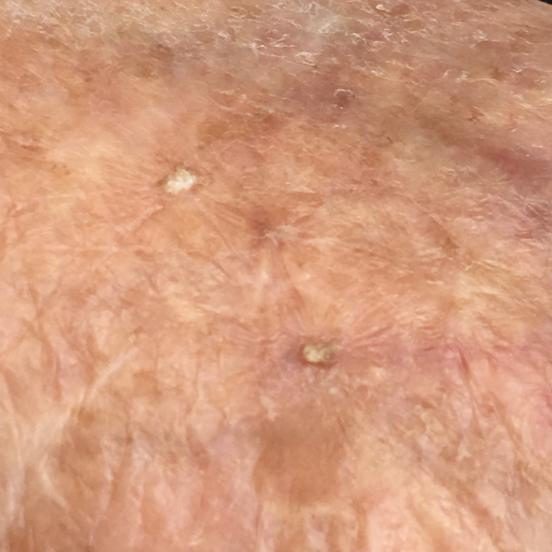

In [20]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.png"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

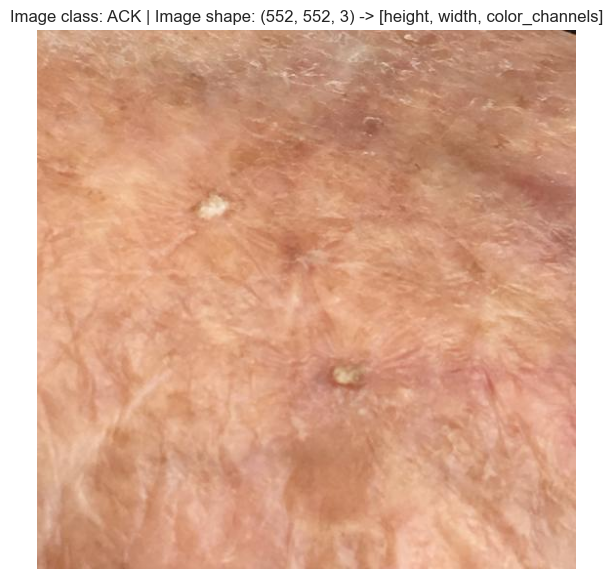

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## data into pytorch

In [22]:
dataclass_transform = transforms.Compose([
    #resize the image
    transforms.Resize(size=(212,212)),
    #flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),#p = probability of flip, 0.5=50%
    #turn the image into a torch.tensor
    transforms.ToTensor()##this also converts all pixxel values from 0 to 255 to be between 0.0 to 1.0
    
    
])

In [23]:
img.size

(552, 552)

In [24]:
dataclass_transform(img)

tensor([[[0.1216, 0.1490, 0.2392,  ..., 0.8353, 0.8039, 0.7961],
         [0.3333, 0.4510, 0.6039,  ..., 0.8588, 0.8078, 0.8039],
         [0.6902, 0.6980, 0.7059,  ..., 0.8471, 0.8275, 0.8392],
         ...,
         [0.8745, 0.8902, 0.8902,  ..., 0.7451, 0.7608, 0.7294],
         [0.8863, 0.8863, 0.8824,  ..., 0.7412, 0.7647, 0.7451],
         [0.8784, 0.8745, 0.8784,  ..., 0.7569, 0.7843, 0.7686]],

        [[0.0824, 0.1020, 0.1765,  ..., 0.6824, 0.6431, 0.6275],
         [0.2235, 0.3333, 0.4784,  ..., 0.6941, 0.6431, 0.6353],
         [0.5176, 0.5176, 0.5255,  ..., 0.6784, 0.6549, 0.6667],
         ...,
         [0.6941, 0.7098, 0.7098,  ..., 0.5216, 0.5451, 0.5255],
         [0.7059, 0.7059, 0.7059,  ..., 0.5176, 0.5490, 0.5451],
         [0.6980, 0.6941, 0.6980,  ..., 0.5333, 0.5686, 0.5647]],

        [[0.0706, 0.0824, 0.1451,  ..., 0.5569, 0.5098, 0.4941],
         [0.1569, 0.2588, 0.4000,  ..., 0.5765, 0.5098, 0.5020],
         [0.4078, 0.4039, 0.4157,  ..., 0.5608, 0.5255, 0.

In [25]:
def plot_transformed_images(image_paths,transform,n=None):
    random.seed(18122005)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Orginal image\n{f.size}")
            ax[0].axis('off')
            #transfoming image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed image\n{transformed_image.shape}")
            ax[1].axis('off')
            fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

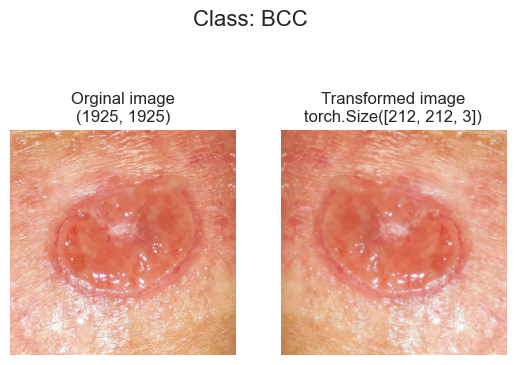

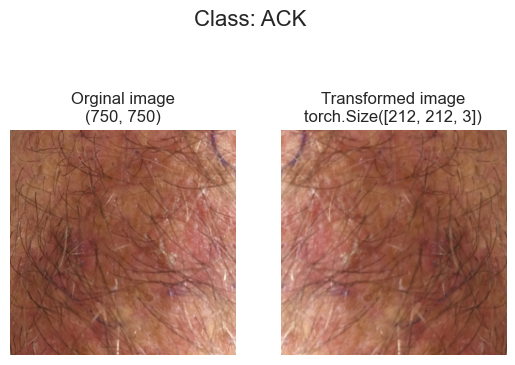

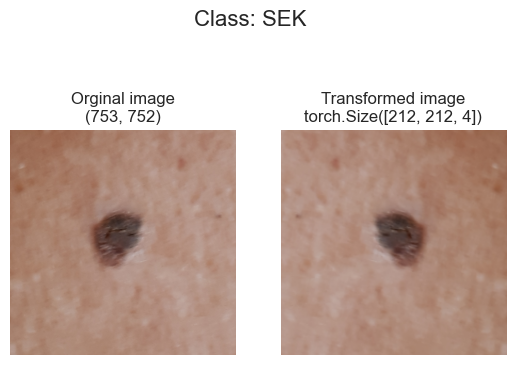

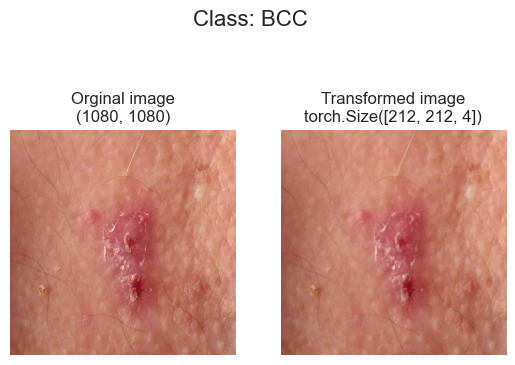

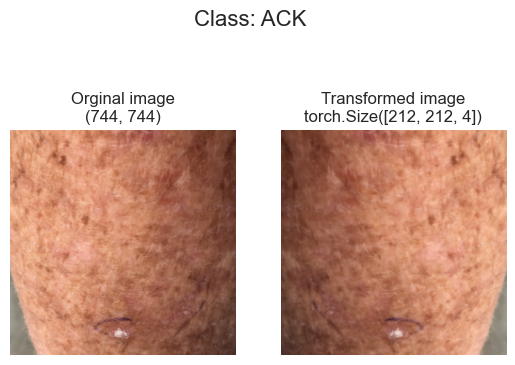

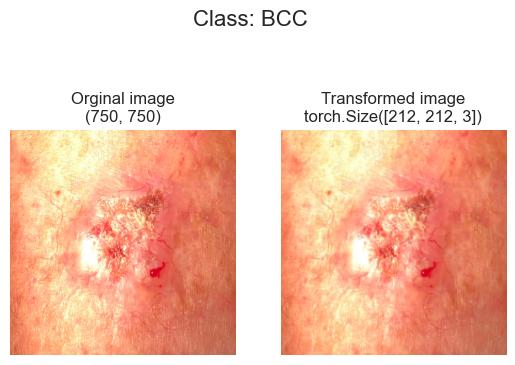

In [26]:
plot_transformed_images(image_paths=image_path_list,transform=dataclass_transform,n=6)

## Loading image data using ImageFolder 

In [27]:
train_data = datasets.ImageFolder(train_dir, transform=dataclass_transform,target_transform=None)
test_data = datasets.ImageFolder(test_dir, transform=dataclass_transform)
print(f"Train data : \n{train_data}\nTest data : \n{test_data}")

Train data : 
Dataset ImageFolder
    Number of datapoints: 1838
    Root location: /Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Train
    StandardTransform
Transform: Compose(
               Resize(size=(212, 212), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data : 
Dataset ImageFolder
    Number of datapoints: 460
    Root location: /Users/ziaulhoque/Desktop/pytorchPractise/data/Image/Test
    StandardTransform
Transform: Compose(
               Resize(size=(212, 212), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [28]:
class_names = train_data.classes
class_names

['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

In [29]:
class_dict = dict(zip(class_names, range(len(class_names))))
class_dict

{'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}

In [30]:
class_dict = train_data.class_to_idx
class_dict

{'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}

In [31]:
len(train_data),len(test_data)

(1838, 460)

In [32]:
img,label = train_data[0][0],train_data[0][1] 
print(f"Image tensor:\n{img}")
print(f"Image shape:\n{img.shape}")
print(f"Image datatype:\n{img.dtype}")
print(f"Image label:{label}")
print(f"Label datatype:{type(label)}")


Image tensor:
tensor([[[0.6000, 0.5882, 0.5882,  ..., 0.8078, 0.8078, 0.8078],
         [0.5804, 0.5725, 0.5765,  ..., 0.8078, 0.8078, 0.8078],
         [0.5686, 0.5647, 0.5765,  ..., 0.8078, 0.8078, 0.8078],
         ...,
         [0.5882, 0.5765, 0.5843,  ..., 0.7922, 0.8039, 0.8078],
         [0.6039, 0.5804, 0.5804,  ..., 0.8039, 0.8078, 0.8078],
         [0.6157, 0.5882, 0.5725,  ..., 0.8118, 0.8118, 0.8157]],

        [[0.4118, 0.4000, 0.4000,  ..., 0.8039, 0.8039, 0.8039],
         [0.3922, 0.3843, 0.3882,  ..., 0.8039, 0.8039, 0.8039],
         [0.3804, 0.3765, 0.3882,  ..., 0.8039, 0.8039, 0.8039],
         ...,
         [0.4431, 0.4314, 0.4392,  ..., 0.5765, 0.5882, 0.5961],
         [0.4588, 0.4353, 0.4353,  ..., 0.5843, 0.5922, 0.5961],
         [0.4706, 0.4431, 0.4275,  ..., 0.5922, 0.5961, 0.6039]],

        [[0.2549, 0.2431, 0.2431,  ..., 0.6824, 0.6824, 0.6824],
         [0.2353, 0.2275, 0.2314,  ..., 0.6824, 0.6824, 0.6824],
         [0.2235, 0.2196, 0.2314,  ..., 0.68

In [33]:
for batch in train_data:
    img, label = batch
    print(f"Image tensor:\n{img}")
    print(f"Image shape:\n{img.shape}")
    print(f"Image datatype:\n{img.dtype}")
    print(f"Image label:{label}")
    print(f"Label datatype:{type(label)}")
    break  # Only print the first batch to avoid looping over everything


Image tensor:
tensor([[[0.6000, 0.5882, 0.5882,  ..., 0.8078, 0.8078, 0.8078],
         [0.5804, 0.5725, 0.5765,  ..., 0.8078, 0.8078, 0.8078],
         [0.5686, 0.5647, 0.5765,  ..., 0.8078, 0.8078, 0.8078],
         ...,
         [0.5882, 0.5765, 0.5843,  ..., 0.7922, 0.8039, 0.8078],
         [0.6039, 0.5804, 0.5804,  ..., 0.8039, 0.8078, 0.8078],
         [0.6157, 0.5882, 0.5725,  ..., 0.8118, 0.8118, 0.8157]],

        [[0.4118, 0.4000, 0.4000,  ..., 0.8039, 0.8039, 0.8039],
         [0.3922, 0.3843, 0.3882,  ..., 0.8039, 0.8039, 0.8039],
         [0.3804, 0.3765, 0.3882,  ..., 0.8039, 0.8039, 0.8039],
         ...,
         [0.4431, 0.4314, 0.4392,  ..., 0.5765, 0.5882, 0.5961],
         [0.4588, 0.4353, 0.4353,  ..., 0.5843, 0.5922, 0.5961],
         [0.4706, 0.4431, 0.4275,  ..., 0.5922, 0.5961, 0.6039]],

        [[0.2549, 0.2431, 0.2431,  ..., 0.6824, 0.6824, 0.6824],
         [0.2353, 0.2275, 0.2314,  ..., 0.6824, 0.6824, 0.6824],
         [0.2235, 0.2196, 0.2314,  ..., 0.68

Original shape: torch.Size([3, 212, 212]) -> [color_channels, height, width]
Image permute shape: torch.Size([212, 212, 3]) -> [height, width, color_channels]


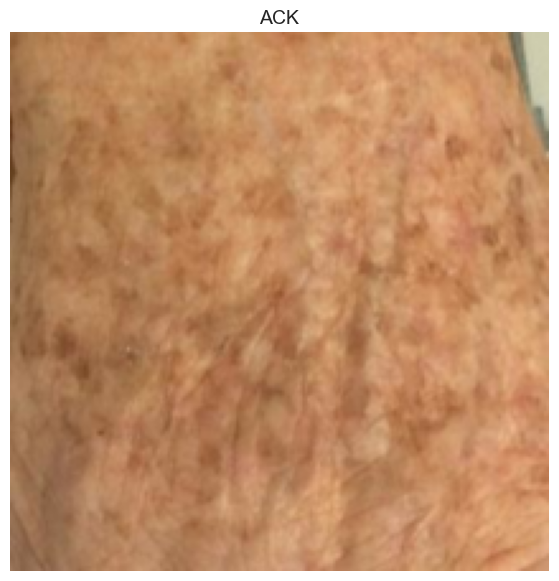

In [34]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [35]:
os.cpu_count()

8

In [36]:
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data, batch_size=BATCH_SIZE,num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset = test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x17def4860>,
 <torch.utils.data.dataloader.DataLoader at 0x17f9d23f0>)

In [37]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([1, 3, 212, 212]), torch.Size([1]))

In [38]:
img.unsqueeze(dim=0).shape

torch.Size([1, 3, 212, 212])

Image size: torch.Size([3, 212, 212])
Label: 0, label size: torch.Size([])


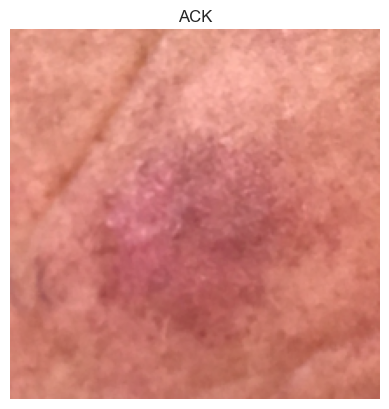

In [39]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.permute(1,2,0), cmap=plt.cm.RdYlBu)
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [40]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([3, 212, 212]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 44944]) -> [color_channels, height*width]


In [41]:
from torch import nn
class SkinDisease(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [42]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = SkinDisease(input_shape=134832, # one for every pixel (28x28)
                              hidden_units=10, # how many units in the hidden layer
                              output_shape=len(class_names) # one for every class
                              )
model_0.to("cpu") # keep model on CPU to begin with 

SkinDisease(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=134832, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=6, bias=True)
  )
)

In [43]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    # Note: you need the "raw" GitHub URL for this to work
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [44]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [45]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Device agnoistic code

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"using device: {device}")

using device: mps


In [47]:
# Create a model with non-linear and linear layers
class SkinDisease1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [48]:
torch.manual_seed(42)
model_1 = SkinDisease1(input_shape=134832, # number of input features
                              hidden_units=10,
                              output_shape=len(class_names) # number of output classes desired
                              ).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='mps', index=0)

In [49]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [50]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
                                    )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [51]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
               model=model_1,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn
               )
    test_step(data_loader=test_dataloader,
              model=model_1,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn
              )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.84927 | Train accuracy: 34.77%


 33%|███▎      | 1/3 [01:38<03:17, 98.67s/it]

Test loss: 1.79175 | Test accuracy: 29.57%

Epoch: 1
---------
Train loss: 1.79175 | Train accuracy: 32.32%


 67%|██████▋   | 2/3 [03:17<01:38, 98.73s/it]

Test loss: 1.79175 | Test accuracy: 29.57%

Epoch: 2
---------
Train loss: 1.79175 | Train accuracy: 32.32%


100%|██████████| 3/3 [04:56<00:00, 98.93s/it]

Test loss: 1.79175 | Test accuracy: 29.57%

Train time on mps: 296.796 seconds


In [52]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
                             loss_fn=loss_fn, accuracy_fn=accuracy_fn,
                             device=device
                             )
model_1_results

{'model_name': 'SkinDisease1',
 'model_loss': 1.791752576828003,
 'model_acc': 29.565217391304348}

# Building Convolutional NN, -> CNN


In [53]:
import torch
from torch import nn

class SkinDisease2(nn.Module):
    """
    Model architecture for skin disease classification.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),  # Keep spatial dimensions unchanged
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Halve the spatial dimensions
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Halve the spatial dimensions again
        )

        # Calculate the flattened size dynamically
        with torch.no_grad():
            sample_input = torch.randn(1, input_shape, 212, 212)  # Use the specified input size
            x = self.block_1(sample_input)
            x = self.block_2(x)
            flattened_size = x.numel() // x.size(0)  # Calculate features per sample

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_size, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


# Instantiate the model
torch.manual_seed(42)
model_2 = SkinDisease2(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_2


SkinDisease2(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=28090, out_features=6, bias=True)
  )
)

In [54]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
               model=model_2,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
               )
    test_step(data_loader=test_dataloader,
              model=model_2,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device
              )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.78948 | Train accuracy: 32.32%


 10%|█         | 1/10 [01:41<15:17, 101.99s/it]

Test loss: 1.79350 | Test accuracy: 29.57%

Epoch: 1
---------
Train loss: 1.78948 | Train accuracy: 32.32%


 20%|██        | 2/10 [03:22<13:30, 101.33s/it]

Test loss: 1.79351 | Test accuracy: 29.57%

Epoch: 2
---------
Train loss: 1.78947 | Train accuracy: 32.32%


 30%|███       | 3/10 [05:03<11:47, 101.10s/it]

Test loss: 1.79350 | Test accuracy: 29.57%

Epoch: 3
---------
Train loss: 1.78948 | Train accuracy: 32.32%


 40%|████      | 4/10 [06:44<10:05, 100.92s/it]

Test loss: 1.79342 | Test accuracy: 29.57%

Epoch: 4
---------
Train loss: 1.78945 | Train accuracy: 32.32%


 50%|█████     | 5/10 [08:25<08:24, 100.87s/it]

Test loss: 1.79344 | Test accuracy: 29.57%

Epoch: 5
---------
Train loss: 1.78948 | Train accuracy: 32.32%


 60%|██████    | 6/10 [10:07<06:45, 101.42s/it]

Test loss: 1.79343 | Test accuracy: 29.57%

Epoch: 6
---------
Train loss: 1.78947 | Train accuracy: 32.32%


 70%|███████   | 7/10 [11:48<05:03, 101.18s/it]

Test loss: 1.79347 | Test accuracy: 29.57%

Epoch: 7
---------
Train loss: 1.78946 | Train accuracy: 32.32%


 80%|████████  | 8/10 [13:29<03:22, 101.06s/it]

Test loss: 1.79349 | Test accuracy: 29.57%

Epoch: 8
---------
Train loss: 1.78946 | Train accuracy: 32.32%


 90%|█████████ | 9/10 [15:10<01:41, 101.18s/it]

Test loss: 1.79346 | Test accuracy: 29.57%

Epoch: 9
---------
Train loss: 1.78945 | Train accuracy: 32.32%


100%|██████████| 10/10 [16:53<00:00, 101.38s/it]

Test loss: 1.79353 | Test accuracy: 29.57%

Train time on mps: 1013.734 seconds


# Resnet50 with conv2


In [55]:
import torch
from torch import nn
from torchvision import models

class SkinDiseaseResNet50(nn.Module):
    """
    Model architecture for skin disease classification using ResNet-50.
    """
    def __init__(self, input_shape: int, output_shape: int, pretrained: bool = True):
        super().__init__()
        # Load ResNet-50 backbone
        self.resnet50 = models.resnet50(pretrained=pretrained)

        # Adjust the first convolutional layer for input_shape if needed
        if input_shape != 3:  # Default ResNet-50 is for 3-channel input
            self.resnet50.conv1 = nn.Conv2d(
                in_channels=input_shape,  # Use the custom input channels
                out_channels=64,
                kernel_size=7,
                stride=2,
                padding=3,
                bias=False
            )

        # Replace the classifier (fully connected) layer
        self.resnet50.fc = nn.Linear(
            in_features=self.resnet50.fc.in_features,  # Default input features
            out_features=output_shape  # Number of output classes
        )

    def forward(self, x: torch.Tensor):
        return self.resnet50(x)


# Instantiate the model
torch.manual_seed(42)
model_resnet50 = SkinDiseaseResNet50(input_shape=3, output_shape=len(class_names), pretrained=True).to(device)
model_resnet50


SkinDiseaseResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

# Model save and reloading name for resnet 50

In [56]:
model_resnet50 = SkinDiseaseResNet50(input_shape=3, output_shape=len(class_names), pretrained=True).to(device)
model_resnet50

SkinDiseaseResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

## RESNET 50 conv2d without data augmantation

In [57]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
               model=model_resnet50,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
               )
    test_step(data_loader=test_dataloader,
              model=model_resnet50,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device
              )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.92106 | Train accuracy: 11.04%


 10%|█         | 1/10 [02:50<25:35, 170.66s/it]

Test loss: 1.93202 | Test accuracy: 9.35%

Epoch: 1
---------
Train loss: 1.94628 | Train accuracy: 7.94%


 20%|██        | 2/10 [05:32<22:04, 165.56s/it]

Test loss: 1.94176 | Test accuracy: 9.13%

Epoch: 2
---------
Train loss: 1.95106 | Train accuracy: 8.22%


 30%|███       | 3/10 [08:13<19:02, 163.21s/it]

Test loss: 1.94242 | Test accuracy: 9.78%

Epoch: 3
---------
Train loss: 1.94619 | Train accuracy: 8.92%


 40%|████      | 4/10 [10:52<16:10, 161.73s/it]

Test loss: 1.93706 | Test accuracy: 9.13%

Epoch: 4
---------
Train loss: 1.94893 | Train accuracy: 8.05%


 50%|█████     | 5/10 [13:32<13:25, 161.06s/it]

Test loss: 1.93865 | Test accuracy: 8.91%

Epoch: 5
---------
Train loss: 1.94808 | Train accuracy: 8.22%


 60%|██████    | 6/10 [16:11<10:42, 160.55s/it]

Test loss: 1.93891 | Test accuracy: 8.48%

Epoch: 6
---------
Train loss: 1.94727 | Train accuracy: 8.43%


 70%|███████   | 7/10 [18:51<08:00, 160.10s/it]

Test loss: 1.94382 | Test accuracy: 8.48%

Epoch: 7
---------
Train loss: 1.94918 | Train accuracy: 8.16%


 80%|████████  | 8/10 [21:40<05:25, 162.95s/it]

Test loss: 1.93932 | Test accuracy: 9.35%

Epoch: 8
---------
Train loss: 1.95073 | Train accuracy: 7.94%


 90%|█████████ | 9/10 [24:23<02:42, 162.94s/it]

Test loss: 1.93993 | Test accuracy: 8.70%

Epoch: 9
---------
Train loss: 1.94878 | Train accuracy: 8.11%


100%|██████████| 10/10 [27:08<00:00, 162.80s/it]

Test loss: 1.93942 | Test accuracy: 8.91%

Train time on mps: 1627.989 seconds


# RESNET 50 WITH DATA AUGMANTION

## Augmanting Data then again calling the model

In [58]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch

# Define data augmentation for training and normalization for testing
data_transforms2 = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(size=212, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((212, 212)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms2["train"])
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms2["test"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)


In [59]:
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim

# Load pre-trained ResNet-50
model_resnet50 = resnet50(pretrained=True)

# Freeze the feature extractor layers
for param in model_resnet50.parameters():
    param.requires_grad = False

# Replace the classifier (fc layer) to match the number of classes in your dataset
num_classes = len(train_dataset.classes)  # Number of classes in your dataset
model_resnet50.fc = nn.Sequential(
    nn.Linear(model_resnet50.fc.in_features, 256),  # Intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),  # Regularization
    nn.Linear(256, num_classes)  # Output layer
)

# Move model to GPU if available
model_resnet50 = model_resnet50.to(device)


In [60]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (for the classifier parameters)
optimizer = optim.Adam(model_resnet50.fc.parameters(), lr=1e-4, weight_decay=1e-5)

# Scheduler for dynamic learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)


## Training resnet 50 for 25 epoch

In [61]:
from tqdm.auto import tqdm
import numpy as np

# Training and Evaluation
epochs = 25

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}\n{'-'*20}")

    # -----------------
    # Training Phase
    # -----------------
    model_resnet50.train()
    train_losses, train_correct, total_train_samples = [], 0, 0

    for images, labels in tqdm(train_dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_resnet50(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    # Training metrics
    train_loss_mean = np.mean(train_losses)
    train_loss_std = np.std(train_losses)
    train_accuracy = train_correct / total_train_samples

    print(f"Train Loss: Mean={train_loss_mean:.4f}, Std={train_loss_std:.4f}")
    print(f"Train Accuracy: {train_accuracy*100:.2f}%")

    # -----------------
    # Evaluation Phase
    # -----------------
    model_resnet50.eval()
    val_losses, val_correct, total_val_samples = [], 0, 0

    with torch.inference_mode():
        for images, labels in tqdm(test_dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model_resnet50(images)
            loss = criterion(outputs, labels)

            val_losses.append(loss.item())

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    # Validation metrics
    val_loss_mean = np.mean(val_losses)
    val_loss_std = np.std(val_losses)
    val_accuracy = val_correct / total_val_samples

    print(f"Validation Loss: Mean={val_loss_mean:.4f}, Std={val_loss_std:.4f}")
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

    # Step scheduler
    scheduler.step(val_loss_mean)


Epoch 1/25
--------------------


Training: 100%|██████████| 92/92 [02:04<00:00,  1.35s/it]


Train Loss: Mean=1.5128, Std=0.1444
Train Accuracy: 38.68%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


Validation Loss: Mean=1.3876, Std=0.5603
Validation Accuracy: 43.04%
Epoch 2/25
--------------------


Training: 100%|██████████| 92/92 [02:04<00:00,  1.35s/it]


Train Loss: Mean=1.4012, Std=0.1733
Train Accuracy: 45.43%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.78it/s]


Validation Loss: Mean=1.2990, Std=0.5748
Validation Accuracy: 48.91%
Epoch 3/25
--------------------


Training: 100%|██████████| 92/92 [02:04<00:00,  1.35s/it]


Train Loss: Mean=1.3274, Std=0.1571
Train Accuracy: 49.84%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.80it/s]


Validation Loss: Mean=1.2459, Std=0.4907
Validation Accuracy: 54.35%
Epoch 4/25
--------------------


Training: 100%|██████████| 92/92 [02:04<00:00,  1.35s/it]


Train Loss: Mean=1.2737, Std=0.1678
Train Accuracy: 53.10%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


Validation Loss: Mean=1.1932, Std=0.5613
Validation Accuracy: 55.00%
Epoch 5/25
--------------------


Training: 100%|██████████| 92/92 [02:04<00:00,  1.35s/it]


Train Loss: Mean=1.2431, Std=0.1632
Train Accuracy: 53.10%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


Validation Loss: Mean=1.1541, Std=0.5396
Validation Accuracy: 55.65%
Epoch 6/25
--------------------


Training: 100%|██████████| 92/92 [02:04<00:00,  1.36s/it]


Train Loss: Mean=1.2228, Std=0.1699
Train Accuracy: 55.06%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


Validation Loss: Mean=1.1470, Std=0.5863
Validation Accuracy: 57.17%
Epoch 7/25
--------------------


Training: 100%|██████████| 92/92 [02:04<00:00,  1.35s/it]


Train Loss: Mean=1.2067, Std=0.1774
Train Accuracy: 55.77%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


Validation Loss: Mean=1.1090, Std=0.4972
Validation Accuracy: 58.48%
Epoch 8/25
--------------------


Training: 100%|██████████| 92/92 [02:05<00:00,  1.36s/it]


Train Loss: Mean=1.1957, Std=0.1678
Train Accuracy: 56.26%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


Validation Loss: Mean=1.0923, Std=0.5199
Validation Accuracy: 59.35%
Epoch 9/25
--------------------


Training: 100%|██████████| 92/92 [02:05<00:00,  1.36s/it]


Train Loss: Mean=1.1655, Std=0.1649
Train Accuracy: 56.09%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.78it/s]


Validation Loss: Mean=1.0843, Std=0.5035
Validation Accuracy: 58.70%
Epoch 10/25
--------------------


Training: 100%|██████████| 92/92 [02:05<00:00,  1.37s/it]


Train Loss: Mean=1.1435, Std=0.1927
Train Accuracy: 56.96%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.78it/s]


Validation Loss: Mean=1.0802, Std=0.4979
Validation Accuracy: 60.65%
Epoch 11/25
--------------------


Training: 100%|██████████| 92/92 [02:10<00:00,  1.42s/it]


Train Loss: Mean=1.1287, Std=0.1562
Train Accuracy: 57.56%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=1.0797, Std=0.4355
Validation Accuracy: 62.17%
Epoch 12/25
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.40s/it]


Train Loss: Mean=1.1383, Std=0.1747
Train Accuracy: 56.75%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.78it/s]


Validation Loss: Mean=1.0524, Std=0.4887
Validation Accuracy: 61.30%
Epoch 13/25
--------------------


Training: 100%|██████████| 92/92 [02:06<00:00,  1.37s/it]


Train Loss: Mean=1.1066, Std=0.1768
Train Accuracy: 58.60%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.72it/s]


Validation Loss: Mean=1.0572, Std=0.4864
Validation Accuracy: 59.35%
Epoch 14/25
--------------------


Training: 100%|██████████| 92/92 [02:13<00:00,  1.45s/it]


Train Loss: Mean=1.0908, Std=0.1910
Train Accuracy: 60.23%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.70it/s]


Validation Loss: Mean=1.0522, Std=0.5263
Validation Accuracy: 58.70%
Epoch 15/25
--------------------


Training: 100%|██████████| 92/92 [02:15<00:00,  1.48s/it]


Train Loss: Mean=1.0903, Std=0.1889
Train Accuracy: 59.63%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.66it/s]


Validation Loss: Mean=1.0452, Std=0.4724
Validation Accuracy: 58.48%
Epoch 16/25
--------------------


Training: 100%|██████████| 92/92 [02:10<00:00,  1.42s/it]


Train Loss: Mean=1.0716, Std=0.1856
Train Accuracy: 60.61%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=1.0248, Std=0.4828
Validation Accuracy: 61.30%
Epoch 17/25
--------------------


Training: 100%|██████████| 92/92 [02:11<00:00,  1.43s/it]


Train Loss: Mean=1.0804, Std=0.1947
Train Accuracy: 59.96%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.72it/s]


Validation Loss: Mean=1.0273, Std=0.4711
Validation Accuracy: 58.91%
Epoch 18/25
--------------------


Training: 100%|██████████| 92/92 [02:11<00:00,  1.43s/it]


Train Loss: Mean=1.0920, Std=0.1722
Train Accuracy: 59.79%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.69it/s]


Validation Loss: Mean=1.0136, Std=0.4446
Validation Accuracy: 64.13%
Epoch 19/25
--------------------


Training: 100%|██████████| 92/92 [02:12<00:00,  1.44s/it]


Train Loss: Mean=1.0691, Std=0.1799
Train Accuracy: 60.12%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.70it/s]


Validation Loss: Mean=1.0289, Std=0.4660
Validation Accuracy: 57.83%
Epoch 20/25
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0741, Std=0.1700
Train Accuracy: 58.98%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.72it/s]


Validation Loss: Mean=1.0067, Std=0.5140
Validation Accuracy: 62.61%
Epoch 21/25
--------------------


Training: 100%|██████████| 92/92 [02:13<00:00,  1.45s/it]


Train Loss: Mean=1.0487, Std=0.1662
Train Accuracy: 60.77%


Validation: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s]


Validation Loss: Mean=1.0211, Std=0.5145
Validation Accuracy: 59.78%
Epoch 22/25
--------------------


Training: 100%|██████████| 92/92 [02:15<00:00,  1.48s/it]


Train Loss: Mean=1.0418, Std=0.1856
Train Accuracy: 60.88%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.69it/s]


Validation Loss: Mean=1.0048, Std=0.5084
Validation Accuracy: 62.39%
Epoch 23/25
--------------------


Training: 100%|██████████| 92/92 [02:11<00:00,  1.43s/it]


Train Loss: Mean=1.0722, Std=0.1909
Train Accuracy: 59.96%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Validation Loss: Mean=0.9964, Std=0.4871
Validation Accuracy: 60.65%
Epoch 24/25
--------------------


Training: 100%|██████████| 92/92 [02:11<00:00,  1.43s/it]


Train Loss: Mean=1.0401, Std=0.1611
Train Accuracy: 60.45%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.70it/s]


Validation Loss: Mean=1.0159, Std=0.5237
Validation Accuracy: 58.48%
Epoch 25/25
--------------------


Training: 100%|██████████| 92/92 [02:10<00:00,  1.41s/it]


Train Loss: Mean=1.0412, Std=0.2087
Train Accuracy: 60.77%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.68it/s]

Validation Loss: Mean=0.9891, Std=0.5190
Validation Accuracy: 62.61%


## Training Resnet 50 for 50 epoch

In [62]:
from tqdm.auto import tqdm
import numpy as np

# Training and Evaluation
epochs = 50

# Initialize accumulators for final statistics
total_train_losses = []
total_train_correct = 0
total_train_samples = 0

total_val_losses = []
total_val_correct = 0
total_val_samples = 0

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}\n{'-'*20}")

    # -----------------
    # Training Phase
    # -----------------
    model_resnet50.train()
    train_losses, train_correct, total_train_samples_epoch = [], 0, 0

    for images, labels in tqdm(train_dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_resnet50(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        total_train_samples_epoch += labels.size(0)

    # Update accumulators
    total_train_losses.extend(train_losses)
    total_train_correct += train_correct
    total_train_samples += total_train_samples_epoch

    # Training metrics
    train_loss_mean = np.mean(train_losses)
    train_loss_std = np.std(train_losses)
    train_accuracy = train_correct / total_train_samples_epoch

    print(f"Train Loss: Mean={train_loss_mean:.4f}, Std={train_loss_std:.4f}")
    print(f"Train Accuracy: {train_accuracy*100:.2f}%")

    # -----------------
    # Evaluation Phase
    # -----------------
    model_resnet50.eval()
    val_losses, val_correct, total_val_samples_epoch = [], 0, 0

    with torch.inference_mode():
        for images, labels in tqdm(test_dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model_resnet50(images)
            loss = criterion(outputs, labels)

            val_losses.append(loss.item())

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total_val_samples_epoch += labels.size(0)

    # Update accumulators
    total_val_losses.extend(val_losses)
    total_val_correct += val_correct
    total_val_samples += total_val_samples_epoch

    # Validation metrics
    val_loss_mean = np.mean(val_losses)
    val_loss_std = np.std(val_losses)
    val_accuracy = val_correct / total_val_samples_epoch

    print(f"Validation Loss: Mean={val_loss_mean:.4f}, Std={val_loss_std:.4f}")
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

    # Step scheduler
    scheduler.step(val_loss_mean)

# -------------------------
# Final Averaged Metrics
# -------------------------
# Final Training Metrics
final_train_loss_mean = np.mean(total_train_losses)
final_train_loss_std = np.std(total_train_losses)
final_train_accuracy = total_train_correct / total_train_samples

print(f"\nFinal Training Loss: Mean={final_train_loss_mean:.4f}, Std={final_train_loss_std:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy*100:.2f}%")

# Final Validation Metrics
final_val_loss_mean = np.mean(total_val_losses)
final_val_loss_std = np.std(total_val_losses)
final_val_accuracy = total_val_correct / total_val_samples

print(f"Final Validation Loss: Mean={final_val_loss_mean:.4f}, Std={final_val_loss_std:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy*100:.2f}%")


Epoch 1/50
--------------------


Training: 100%|██████████| 92/92 [02:10<00:00,  1.42s/it]


Train Loss: Mean=1.0317, Std=0.1922
Train Accuracy: 60.55%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.70it/s]


Validation Loss: Mean=0.9903, Std=0.4918
Validation Accuracy: 61.52%
Epoch 2/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0506, Std=0.1852
Train Accuracy: 59.58%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.69it/s]


Validation Loss: Mean=0.9950, Std=0.4853
Validation Accuracy: 60.43%
Epoch 3/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.40s/it]


Train Loss: Mean=1.0497, Std=0.1785
Train Accuracy: 60.07%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.75it/s]


Validation Loss: Mean=0.9911, Std=0.5611
Validation Accuracy: 62.39%
Epoch 4/50
--------------------


Training: 100%|██████████| 92/92 [02:10<00:00,  1.42s/it]


Train Loss: Mean=1.0179, Std=0.2012
Train Accuracy: 61.32%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.70it/s]


Validation Loss: Mean=0.9866, Std=0.5036
Validation Accuracy: 62.39%
Epoch 5/50
--------------------


Training: 100%|██████████| 92/92 [02:12<00:00,  1.44s/it]


Train Loss: Mean=0.9988, Std=0.1866
Train Accuracy: 63.00%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.70it/s]


Validation Loss: Mean=0.9885, Std=0.4905
Validation Accuracy: 61.96%
Epoch 6/50
--------------------


Training: 100%|██████████| 92/92 [02:13<00:00,  1.45s/it]


Train Loss: Mean=1.0201, Std=0.1768
Train Accuracy: 61.37%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.70it/s]


Validation Loss: Mean=0.9825, Std=0.4803
Validation Accuracy: 60.65%
Epoch 7/50
--------------------


Training: 100%|██████████| 92/92 [02:14<00:00,  1.46s/it]


Train Loss: Mean=1.0235, Std=0.1997
Train Accuracy: 61.81%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.67it/s]


Validation Loss: Mean=0.9869, Std=0.4911
Validation Accuracy: 63.26%
Epoch 8/50
--------------------


Training: 100%|██████████| 92/92 [02:13<00:00,  1.45s/it]


Train Loss: Mean=1.0210, Std=0.1916
Train Accuracy: 60.39%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.69it/s]


Validation Loss: Mean=0.9844, Std=0.4914
Validation Accuracy: 61.74%
Epoch 9/50
--------------------


Training: 100%|██████████| 92/92 [02:13<00:00,  1.45s/it]


Train Loss: Mean=1.0029, Std=0.2138
Train Accuracy: 62.95%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.68it/s]


Validation Loss: Mean=0.9939, Std=0.4923
Validation Accuracy: 61.30%
Epoch 10/50
--------------------


Training: 100%|██████████| 92/92 [02:14<00:00,  1.46s/it]


Train Loss: Mean=0.9944, Std=0.1713
Train Accuracy: 63.55%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.67it/s]


Validation Loss: Mean=0.9875, Std=0.4892
Validation Accuracy: 60.43%
Epoch 11/50
--------------------


Training: 100%|██████████| 92/92 [02:15<00:00,  1.47s/it]


Train Loss: Mean=1.0034, Std=0.1814
Train Accuracy: 60.72%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.67it/s]


Validation Loss: Mean=0.9917, Std=0.4793
Validation Accuracy: 60.43%
Epoch 12/50
--------------------


Training: 100%|██████████| 92/92 [02:14<00:00,  1.46s/it]


Train Loss: Mean=1.0016, Std=0.1807
Train Accuracy: 62.79%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.68it/s]


Validation Loss: Mean=0.9888, Std=0.4655
Validation Accuracy: 61.74%
Epoch 13/50
--------------------


Training: 100%|██████████| 92/92 [02:15<00:00,  1.47s/it]


Train Loss: Mean=1.0141, Std=0.2066
Train Accuracy: 61.37%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.68it/s]


Validation Loss: Mean=0.9780, Std=0.4858
Validation Accuracy: 61.74%
Epoch 14/50
--------------------


Training: 100%|██████████| 92/92 [02:13<00:00,  1.46s/it]


Train Loss: Mean=1.0124, Std=0.1772
Train Accuracy: 60.99%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.66it/s]


Validation Loss: Mean=0.9847, Std=0.4933
Validation Accuracy: 61.74%
Epoch 15/50
--------------------


Training: 100%|██████████| 92/92 [02:15<00:00,  1.48s/it]


Train Loss: Mean=1.0187, Std=0.2058
Train Accuracy: 61.64%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Validation Loss: Mean=0.9796, Std=0.4884
Validation Accuracy: 62.39%
Epoch 16/50
--------------------


Training: 100%|██████████| 92/92 [02:21<00:00,  1.53s/it]


Train Loss: Mean=1.0097, Std=0.1784
Train Accuracy: 62.02%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.71it/s]


Validation Loss: Mean=0.9826, Std=0.4854
Validation Accuracy: 61.09%
Epoch 17/50
--------------------


Training: 100%|██████████| 92/92 [02:11<00:00,  1.42s/it]


Train Loss: Mean=0.9958, Std=0.1789
Train Accuracy: 63.66%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9897, Std=0.4934
Validation Accuracy: 60.43%
Epoch 18/50
--------------------


Training: 100%|██████████| 92/92 [02:11<00:00,  1.43s/it]


Train Loss: Mean=1.0218, Std=0.1800
Train Accuracy: 62.13%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.69it/s]


Validation Loss: Mean=0.9818, Std=0.4949
Validation Accuracy: 61.96%
Epoch 19/50
--------------------


Training: 100%|██████████| 92/92 [02:10<00:00,  1.42s/it]


Train Loss: Mean=1.0181, Std=0.1861
Train Accuracy: 60.99%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.72it/s]


Validation Loss: Mean=0.9840, Std=0.4918
Validation Accuracy: 61.96%
Epoch 20/50
--------------------


Training: 100%|██████████| 92/92 [02:11<00:00,  1.43s/it]


Train Loss: Mean=0.9995, Std=0.1968
Train Accuracy: 61.75%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.68it/s]


Validation Loss: Mean=0.9807, Std=0.4846
Validation Accuracy: 61.96%
Epoch 21/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0084, Std=0.1896
Train Accuracy: 61.97%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Validation Loss: Mean=0.9920, Std=0.4785
Validation Accuracy: 60.65%
Epoch 22/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0045, Std=0.1907
Train Accuracy: 61.26%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9887, Std=0.4815
Validation Accuracy: 60.43%
Epoch 23/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0229, Std=0.1593
Train Accuracy: 60.83%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.72it/s]


Validation Loss: Mean=0.9866, Std=0.4903
Validation Accuracy: 61.09%
Epoch 24/50
--------------------


Training: 100%|██████████| 92/92 [02:10<00:00,  1.41s/it]


Train Loss: Mean=1.0214, Std=0.1895
Train Accuracy: 61.70%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Validation Loss: Mean=0.9822, Std=0.4938
Validation Accuracy: 61.30%
Epoch 25/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=0.9946, Std=0.1942
Train Accuracy: 61.86%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Validation Loss: Mean=0.9909, Std=0.4824
Validation Accuracy: 60.65%
Epoch 26/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=0.9916, Std=0.1663
Train Accuracy: 62.68%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Validation Loss: Mean=0.9789, Std=0.4958
Validation Accuracy: 62.83%
Epoch 27/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0212, Std=0.1905
Train Accuracy: 61.92%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9886, Std=0.4816
Validation Accuracy: 61.30%
Epoch 28/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0114, Std=0.2021
Train Accuracy: 62.13%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.72it/s]


Validation Loss: Mean=0.9883, Std=0.4797
Validation Accuracy: 61.74%
Epoch 29/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0008, Std=0.1854
Train Accuracy: 63.06%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Validation Loss: Mean=0.9815, Std=0.4877
Validation Accuracy: 61.09%
Epoch 30/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0104, Std=0.2028
Train Accuracy: 62.19%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9841, Std=0.4884
Validation Accuracy: 61.74%
Epoch 31/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0080, Std=0.2276
Train Accuracy: 63.44%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Validation Loss: Mean=0.9782, Std=0.4809
Validation Accuracy: 61.09%
Epoch 32/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.40s/it]


Train Loss: Mean=1.0164, Std=0.2028
Train Accuracy: 61.32%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9849, Std=0.4847
Validation Accuracy: 61.30%
Epoch 33/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0240, Std=0.2074
Train Accuracy: 61.81%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Validation Loss: Mean=0.9781, Std=0.4885
Validation Accuracy: 61.30%
Epoch 34/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0106, Std=0.1879
Train Accuracy: 61.81%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9993, Std=0.4780
Validation Accuracy: 60.65%
Epoch 35/50
--------------------


Training: 100%|██████████| 92/92 [02:08<00:00,  1.40s/it]


Train Loss: Mean=1.0057, Std=0.1954
Train Accuracy: 62.24%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9800, Std=0.4962
Validation Accuracy: 62.83%
Epoch 36/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=0.9931, Std=0.1840
Train Accuracy: 63.55%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9868, Std=0.4936
Validation Accuracy: 60.65%
Epoch 37/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0193, Std=0.1791
Train Accuracy: 61.15%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9884, Std=0.4840
Validation Accuracy: 61.09%
Epoch 38/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.40s/it]


Train Loss: Mean=1.0175, Std=0.2024
Train Accuracy: 62.24%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9885, Std=0.4939
Validation Accuracy: 61.09%
Epoch 39/50
--------------------


Training: 100%|██████████| 92/92 [02:09<00:00,  1.41s/it]


Train Loss: Mean=1.0110, Std=0.2040
Train Accuracy: 61.86%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Validation Loss: Mean=0.9854, Std=0.4931
Validation Accuracy: 61.74%
Epoch 40/50
--------------------


Training: 100%|██████████| 92/92 [02:14<00:00,  1.46s/it]


Train Loss: Mean=1.0035, Std=0.1622
Train Accuracy: 61.75%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.69it/s]


Validation Loss: Mean=0.9937, Std=0.4831
Validation Accuracy: 61.74%
Epoch 41/50
--------------------


Training: 100%|██████████| 92/92 [02:07<00:00,  1.38s/it]


Train Loss: Mean=1.0058, Std=0.1780
Train Accuracy: 60.83%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.78it/s]


Validation Loss: Mean=0.9851, Std=0.4986
Validation Accuracy: 61.30%
Epoch 42/50
--------------------


Training: 100%|██████████| 92/92 [02:06<00:00,  1.38s/it]


Train Loss: Mean=0.9853, Std=0.1737
Train Accuracy: 62.57%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Validation Loss: Mean=0.9889, Std=0.4962
Validation Accuracy: 61.30%
Epoch 43/50
--------------------


Training: 100%|██████████| 92/92 [02:06<00:00,  1.37s/it]


Train Loss: Mean=0.9926, Std=0.1695
Train Accuracy: 62.24%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.78it/s]


Validation Loss: Mean=0.9806, Std=0.4839
Validation Accuracy: 61.30%
Epoch 44/50
--------------------


Training: 100%|██████████| 92/92 [02:06<00:00,  1.37s/it]


Train Loss: Mean=1.0107, Std=0.1961
Train Accuracy: 62.46%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.75it/s]


Validation Loss: Mean=0.9951, Std=0.4786
Validation Accuracy: 60.87%
Epoch 45/50
--------------------


Training: 100%|██████████| 92/92 [02:05<00:00,  1.36s/it]


Train Loss: Mean=1.0184, Std=0.1812
Train Accuracy: 61.59%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


Validation Loss: Mean=0.9913, Std=0.5043
Validation Accuracy: 61.96%
Epoch 46/50
--------------------


Training: 100%|██████████| 92/92 [02:02<00:00,  1.33s/it]


Train Loss: Mean=1.0210, Std=0.1748
Train Accuracy: 61.70%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


Validation Loss: Mean=0.9881, Std=0.4771
Validation Accuracy: 60.22%
Epoch 47/50
--------------------


Training: 100%|██████████| 92/92 [02:04<00:00,  1.35s/it]


Train Loss: Mean=1.0272, Std=0.1952
Train Accuracy: 59.96%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.76it/s]


Validation Loss: Mean=0.9933, Std=0.4916
Validation Accuracy: 60.22%
Epoch 48/50
--------------------


Training: 100%|██████████| 92/92 [02:07<00:00,  1.39s/it]


Train Loss: Mean=1.0127, Std=0.1932
Train Accuracy: 62.13%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


Validation Loss: Mean=0.9951, Std=0.4954
Validation Accuracy: 60.87%
Epoch 49/50
--------------------


Training: 100%|██████████| 92/92 [02:02<00:00,  1.33s/it]


Train Loss: Mean=0.9923, Std=0.1752
Train Accuracy: 62.51%


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


Validation Loss: Mean=0.9874, Std=0.4835
Validation Accuracy: 61.09%
Epoch 50/50
--------------------


Training: 100%|██████████| 92/92 [06:35<00:00,  4.30s/it]  


Train Loss: Mean=1.0040, Std=0.1650
Train Accuracy: 61.04%


Validation: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]

Validation Loss: Mean=0.9905, Std=0.4740
Validation Accuracy: 60.43%

Final Training Loss: Mean=1.0114, Std=0.1889
Final Training Accuracy: 61.81%
Final Validation Loss: Mean=0.9870, Std=0.4893
Final Validation Accuracy: 61.35%


In [63]:
image_model_mean = (final_train_loss_mean + final_val_loss_mean)/2.0
image_model_std = (final_train_loss_std + final_val_loss_std)/2.0
image_model_accuracy = (final_train_accuracy + final_val_accuracy)/2.0
print(image_model_mean, image_model_std, image_model_accuracy)


0.9992100141553775 0.33910085546097557 0.615781567866774


In [64]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_resnet50.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_resnet50(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]


In [65]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.3


In [66]:
y_pred_tensor

tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 5, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 5, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 5, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 5, 1, 1, 0, 0, 3, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 0, 3, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 3, 1, 1, 1, 3, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 5, 1, 0, 1, 1, 1, 0, 1, 1,

In [67]:
import torch

# Check if y_pred_tensor is a PyTorch tensor
if isinstance(y_pred_tensor, torch.Tensor):
    print("y_pred_tensor is a PyTorch tensor.")
else:
    print("y_pred_tensor is NOT a PyTorch tensor.")


y_pred_tensor is a PyTorch tensor.


In [68]:
type(test_data.targets)


list

In [69]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.3


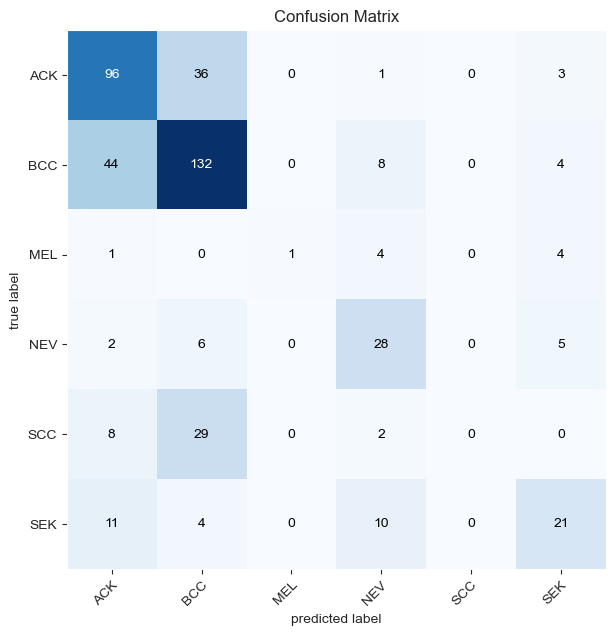

In [70]:
import torch
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# 1. Ensure both y_pred_tensor and test_data.targets are PyTorch tensors
y_pred_tensor = torch.tensor(y_pred_tensor)  # If it's a list, convert to tensor
true_labels_tensor = torch.tensor(test_data.targets)  # Convert test_data.targets (list) to tensor

# 2. Create confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

# 3. Compute the confusion matrix
confmat_tensor = confmat(preds=y_pred_tensor, target=true_labels_tensor)

# 4. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # Convert to NumPy for plotting
    class_names=class_names,          # Replace with your class names
    figsize=(10, 7)                   # Adjust figure size as needed
)

# Display the plot
plt.title("Confusion Matrix")
plt.show()


In [71]:
from sklearn.metrics import classification_report
print(classification_report(true_labels_tensor, y_pred_tensor))


              precision    recall  f1-score   support

           0       0.59      0.71      0.64       136
           1       0.64      0.70      0.67       188
           2       1.00      0.10      0.18        10
           3       0.53      0.68      0.60        41
           4       0.00      0.00      0.00        39
           5       0.57      0.46      0.51        46

    accuracy                           0.60       460
   macro avg       0.55      0.44      0.43       460
weighted avg       0.56      0.60      0.57       460



In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels_tensor, y_pred_tensor)
true_positives = np.diag(cm)  # Diagonal of confusion matrix
class_totals = cm.sum(axis=1)  # Total samples for each class (row sums)
per_class_accuracy = true_positives / class_totals
#target_labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]
image_label_accuracy=[]
for label, accuracy in zip(class_names, per_class_accuracy):
    print(f"{label} - Accuracy: {accuracy:.4f}")
    image_label_accuracy.append(accuracy)



ACK - Accuracy: 0.7059
BCC - Accuracy: 0.7021
MEL - Accuracy: 0.1000
NEV - Accuracy: 0.6829
SCC - Accuracy: 0.0000
SEK - Accuracy: 0.4565


In [73]:
image_label_accuracy

[0.7058823529411765,
 0.7021276595744681,
 0.1,
 0.6829268292682927,
 0.0,
 0.45652173913043476]

## 

# The Numeric Model

In [74]:
metadata.head()

patient_id  lesion_id  smoke  drink background_father background_mother  \
0   PAT_1516       1765    NaN    NaN               NaN               NaN   
1     PAT_46        881  False  False         POMERANIA         POMERANIA   
2   PAT_1545       1867    NaN    NaN               NaN               NaN   
3   PAT_1989       4061    NaN    NaN               NaN               NaN   
4    PAT_684       1302  False   True         POMERANIA         POMERANIA   

   age pesticide  gender skin_cancer_history  ... diameter_2 diagnostic  \
0    8       NaN     NaN                 NaN  ...        NaN        NEV   
1   55     False  FEMALE                True  ...        5.0        BCC   
2   77       NaN     NaN                 NaN  ...        NaN        ACK   
3   75       NaN     NaN                 NaN  ...        NaN        ACK   
4   79     False    MALE                True  ...        5.0        BCC   

    itch   grew   hurt  changed  bleed elevation                 img_id  \
0  FALSE  FALSE  FALSE    FALSE  FALSE     FALSE  PAT_1516_1765_530.png   
1   TRUE   TRUE  FALSE     TRUE   TRUE      TRUE     PAT_46_881_939.png   
2   TRUE  FALSE  FALSE    FALSE  FALSE     FALSE  PAT_1545_1867_547.png   
3   TRUE  FALSE  FALSE    FALSE  FALSE     FALSE  PAT_1989_4061_934.png   
4   TRUE   TRUE  FALSE    FALSE   TRUE      TRUE   PAT_684_1302_588.png   

  biopsed  
0   False  
1    True  
2   False  
3   False  
4    True  

[5 rows x 26 columns]

In [75]:
df_sorted = metadata.sort_values(by='patient_id')
df_sorted.head(10)

patient_id  lesion_id  smoke  drink background_father background_mother  \
1637     PAT_10         18   True  False           GERMANY           GERMANY   
2203    PAT_100        393  False  False         POMERANIA         POMERANIA   
1956    PAT_100        393  False  False         POMERANIA         POMERANIA   
1739   PAT_1000         31    NaN    NaN               NaN               NaN   
37     PAT_1006         53    NaN    NaN               NaN               NaN   
1136   PAT_1006         53    NaN    NaN               NaN               NaN   
1449   PAT_1008         59    NaN    NaN               NaN               NaN   
451     PAT_101       1041   True   True           GERMANY           GERMANY   
2077    PAT_101       1041   True   True           GERMANY           GERMANY   
1743    PAT_101       1041   True   True           GERMANY           GERMANY   

      age pesticide gender skin_cancer_history  ... diameter_2 diagnostic  \
1637   69     False   MALE               False  ...        9.0        SCC   
2203   14     False   MALE               False  ...        3.0        NEV   
1956   14     False   MALE               False  ...        3.0        NEV   
1739   65       NaN    NaN                 NaN  ...        NaN        SEK   
37     63       NaN    NaN                 NaN  ...        NaN        ACK   
1136   63       NaN    NaN                 NaN  ...        NaN        ACK   
1449   64       NaN    NaN                 NaN  ...        NaN        SEK   
451    59     False   MALE               False  ...       15.0        BCC   
2077   59     False   MALE               False  ...       15.0        BCC   
1743   59     False   MALE               False  ...       15.0        BCC   

       itch   grew   hurt  changed  bleed elevation                img_id  \
1637   TRUE    UNK  FALSE      UNK  FALSE      TRUE     PAT_10_18_830.png   
2203  FALSE  FALSE  FALSE    FALSE  FALSE     FALSE   PAT_100_393_595.png   
1956  FALSE  FALSE  FALSE    FALSE  FALSE     FALSE   PAT_100_393_898.png   
1739  FALSE  FALSE  FALSE    FALSE  FALSE     FALSE   PAT_1000_31_620.png   
37    FALSE  FALSE  FALSE    FALSE  FALSE     FALSE   PAT_1006_53_716.png   
1136  FALSE  FALSE  FALSE    FALSE  FALSE     FALSE   PAT_1006_53_385.png   
1449  FALSE   TRUE  FALSE    FALSE  FALSE      TRUE   PAT_1008_59_297.png   
451    TRUE   TRUE   TRUE    FALSE   TRUE      TRUE  PAT_101_1041_651.png   
2077   TRUE   TRUE   TRUE    FALSE   TRUE      TRUE  PAT_101_1041_898.png   
1743   TRUE   TRUE   TRUE    FALSE   TRUE      TRUE  PAT_101_1041_658.png   

     biopsed  
1637    True  
2203    True  
1956    True  
1739   False  
37     False  
1136   False  
1449   False  
451     True  
2077    True  
1743    True  

[10 rows x 26 columns]

In [76]:
print(f"total unique pathient {len(df_sorted['patient_id'].unique())}")
print(f"total patient {df_sorted['patient_id'].count()}")

total unique pathient 1373
total patient 2298


In [77]:
df_complete = df_sorted.dropna()
print(f"total unique pathient {len(df_complete['patient_id'].unique())}")
print(f"total patient {df_complete['patient_id'].count()}")

total unique pathient 794
total patient 1474


In [78]:
df_complete.head(15)

patient_id  lesion_id  smoke  drink background_father background_mother  \
1637     PAT_10         18   True  False           GERMANY           GERMANY   
2203    PAT_100        393  False  False         POMERANIA         POMERANIA   
1956    PAT_100        393  False  False         POMERANIA         POMERANIA   
451     PAT_101       1041   True   True           GERMANY           GERMANY   
2077    PAT_101       1041   True   True           GERMANY           GERMANY   
1743    PAT_101       1041   True   True           GERMANY           GERMANY   
2182    PAT_104       1756  False  False         POMERANIA         POMERANIA   
1773    PAT_104       1755  False  False         POMERANIA         POMERANIA   
1107    PAT_104       1754  False  False         POMERANIA         POMERANIA   
24      PAT_106        159  False  False         POMERANIA         POMERANIA   
399     PAT_106        158  False  False         POMERANIA         POMERANIA   
2177    PAT_106        158  False  False         POMERANIA         POMERANIA   
30      PAT_107        160  False  False         POMERANIA         POMERANIA   
503     PAT_108        162  False  False         POMERANIA         POMERANIA   
1540    PAT_108        161  False  False         POMERANIA         POMERANIA   

      age pesticide  gender skin_cancer_history  ... diameter_2 diagnostic  \
1637   69     False    MALE               False  ...        9.0        SCC   
2203   14     False    MALE               False  ...        3.0        NEV   
1956   14     False    MALE               False  ...        3.0        NEV   
451    59     False    MALE               False  ...       15.0        BCC   
2077   59     False    MALE               False  ...       15.0        BCC   
1743   59     False    MALE               False  ...       15.0        BCC   
2182   79      True  FEMALE                True  ...        9.0        BCC   
1773   79      True  FEMALE                True  ...       13.0        ACK   
1107   79      True  FEMALE                True  ...       10.0        ACK   
24     71     False  FEMALE                True  ...        3.0        BCC   
399    71     False  FEMALE                True  ...        8.0        BCC   
2177   71     False  FEMALE                True  ...        8.0        BCC   
30     82     False  FEMALE               False  ...        8.0        SEK   
503    68      True    MALE                True  ...        3.0        ACK   
1540   68      True    MALE                True  ...        7.0        SCC   

       itch   grew   hurt  changed  bleed elevation                img_id  \
1637   TRUE    UNK  FALSE      UNK  FALSE      TRUE     PAT_10_18_830.png   
2203  FALSE  FALSE  FALSE    FALSE  FALSE     FALSE   PAT_100_393_595.png   
1956  FALSE  FALSE  FALSE    FALSE  FALSE     FALSE   PAT_100_393_898.png   
451    TRUE   TRUE   TRUE    FALSE   TRUE      TRUE  PAT_101_1041_651.png   
2077   TRUE   TRUE   TRUE    FALSE   TRUE      TRUE  PAT_101_1041_898.png   
1743   TRUE   TRUE   TRUE    FALSE   TRUE      TRUE  PAT_101_1041_658.png   
2182   TRUE   TRUE  FALSE    FALSE  FALSE     FALSE  PAT_104_1756_151.png   
1773   TRUE  FALSE  FALSE    FALSE  FALSE      TRUE  PAT_104_1755_320.png   
1107   TRUE  FALSE  FALSE    FALSE  FALSE      TRUE  PAT_104_1754_276.png   
24     TRUE    UNK   TRUE      UNK   TRUE     FALSE   PAT_106_159_325.png   
399    TRUE   TRUE   TRUE    FALSE   TRUE     FALSE   PAT_106_158_249.png   
2177   TRUE   TRUE   TRUE    FALSE   TRUE     FALSE   PAT_106_158_270.png   
30    FALSE   TRUE  FALSE    FALSE  FALSE      TRUE   PAT_107_160_609.png   
503    TRUE   TRUE  FALSE    FALSE  FALSE      TRUE   PAT_108_162_526.png   
1540   TRUE   TRUE   TRUE     TRUE   TRUE      TRUE   PAT_108_161_575.png   

     biopsed  
1637    True  
2203    True  
1956    True  
451     True  
2077    True  
1743    True  
2182    True  
1773    True  
1107    True  
24      True  
399     True  
2177    True  
30      True  
503     True  
1540    True  

[

In [79]:
print(f"missing value of each feature: {df_sorted.isnull().sum()}")

missing value of each feature: patient_id               0
lesion_id                0
smoke                  804
drink                  804
background_father      818
background_mother      822
age                      0
pesticide              804
gender                 804
skin_cancer_history    804
cancer_history         804
has_piped_water        804
has_sewage_system      804
fitspatrick            804
region                   0
diameter_1             804
diameter_2             804
diagnostic               0
itch                     0
grew                     0
hurt                     0
changed                  0
bleed                    0
elevation                0
img_id                   0
biopsed                  0
dtype: int64


In [80]:

# Dropping multiple columns by passing them as a list
df_dropped = df_sorted.drop(['background_father', 'background_mother', 'lesion_id'], axis=1)



In [81]:
df_complete = df_dropped.dropna()
print(f"total unique pathient {len(df_complete['patient_id'].unique())}")
print(f"total patient {df_complete['patient_id'].count()}")

total unique pathient 794
total patient 1494


In [82]:
df_unique = df_complete.drop_duplicates(subset=['patient_id'])
len(df_unique)

794

In [83]:
df_unique.nunique()

patient_id             794
smoke                    2
drink                    2
age                     74
pesticide                2
gender                   2
skin_cancer_history      2
cancer_history           2
has_piped_water          2
has_sewage_system        2
fitspatrick              6
region                  14
diameter_1              41
diameter_2              38
diagnostic               6
itch                     3
grew                     3
hurt                     3
changed                  3
bleed                    3
elevation                3
img_id                 794
biopsed                  2
dtype: int64

In [84]:
target_variable = df_complete['diagnostic']

In [85]:
target_variable.unique()

array(['SCC', 'NEV', 'BCC', 'ACK', 'SEK', 'MEL'], dtype=object)

In [86]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 794 entries, 1637 to 529
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           794 non-null    object 
 1   smoke                794 non-null    object 
 2   drink                794 non-null    object 
 3   age                  794 non-null    int64  
 4   pesticide            794 non-null    object 
 5   gender               794 non-null    object 
 6   skin_cancer_history  794 non-null    object 
 7   cancer_history       794 non-null    object 
 8   has_piped_water      794 non-null    object 
 9   has_sewage_system    794 non-null    object 
 10  fitspatrick          794 non-null    float64
 11  region               794 non-null    object 
 12  diameter_1           794 non-null    float64
 13  diameter_2           794 non-null    float64
 14  diagnostic           794 non-null    object 
 15  itch                 794 non-null    objec

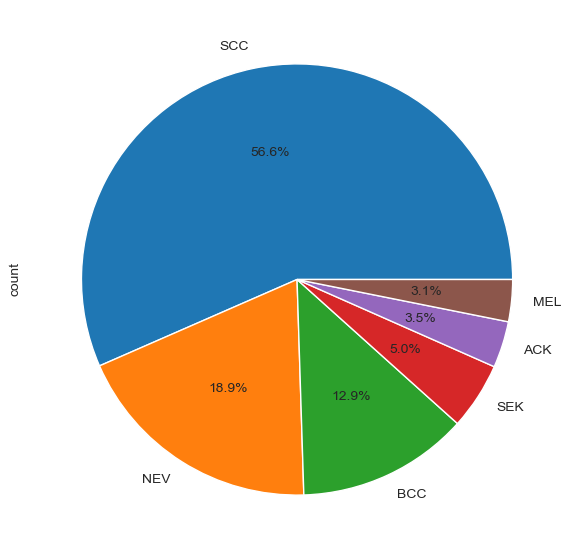

In [87]:
#visualize the distribution in target variable - piechart
plt.figure(figsize=(10,7))
df_complete['diagnostic'].value_counts().plot(kind='pie',autopct = '%1.1f%%',labels = ['SCC', 'NEV', 'BCC', 'SEK', 'ACK', 'MEL'])
plt.show()

In [88]:
#As we know SMOTE doesnt work on NAN value
rows_with_nans = df_complete[df_complete.isna().any(axis=1)]
print(rows_with_nans)

Empty DataFrame
Columns: [patient_id, smoke, drink, age, pesticide, gender, skin_cancer_history, cancer_history, has_piped_water, has_sewage_system, fitspatrick, region, diameter_1, diameter_2, diagnostic, itch, grew, hurt, changed, bleed, elevation, img_id, biopsed]
Index: []

[0 rows x 23 columns]


In [89]:
df_complete.columns

Index(['patient_id', 'smoke', 'drink', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'region', 'diameter_1',
       'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed',
       'elevation', 'img_id', 'biopsed'],
      dtype='object')

## Step-1 ML on ALL value with 20 feature

In [90]:
# Extract features (X) and target variable (y)
X = df_complete.iloc[:, 1:]  # Select all rows and columns from index 1 onward
X = X.drop(['diagnostic','img_id'], axis=1)  # Drop the 'diagnostic' column from features
y = df_complete['diagnostic']  # Target variable

# Print column names for X and y
print(f"X column list: {X.columns}")
print(f"y column name: {y.name}")


X column list: Index(['smoke', 'drink', 'age', 'pesticide', 'gender', 'skin_cancer_history',
       'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick',
       'region', 'diameter_1', 'diameter_2', 'itch', 'grew', 'hurt', 'changed',
       'bleed', 'elevation', 'biopsed'],
      dtype='object')
y column name: diagnostic


In [91]:
X.dtypes

smoke                   object
drink                   object
age                      int64
pesticide               object
gender                  object
skin_cancer_history     object
cancer_history          object
has_piped_water         object
has_sewage_system       object
fitspatrick            float64
region                  object
diameter_1             float64
diameter_2             float64
itch                    object
grew                    object
hurt                    object
changed                 object
bleed                   object
elevation               object
biopsed                   bool
dtype: object

In [92]:
X.nunique()

smoke                   2
drink                   2
age                    74
pesticide               2
gender                  2
skin_cancer_history     2
cancer_history          2
has_piped_water         2
has_sewage_system       2
fitspatrick             6
region                 14
diameter_1             42
diameter_2             38
itch                    3
grew                    3
hurt                    3
changed                 3
bleed                   3
elevation               3
biopsed                 2
dtype: int64

In [93]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to multiple columns in X
columns_to_encode = ['smoke', 'drink', 'pesticide', 'gender', 'skin_cancer_history',
                     'cancer_history', 'has_piped_water', 'has_sewage_system', 'region',
                     'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation']

X[columns_to_encode] = X[columns_to_encode].apply(label_encoder.fit_transform)

# Apply LabelEncoder to the 'diagnostic' column in y
le = LabelEncoder()
y = le.fit_transform(y)
# Check the transformed data
print(X)


      smoke  drink  age  pesticide  gender  skin_cancer_history  \
1637      1      0   69          0       1                    0   
2203      0      0   14          0       1                    0   
1956      0      0   14          0       1                    0   
451       1      1   59          0       1                    0   
2077      1      1   59          0       1                    0   
...     ...    ...  ...        ...     ...                  ...   
1121      1      0   82          0       1                    0   
870       0      0   52          1       0                    1   
1678      0      0   52          1       0                    1   
529       0      0   49          0       0                    0   
86        0      0   49          0       0                    0   

      cancer_history  has_piped_water  has_sewage_system  fitspatrick  region  \
1637               0                1                  0          1.0       1   
2203               1             

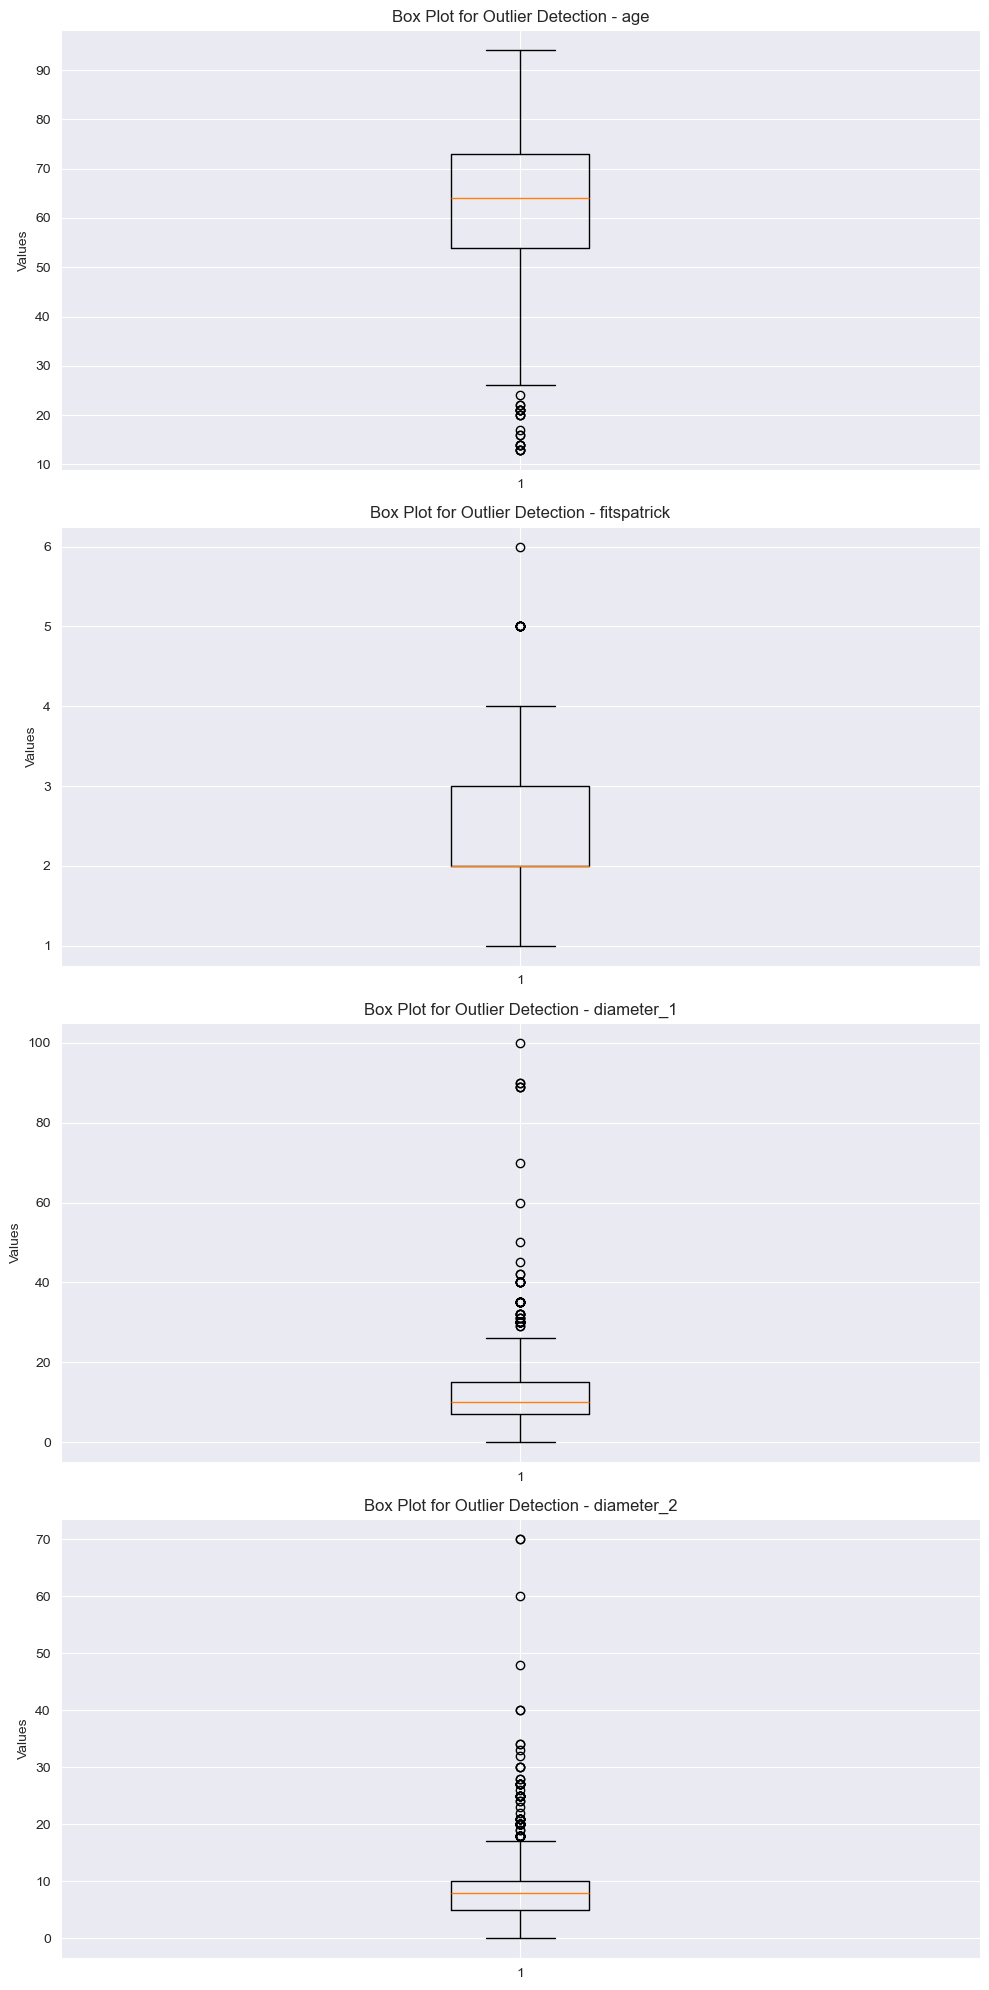

In [94]:
import matplotlib.pyplot as plt

# Select only numeric columns from df_complete
numeric_columns = df_complete.select_dtypes(include=['number']).columns

# Adjust figure size if needed
plt.figure(figsize=(10, 5 * len(numeric_columns)))  # Adjust figure size based on the number of numeric columns

# Loop through each numeric column in the DataFrame and plot
i = 1
for column in numeric_columns:
    plt.subplot(len(numeric_columns), 1, i)  # Create a subplot for each numeric column
    plt.boxplot(df_complete[column])
    plt.title(f'Box Plot for Outlier Detection - {column}')
    plt.ylabel('Values')
    i += 1  # Increment subplot index

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


In [95]:
from sklearn.ensemble import IsolationForest


# Initialize Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42)

# Fit the model and predict outliers
outliers = iso_forest.fit_predict(X)

# Filter outliers
x_filtered = X[outliers == 1]
y_filtered = y[outliers == 1]

# Display the shapes of x_filtered and y_filtered to confirm
print("Shape of x_filtered:", x_filtered.shape)
print("Shape of y_filtered:", y_filtered.shape)

Shape of x_filtered: (1344, 20)
Shape of y_filtered: (1344,)


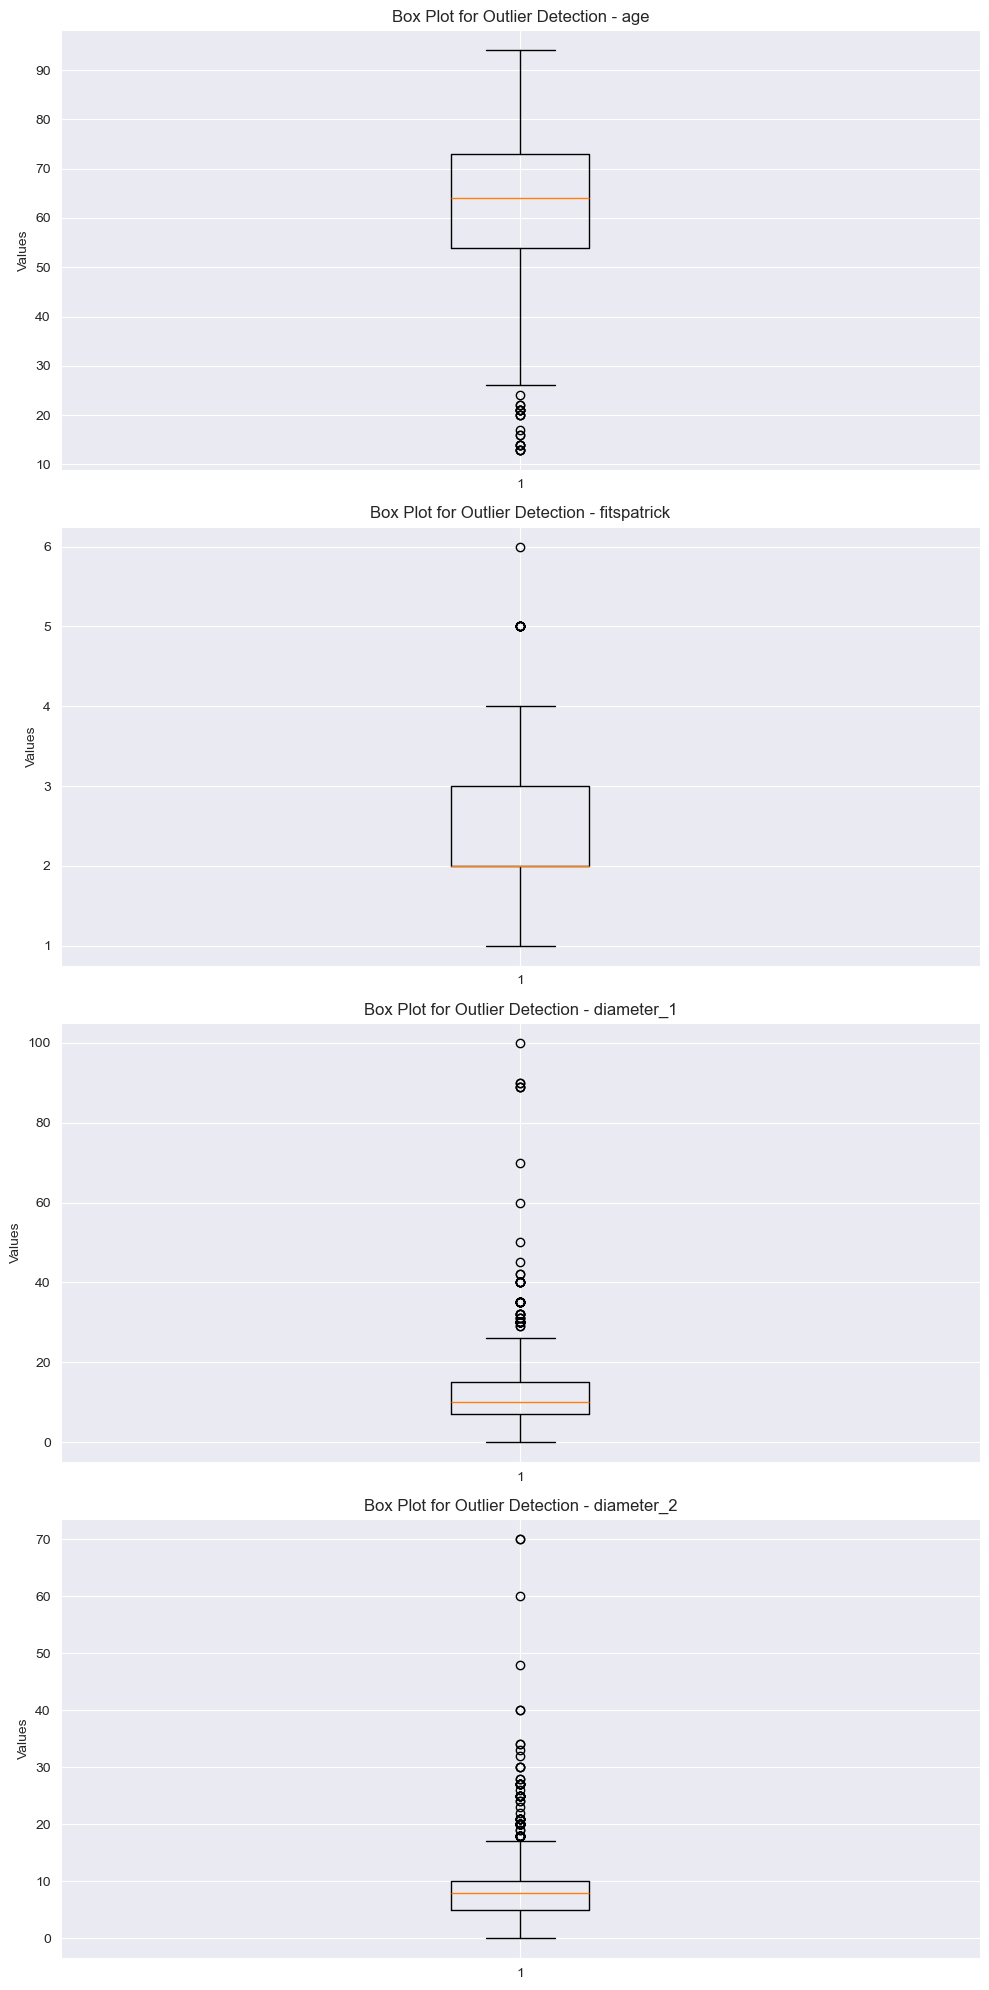

In [96]:
import matplotlib.pyplot as plt

# Select only numeric columns from df_complete
numeric_columns = df_complete.select_dtypes(include=['number']).columns

# Adjust figure size if needed
plt.figure(figsize=(10, 5 * len(numeric_columns)))  # Adjust figure size based on the number of numeric columns

# Loop through each numeric column in the DataFrame and plot
i = 1
for column in numeric_columns:
    plt.subplot(len(numeric_columns), 1, i)  # Create a subplot for each numeric column
    plt.boxplot(df_complete[column])
    plt.title(f'Box Plot for Outlier Detection - {column}')
    plt.ylabel('Values')
    i += 1  # Increment subplot index

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


In [97]:
len(X)

1494

In [98]:
y

array([4, 3, 3, ..., 1, 2, 2])

In [99]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Assuming X and y are your input features and target variable
os = SMOTE(random_state=0)
X_os, y_os = os.fit_resample(X, y)

# Convert y_os to a pandas Series
y_os_series = pd.Series(y_os)

# Use value_counts(normalize=True) on the Series
print(y_os_series.value_counts(normalize=True))


4    0.166667
3    0.166667
1    0.166667
0    0.166667
5    0.166667
2    0.166667
Name: proportion, dtype: float64


In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_os,y_os, test_size = .2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4056, 20) (1014, 20) (4056,) (1014,)


In [101]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [102]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, log_loss, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import numpy as np



# Traditional classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

print("Traditional Classifiers:")
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    score = clf.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    ll = log_loss(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    # Calculate RMSE based on predicted probabilities
    y_pred_proba_max = np.max(y_pred_proba, axis=1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba_max))

    print(f"\n{name}:")
    print(f"Accuracy: {score:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")
    print(f"Log Loss: {ll:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Helper class for hybrid models
class BoostingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, boosting_model):
        self.base_classifier = base_classifier
        self.boosting_model = boosting_model

    def fit(self, X, y):
        # Fit the base classifier
        self.base_classifier.fit(X, y)
        # Use the predictions of the base classifier as new features
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Fit the boosting model on the new features
        self.boosting_model.fit(base_predictions, y)
        return self

    def predict(self, X):
        # Use the base classifier to make predictions
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Use the boosting model to make final predictions
        return self.boosting_model.predict(base_predictions)

    def predict_proba(self, X):
        # Use the base classifier to make predictions
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Use the boosting model to make probability estimates
        return self.boosting_model.predict_proba(base_predictions)

# Define hybrid models
boosting_model = GradientBoostingClassifier()

hybrid_classifiers = {
    'DTBM': BoostingModel(DecisionTreeClassifier(), boosting_model),
    'RFBM': BoostingModel(RandomForestClassifier(), boosting_model),
    'KNNBM': BoostingModel(KNeighborsClassifier(), boosting_model),
    'GBBM': BoostingModel(GradientBoostingClassifier(), boosting_model),
    'ABBM': BoostingModel(AdaBoostClassifier(), boosting_model)
}

print("\nHybrid Models:")
for name, clf in hybrid_classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    score = clf.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    ll = log_loss(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    # Calculate RMSE based on predicted probabilities
    y_pred_proba_max = np.max(y_pred_proba, axis=1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba_max))

    print(f"\n{name}:")
    print(f"Accuracy: {score:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")
    print(f"Log Loss: {ll:.2f}")
    print(f"RMSE: {rmse:.2f}")


Traditional Classifiers:

Decision Tree:
Accuracy: 0.90
Confusion Matrix:
[[149   7   1   1   3   6]
 [ 11 131   1   4  21   7]
 [  0   0 165   2   0   0]
 [  0   2   0 135   0   0]
 [  9  12   5   0 163   3]
 [  6   0   0   2   2 166]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       167
           1       0.86      0.75      0.80       175
           2       0.96      0.99      0.97       167
           3       0.94      0.99      0.96       137
           4       0.86      0.85      0.86       192
           5       0.91      0.94      0.93       176

    accuracy                           0.90      1014
   macro avg       0.90      0.90      0.90      1014
weighted avg       0.90      0.90      0.89      1014

Log Loss: 3.73
RMSE: 2.31

Random Forest:
Accuracy: 0.95
Confusion Matrix:
[[159   5   0   0   3   0]
 [  6 158   0   1  10   0]
 [  0   2 165   0   0   0]
 [  0   1   1 135   0   0]
 [  4  10   4 

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size = .2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1195, 20) (299, 20) (1195,) (299,)


In [104]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [105]:
X_train_final =  X_train
y_train_final = y_train
X_test_final = X_test
y_test_final = y_test

In [106]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, log_loss, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import numpy as np



# Traditional classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

print("Traditional Classifiers:")
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    score = clf.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    ll = log_loss(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    # Calculate RMSE based on predicted probabilities
    y_pred_proba_max = np.max(y_pred_proba, axis=1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba_max))

    print(f"\n{name}:")
    print(f"Accuracy: {score:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")
    print(f"Log Loss: {ll:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Helper class for hybrid models
class BoostingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, boosting_model):
        self.base_classifier = base_classifier
        self.boosting_model = boosting_model

    def fit(self, X, y):
        # Fit the base classifier
        self.base_classifier.fit(X, y)
        # Use the predictions of the base classifier as new features
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Fit the boosting model on the new features
        self.boosting_model.fit(base_predictions, y)
        return self

    def predict(self, X):
        # Use the base classifier to make predictions
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Use the boosting model to make final predictions
        return self.boosting_model.predict(base_predictions)

    def predict_proba(self, X):
        # Use the base classifier to make predictions
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Use the boosting model to make probability estimates
        return self.boosting_model.predict_proba(base_predictions)

# Define hybrid models
boosting_model = GradientBoostingClassifier()

hybrid_classifiers = {
    'DTBM': BoostingModel(DecisionTreeClassifier(), boosting_model),
    'RFBM': BoostingModel(RandomForestClassifier(), boosting_model),
    'KNNBM': BoostingModel(KNeighborsClassifier(), boosting_model),
    'GBBM': BoostingModel(GradientBoostingClassifier(), boosting_model),
    'ABBM': BoostingModel(AdaBoostClassifier(), boosting_model)
}

print("\nHybrid Models:")
for name, clf in hybrid_classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    score = clf.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    ll = log_loss(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    # Calculate RMSE based on predicted probabilities
    y_pred_proba_max = np.max(y_pred_proba, axis=1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba_max))

    print(f"\n{name}:")
    print(f"Accuracy: {score:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")
    print(f"Log Loss: {ll:.2f}")
    print(f"RMSE: {rmse:.2f}")


Traditional Classifiers:

Decision Tree:
Accuracy: 0.77
Confusion Matrix:
[[ 43   5   0   2   5   2]
 [  8 140   3   0   9   2]
 [  0   1   5   2   0   0]
 [  1   4   0  12   0   0]
 [  4  14   2   0  24   0]
 [  2   0   0   2   0   7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75        57
           1       0.85      0.86      0.86       162
           2       0.50      0.62      0.56         8
           3       0.67      0.71      0.69        17
           4       0.63      0.55      0.59        44
           5       0.64      0.64      0.64        11

    accuracy                           0.77       299
   macro avg       0.67      0.69      0.68       299
weighted avg       0.77      0.77      0.77       299

Log Loss: 8.20
RMSE: 1.54

Random Forest:
Accuracy: 0.82
Confusion Matrix:
[[ 49   8   0   0   0   0]
 [  3 157   1   0   1   0]
 [  0   1   5   2   0   0]
 [  0   4   0  13   0   0]
 [  4  24   0 

**l1 l2 optimization**

Model performance:
L1 Score: 0.8294314381270903
L2 Score: 0.8160535117056856
Log Loss L1: 0.839952127594888
Log Loss L2: 0.8723289855092278
Precision L1: 0.8279106592822664
Recall L1: 0.8294314381270903
F1 Score L1: 0.8234889432759884
Precision L2: 0.8129370629370629
Recall L2: 0.8160535117056856
F1 Score L2: 0.8104745992035608

Individual Target Variable Accuracy:
Class ACK - L1 Accuracy: 0.9331, L2 Accuracy: 0.9331
Class BCC - L1 Accuracy: 0.8763, L2 Accuracy: 0.8729
Class MEL - L1 Accuracy: 0.9799, L2 Accuracy: 0.9732
Class NEV - L1 Accuracy: 0.9732, L2 Accuracy: 0.9699
Class SCC - L1 Accuracy: 0.9097, L2 Accuracy: 0.8930
Class SEK - L1 Accuracy: 0.9866, L2 Accuracy: 0.9900


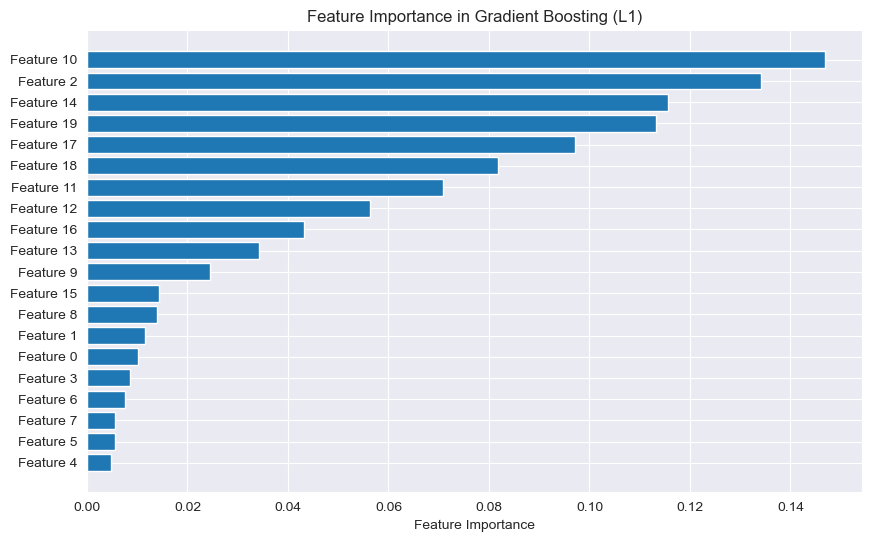

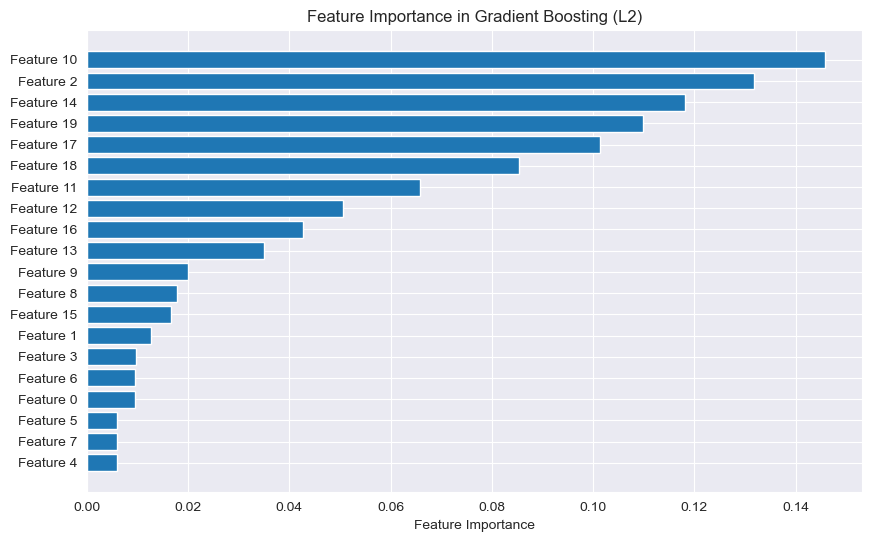

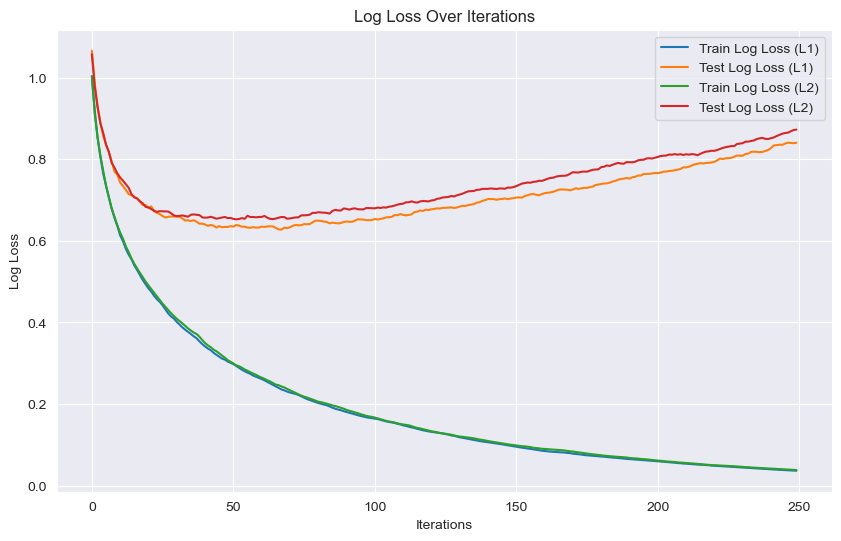

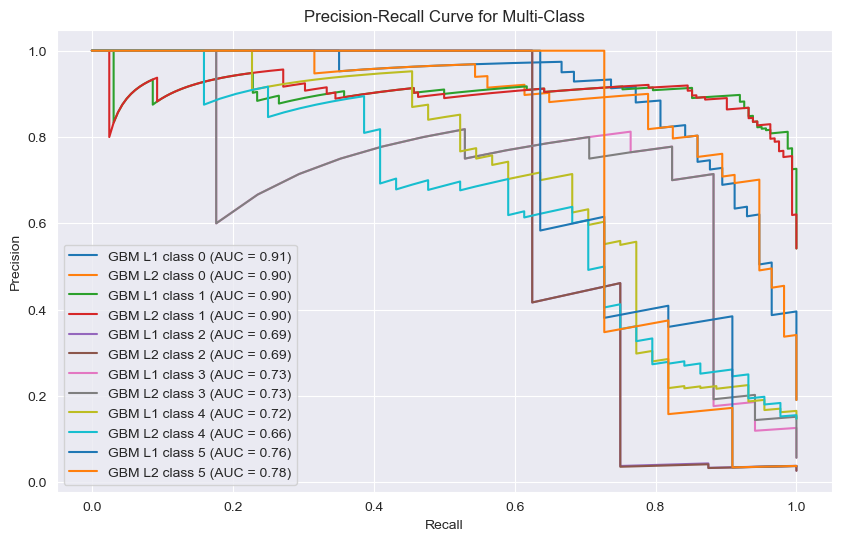

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, log_loss, accuracy_score
from sklearn.preprocessing import label_binarize
from matplotlib.colors import ListedColormap

# Fit the models with corrected loss parameter
gbm_l1 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3, random_state=42,
                                    loss='log_loss', min_samples_split=10)
gbm_l1.fit(X_train, y_train)
y_pred_gbm_l1 = gbm_l1.predict(X_test)
y_pred_proba_l1 = gbm_l1.predict_proba(X_test)

gbm_l2 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3, random_state=42,
                                    loss='log_loss', min_samples_split=10, min_samples_leaf=5)
gbm_l2.fit(X_train, y_train)
y_pred_gbm_l2 = gbm_l2.predict(X_test)
y_pred_proba_l2 = gbm_l2.predict_proba(X_test)

# Print model performance
gbm_l1_score_final = gbm_l1.score(X_test, y_test)
gbm_l2_score_final = gbm_l2.score(X_test, y_test)
print('Model performance:')
print(f'L1 Score: {gbm_l1.score(X_test, y_test)}')
print(f'L2 Score: {gbm_l2.score(X_test, y_test)}')

# Log Loss
logloss_l1 = log_loss(y_test, y_pred_proba_l1)
logloss_l2 = log_loss(y_test, y_pred_proba_l2)
print(f'Log Loss L1: {logloss_l1}')
print(f'Log Loss L2: {logloss_l2}')

# Precision, Recall, F1 Score for gbm_l1 (multi-class)
precision_l1 = precision_score(y_test, y_pred_gbm_l1, average='weighted')
recall_l1 = recall_score(y_test, y_pred_gbm_l1, average='weighted')
f1_l1 = f1_score(y_test, y_pred_gbm_l1, average='weighted')
print(f'Precision L1: {precision_l1}')
print(f'Recall L1: {recall_l1}')
print(f'F1 Score L1: {f1_l1}')

# Precision, Recall, F1 Score for gbm_l2 (multi-class)
precision_l2 = precision_score(y_test, y_pred_gbm_l2, average='weighted')
recall_l2 = recall_score(y_test, y_pred_gbm_l2, average='weighted')
f1_l2 = f1_score(y_test, y_pred_gbm_l2, average='weighted')
print(f'Precision L2: {precision_l2}')
print(f'Recall L2: {recall_l2}')
print(f'F1 Score L2: {f1_l2}')

numeric_label_accuracy = []
# Individual target variable accuracy (for each class)
print('\nIndividual Target Variable Accuracy:')
for class_label in np.unique(y_test):
    class_accuracy_l1 = accuracy_score(y_test == class_label, y_pred_gbm_l1 == class_label)
    numeric_label_accuracy.append(class_accuracy_l1)
    class_accuracy_l2 = accuracy_score(y_test == class_label, y_pred_gbm_l2 == class_label)
    print(f'Class {class_names[class_label]} - L1 Accuracy: {class_accuracy_l1:.4f}, L2 Accuracy: {class_accuracy_l2:.4f}')

# Feature importance for gbm_l1
feature_importance_l1 = gbm_l1.feature_importances_
sorted_idx_l1 = np.argsort(feature_importance_l1)

# Plot feature importance for gbm_l1
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_l1)), feature_importance_l1[sorted_idx_l1], align='center')
plt.yticks(range(len(sorted_idx_l1)), [f'Feature {i}' for i in sorted_idx_l1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting (L1)')
plt.show()

# Feature importance for gbm_l2
feature_importance_l2 = gbm_l2.feature_importances_
sorted_idx_l2 = np.argsort(feature_importance_l2)

# Plot feature importance for gbm_l2
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_l2)), feature_importance_l2[sorted_idx_l2], align='center')
plt.yticks(range(len(sorted_idx_l2)), [f'Feature {i}' for i in sorted_idx_l2])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting (L2)')
plt.show()

# Visualize the boosting process with log loss
train_log_loss_l1 = []
test_log_loss_l1 = []
train_log_loss_l2 = []
test_log_loss_l2 = []

for y_pred in gbm_l1.staged_predict_proba(X_train):
    train_log_loss_l1.append(log_loss(y_train, y_pred))
for y_pred in gbm_l1.staged_predict_proba(X_test):
    test_log_loss_l1.append(log_loss(y_test, y_pred))

for y_pred in gbm_l2.staged_predict_proba(X_train):
    train_log_loss_l2.append(log_loss(y_train, y_pred))
for y_pred in gbm_l2.staged_predict_proba(X_test):
    test_log_loss_l2.append(log_loss(y_test, y_pred))

# Plot log loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(train_log_loss_l1, label='Train Log Loss (L1)')
plt.plot(test_log_loss_l1, label='Test Log Loss (L1)')
plt.plot(train_log_loss_l2, label='Train Log Loss (L2)')
plt.plot(test_log_loss_l2, label='Test Log Loss (L2)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Log Loss Over Iterations')
plt.legend()
plt.show()

# Precision-Recall Curve for multi-class (One-vs-Rest approach)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
precision_l1_curve = {}
recall_l1_curve = {}
pr_auc_l1 = {}
precision_l2_curve = {}
recall_l2_curve = {}
pr_auc_l2 = {}

for i in range(y_test_binarized.shape[1]):
    precision_l1_curve[i], recall_l1_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_l1[:, i])
    pr_auc_l1[i] = auc(recall_l1_curve[i], precision_l1_curve[i])

    precision_l2_curve[i], recall_l2_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_l2[:, i])
    pr_auc_l2[i] = auc(recall_l2_curve[i], precision_l2_curve[i])

# Plot Precision-Recall Curve for multi-class
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    plt.plot(recall_l1_curve[i], precision_l1_curve[i], label=f'GBM L1 class {i} (AUC = {pr_auc_l1[i]:.2f})')
    plt.plot(recall_l2_curve[i], precision_l2_curve[i], label=f'GBM L2 class {i} (AUC = {pr_auc_l2[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class')
plt.legend(loc='best')
plt.show()


***L1 L2 on RF***

Random Forest Model Performance:
Model 1 Accuracy: 0.7425
Model 2 Accuracy: 0.7291
Log Loss RF1: 0.6967
Log Loss RF2: 0.7384
Precision RF1: 0.7869
Recall RF1: 0.7425
F1 Score RF1: 0.6859
Precision RF2: 0.7819
Recall RF2: 0.7291
F1 Score RF2: 0.6668

Individual Target Variable Accuracy:
Class 0 - RF1 Accuracy: 0.9130, RF2 Accuracy: 0.8997
Class 1 - RF1 Accuracy: 0.7759, RF2 Accuracy: 0.7726
Class 2 - RF1 Accuracy: 0.9766, RF2 Accuracy: 0.9799
Class 3 - RF1 Accuracy: 0.9732, RF2 Accuracy: 0.9666
Class 4 - RF1 Accuracy: 0.8595, RF2 Accuracy: 0.8562
Class 5 - RF1 Accuracy: 0.9866, RF2 Accuracy: 0.9833


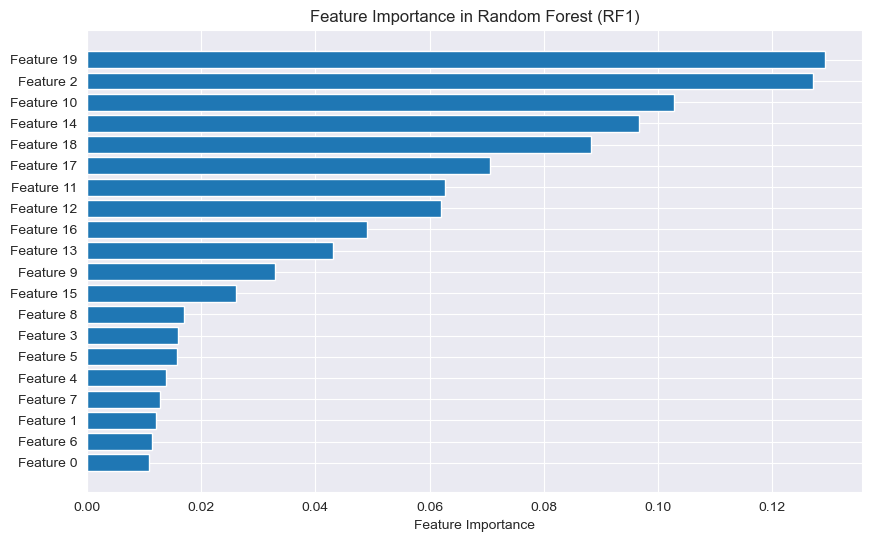

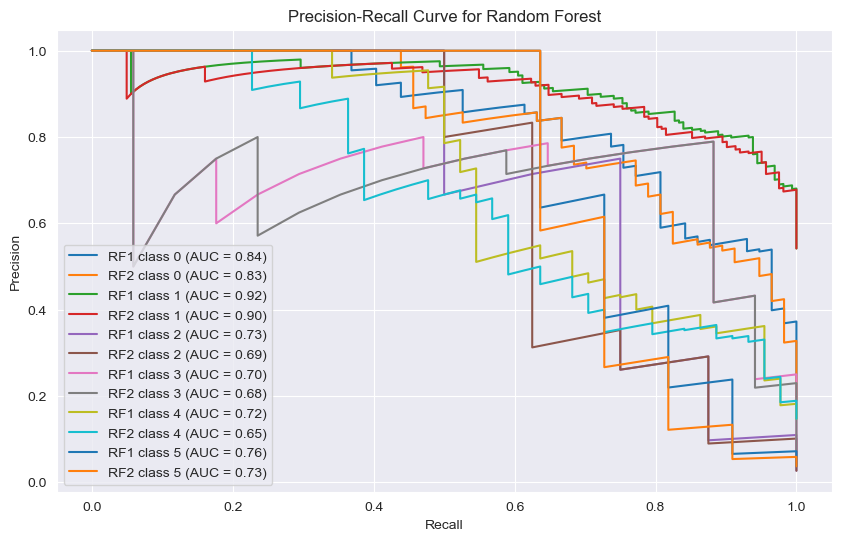

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             precision_recall_curve, auc, log_loss, accuracy_score)
from sklearn.preprocessing import label_binarize

# Initialize Random Forest classifiers with different parameters
rf_model_1 = RandomForestClassifier(n_estimators=250, max_depth=10, random_state=42,
                                    min_samples_split=10, n_jobs=-1)
rf_model_2 = RandomForestClassifier(n_estimators=250, max_depth=10, random_state=42,
                                    min_samples_split=10, min_samples_leaf=5, n_jobs=-1)

# Train the models
rf_model_1.fit(X_train, y_train)
rf_model_2.fit(X_train, y_train)

# Predictions
y_pred_rf1 = rf_model_1.predict(X_test)
y_pred_rf2 = rf_model_2.predict(X_test)
y_pred_proba_rf1 = rf_model_1.predict_proba(X_test)
y_pred_proba_rf2 = rf_model_2.predict_proba(X_test)

# Model performance
rf1_score = rf_model_1.score(X_test, y_test)
rf2_score = rf_model_2.score(X_test, y_test)
print('Random Forest Model Performance:')
print(f'Model 1 Accuracy: {rf1_score:.4f}')
print(f'Model 2 Accuracy: {rf2_score:.4f}')

# Log Loss
logloss_rf1 = log_loss(y_test, y_pred_proba_rf1)
logloss_rf2 = log_loss(y_test, y_pred_proba_rf2)
print(f'Log Loss RF1: {logloss_rf1:.4f}')
print(f'Log Loss RF2: {logloss_rf2:.4f}')

# Precision, Recall, F1 Score
precision_rf1 = precision_score(y_test, y_pred_rf1, average='weighted')
recall_rf1 = recall_score(y_test, y_pred_rf1, average='weighted')
f1_rf1 = f1_score(y_test, y_pred_rf1, average='weighted')

precision_rf2 = precision_score(y_test, y_pred_rf2, average='weighted')
recall_rf2 = recall_score(y_test, y_pred_rf2, average='weighted')
f1_rf2 = f1_score(y_test, y_pred_rf2, average='weighted')

print(f'Precision RF1: {precision_rf1:.4f}')
print(f'Recall RF1: {recall_rf1:.4f}')
print(f'F1 Score RF1: {f1_rf1:.4f}')
print(f'Precision RF2: {precision_rf2:.4f}')
print(f'Recall RF2: {recall_rf2:.4f}')
print(f'F1 Score RF2: {f1_rf2:.4f}')

# Individual Target Variable Accuracy
print('\nIndividual Target Variable Accuracy:')
for class_label in np.unique(y_test):
    class_accuracy_rf1 = accuracy_score(y_test == class_label, y_pred_rf1 == class_label)
    class_accuracy_rf2 = accuracy_score(y_test == class_label, y_pred_rf2 == class_label)
    print(f'Class {class_label} - RF1 Accuracy: {class_accuracy_rf1:.4f}, RF2 Accuracy: {class_accuracy_rf2:.4f}')

# Feature Importance
feature_importance_rf1 = rf_model_1.feature_importances_
sorted_idx_rf1 = np.argsort(feature_importance_rf1)

# Plot feature importance for RF1
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_rf1)), feature_importance_rf1[sorted_idx_rf1], align='center')
plt.yticks(range(len(sorted_idx_rf1)), [f'Feature {i}' for i in sorted_idx_rf1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest (RF1)')
plt.show()

# Precision-Recall Curve (One-vs-Rest for multi-class)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
precision_rf1_curve = {}
recall_rf1_curve = {}
pr_auc_rf1 = {}
precision_rf2_curve = {}
recall_rf2_curve = {}
pr_auc_rf2 = {}

for i in range(y_test_binarized.shape[1]):
    precision_rf1_curve[i], recall_rf1_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_rf1[:, i])
    pr_auc_rf1[i] = auc(recall_rf1_curve[i], precision_rf1_curve[i])

    precision_rf2_curve[i], recall_rf2_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_rf2[:, i])
    pr_auc_rf2[i] = auc(recall_rf2_curve[i], precision_rf2_curve[i])

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    plt.plot(recall_rf1_curve[i], precision_rf1_curve[i], label=f'RF1 class {i} (AUC = {pr_auc_rf1[i]:.2f})')
    plt.plot(recall_rf2_curve[i], precision_rf2_curve[i], label=f'RF2 class {i} (AUC = {pr_auc_rf2[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend(loc='best')
plt.show()


### step 1.2 selective features with all row without any missing value

In [109]:
from sklearn.feature_selection import SelectKBest,f_classif
import pandas as pd

FIT_FEATURES = SelectKBest(score_func=f_classif)
FIT_FEATURES.fit(X,y)
SCORE_COL = pd.DataFrame(FIT_FEATURES.scores_,columns = ['score value'])
NAME_COL = pd.DataFrame(X.columns)
TOP_FEATURES = pd.concat([NAME_COL,SCORE_COL],axis = 1)
print(TOP_FEATURES)

                      0  score value
0                 smoke     5.979897
1                 drink     0.904785
2                   age    61.111424
3             pesticide     6.397634
4                gender     2.453448
5   skin_cancer_history     2.070847
6        cancer_history     0.439105
7       has_piped_water     2.510336
8     has_sewage_system     2.708834
9           fitspatrick     8.959072
10               region     3.968306
11           diameter_1     3.070581
12           diameter_2     5.194234
13                 itch    61.205331
14                 grew    72.148072
15                 hurt    21.665047
16              changed    40.859071
17                bleed    54.807053
18            elevation    63.662387
19              biopsed   162.803147


In [110]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Assuming X is a DataFrame and y is the target

# Initialize SelectKBest with f_classif
selector = SelectKBest(score_func=f_classif)

# Fit SelectKBest to your data
selector.fit(X, y)

# Get the scores of all features
scores = selector.scores_

# Create a DataFrame for feature names and scores
features_scores = pd.DataFrame({
    'feature_name': X.columns,
    'score_value': scores
})

# Sort features by their scores in descending order
features_scores_sorted = features_scores.sort_values(by='score_value', ascending=False)

# Print all features with their scores
#print("All features sorted by scores:")
#print(features_scores_sorted)

# Select the top 15 features
TOP_FEATURES = features_scores_sorted.head(9)

# Print the top 15 features with their scores
print("\nTop 13 features with their scores:")
print(TOP_FEATURES)



Top 13 features with their scores:
   feature_name  score_value
19      biopsed   162.803147
14         grew    72.148072
18    elevation    63.662387
13         itch    61.205331
2           age    61.111424
17        bleed    54.807053
16      changed    40.859071
15         hurt    21.665047
9   fitspatrick     8.959072


In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Extract the top 16 features
selected_features = TOP_FEATURES['feature_name'].tolist()

# Subset the original dataset with only the selected features
X_selected = X[selected_features]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit StandardScaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now you can use X_train_scaled, X_test_scaled, y_train, y_test for further modeling


In [112]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, log_loss, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import numpy as np



# Traditional classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

print("Traditional Classifiers:")
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    score = clf.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    ll = log_loss(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    # Calculate RMSE based on predicted probabilities
    y_pred_proba_max = np.max(y_pred_proba, axis=1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba_max))

    print(f"\n{name}:")
    print(f"Accuracy: {score:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")
    print(f"Log Loss: {ll:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Helper class for hybrid models
class BoostingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, boosting_model):
        self.base_classifier = base_classifier
        self.boosting_model = boosting_model

    def fit(self, X, y):
        # Fit the base classifier
        self.base_classifier.fit(X, y)
        # Use the predictions of the base classifier as new features
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Fit the boosting model on the new features
        self.boosting_model.fit(base_predictions, y)
        return self

    def predict(self, X):
        # Use the base classifier to make predictions
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Use the boosting model to make final predictions
        return self.boosting_model.predict(base_predictions)

    def predict_proba(self, X):
        # Use the base classifier to make predictions
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Use the boosting model to make probability estimates
        return self.boosting_model.predict_proba(base_predictions)

# Define hybrid models
boosting_model = GradientBoostingClassifier()

hybrid_classifiers = {
    'DTBM': BoostingModel(DecisionTreeClassifier(), boosting_model),
    'RFBM': BoostingModel(RandomForestClassifier(), boosting_model),
    'KNNBM': BoostingModel(KNeighborsClassifier(), boosting_model),
    'GBBM': BoostingModel(GradientBoostingClassifier(), boosting_model),
    'ABBM': BoostingModel(AdaBoostClassifier(), boosting_model)
}

print("\nHybrid Models:")
for name, clf in hybrid_classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    score = clf.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    ll = log_loss(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    # Calculate RMSE based on predicted probabilities
    y_pred_proba_max = np.max(y_pred_proba, axis=1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba_max))

    print(f"\n{name}:")
    print(f"Accuracy: {score:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")
    print(f"Log Loss: {ll:.2f}")
    print(f"RMSE: {rmse:.2f}")


Traditional Classifiers:

Decision Tree:
Accuracy: 0.73
Confusion Matrix:
[[ 45   8   0   2   0   2]
 [ 13 132   1   1  13   2]
 [  0   0   5   2   1   0]
 [  0   3   0  13   1   0]
 [ 10  14   2   0  18   0]
 [  3   1   0   2   0   5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70        57
           1       0.84      0.81      0.82       162
           2       0.62      0.62      0.62         8
           3       0.65      0.76      0.70        17
           4       0.55      0.41      0.47        44
           5       0.56      0.45      0.50        11

    accuracy                           0.73       299
   macro avg       0.64      0.64      0.64       299
weighted avg       0.73      0.73      0.72       299

Log Loss: 7.78
RMSE: 1.57

Random Forest:
Accuracy: 0.75
Confusion Matrix:
[[ 44   9   0   2   0   2]
 [  9 140   1   1  11   0]
 [  0   0   5   2   1   0]
 [  0   3   0  13   1   0]
 [  9  18   1 

**L1 L2 optimization**

Model performance:
L1 Score: 0.7157190635451505
L2 Score: 0.7123745819397993
Log Loss L1: 1.045436138698612
Log Loss L2: 1.0188833795551016
Precision L1: 0.7061263828527256
Recall L1: 0.7157190635451505
F1 Score L1: 0.7062204307055565
Precision L2: 0.6973269127514864
Recall L2: 0.7123745819397993
F1 Score L2: 0.700015630515794

Individual Target Variable Accuracy:
Class ACK - L1 Accuracy: 0.8729, L2 Accuracy: 0.8829
Class BCC - L1 Accuracy: 0.7926, L2 Accuracy: 0.7893
Class MEL - L1 Accuracy: 0.9699, L2 Accuracy: 0.9699
Class NEV - L1 Accuracy: 0.9632, L2 Accuracy: 0.9632
Class SCC - L1 Accuracy: 0.8662, L2 Accuracy: 0.8462
Class SEK - L1 Accuracy: 0.9666, L2 Accuracy: 0.9732


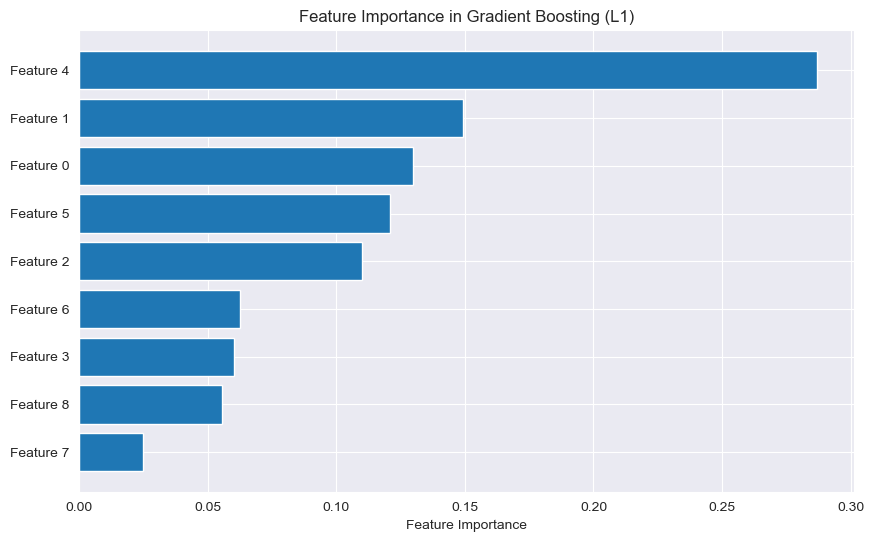

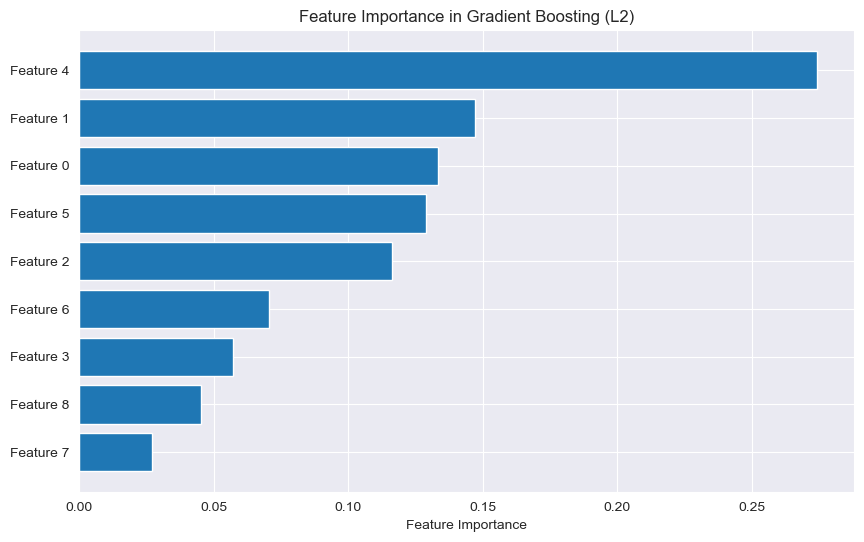

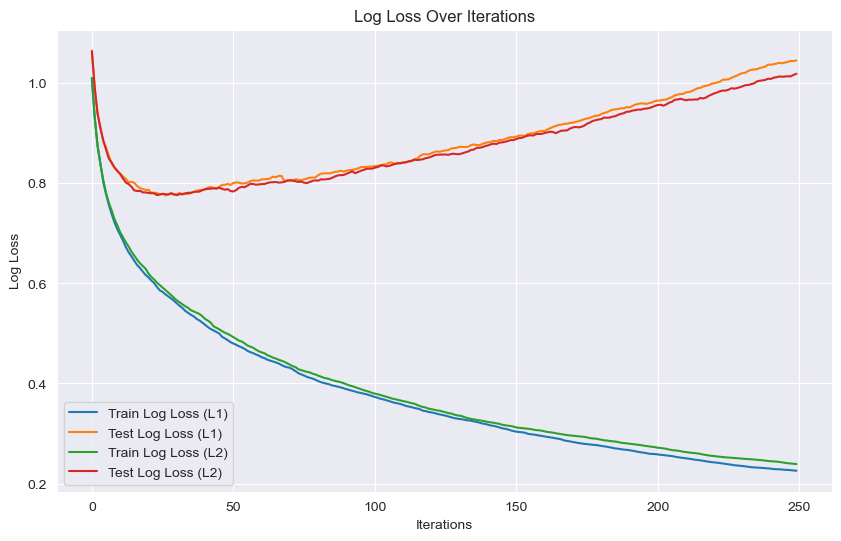

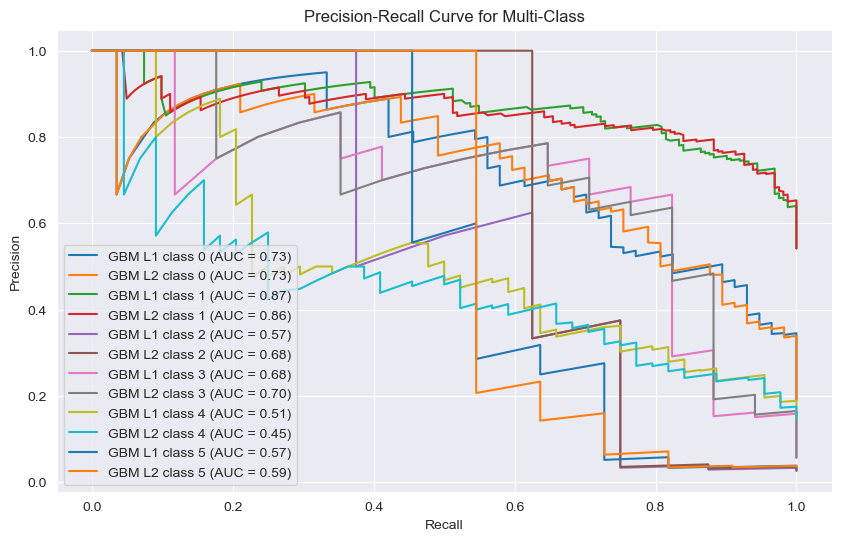

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, log_loss, accuracy_score
from sklearn.preprocessing import label_binarize
from matplotlib.colors import ListedColormap

# Fit the models with corrected loss parameter
gbm_l1 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3, random_state=42,
                                    loss='log_loss', min_samples_split=10)
gbm_l1.fit(X_train, y_train)
y_pred_gbm_l1 = gbm_l1.predict(X_test)
y_pred_proba_l1 = gbm_l1.predict_proba(X_test)

gbm_l2 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3, random_state=42,
                                    loss='log_loss', min_samples_split=10, min_samples_leaf=5)
gbm_l2.fit(X_train, y_train)
y_pred_gbm_l2 = gbm_l2.predict(X_test)
y_pred_proba_l2 = gbm_l2.predict_proba(X_test)

# Print model performance
gbm_l1_score_final = gbm_l1.score(X_test, y_test)
gbm_l2_score_final = gbm_l2.score(X_test, y_test)
print('Model performance:')
print(f'L1 Score: {gbm_l1.score(X_test, y_test)}')
print(f'L2 Score: {gbm_l2.score(X_test, y_test)}')

# Log Loss
logloss_l1 = log_loss(y_test, y_pred_proba_l1)
logloss_l2 = log_loss(y_test, y_pred_proba_l2)
print(f'Log Loss L1: {logloss_l1}')
print(f'Log Loss L2: {logloss_l2}')

# Precision, Recall, F1 Score for gbm_l1 (multi-class)
precision_l1 = precision_score(y_test, y_pred_gbm_l1, average='weighted')
recall_l1 = recall_score(y_test, y_pred_gbm_l1, average='weighted')
f1_l1 = f1_score(y_test, y_pred_gbm_l1, average='weighted')
print(f'Precision L1: {precision_l1}')
print(f'Recall L1: {recall_l1}')
print(f'F1 Score L1: {f1_l1}')

# Precision, Recall, F1 Score for gbm_l2 (multi-class)
precision_l2 = precision_score(y_test, y_pred_gbm_l2, average='weighted')
recall_l2 = recall_score(y_test, y_pred_gbm_l2, average='weighted')
f1_l2 = f1_score(y_test, y_pred_gbm_l2, average='weighted')
print(f'Precision L2: {precision_l2}')
print(f'Recall L2: {recall_l2}')
print(f'F1 Score L2: {f1_l2}')

numeric_label_accuracy = []
# Individual target variable accuracy (for each class)
print('\nIndividual Target Variable Accuracy:')
for class_label in np.unique(y_test):
    class_accuracy_l1 = accuracy_score(y_test == class_label, y_pred_gbm_l1 == class_label)
    numeric_label_accuracy.append(class_accuracy_l1)
    class_accuracy_l2 = accuracy_score(y_test == class_label, y_pred_gbm_l2 == class_label)
    print(f'Class {class_names[class_label]} - L1 Accuracy: {class_accuracy_l1:.4f}, L2 Accuracy: {class_accuracy_l2:.4f}')

# Feature importance for gbm_l1
feature_importance_l1 = gbm_l1.feature_importances_
sorted_idx_l1 = np.argsort(feature_importance_l1)

# Plot feature importance for gbm_l1
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_l1)), feature_importance_l1[sorted_idx_l1], align='center')
plt.yticks(range(len(sorted_idx_l1)), [f'Feature {i}' for i in sorted_idx_l1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting (L1)')
plt.show()

# Feature importance for gbm_l2
feature_importance_l2 = gbm_l2.feature_importances_
sorted_idx_l2 = np.argsort(feature_importance_l2)

# Plot feature importance for gbm_l2
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_l2)), feature_importance_l2[sorted_idx_l2], align='center')
plt.yticks(range(len(sorted_idx_l2)), [f'Feature {i}' for i in sorted_idx_l2])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting (L2)')
plt.show()

# Visualize the boosting process with log loss
train_log_loss_l1 = []
test_log_loss_l1 = []
train_log_loss_l2 = []
test_log_loss_l2 = []

for y_pred in gbm_l1.staged_predict_proba(X_train):
    train_log_loss_l1.append(log_loss(y_train, y_pred))
for y_pred in gbm_l1.staged_predict_proba(X_test):
    test_log_loss_l1.append(log_loss(y_test, y_pred))

for y_pred in gbm_l2.staged_predict_proba(X_train):
    train_log_loss_l2.append(log_loss(y_train, y_pred))
for y_pred in gbm_l2.staged_predict_proba(X_test):
    test_log_loss_l2.append(log_loss(y_test, y_pred))

# Plot log loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(train_log_loss_l1, label='Train Log Loss (L1)')
plt.plot(test_log_loss_l1, label='Test Log Loss (L1)')
plt.plot(train_log_loss_l2, label='Train Log Loss (L2)')
plt.plot(test_log_loss_l2, label='Test Log Loss (L2)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Log Loss Over Iterations')
plt.legend()
plt.show()

# Precision-Recall Curve for multi-class (One-vs-Rest approach)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
precision_l1_curve = {}
recall_l1_curve = {}
pr_auc_l1 = {}
precision_l2_curve = {}
recall_l2_curve = {}
pr_auc_l2 = {}

for i in range(y_test_binarized.shape[1]):
    precision_l1_curve[i], recall_l1_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_l1[:, i])
    pr_auc_l1[i] = auc(recall_l1_curve[i], precision_l1_curve[i])

    precision_l2_curve[i], recall_l2_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_l2[:, i])
    pr_auc_l2[i] = auc(recall_l2_curve[i], precision_l2_curve[i])

# Plot Precision-Recall Curve for multi-class
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    plt.plot(recall_l1_curve[i], precision_l1_curve[i], label=f'GBM L1 class {i} (AUC = {pr_auc_l1[i]:.2f})')
    plt.plot(recall_l2_curve[i], precision_l2_curve[i], label=f'GBM L2 class {i} (AUC = {pr_auc_l2[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class')
plt.legend(loc='best')
plt.show()


## Step-2 ML on Unique value

In [114]:
target_variable = df_unique['diagnostic']

In [115]:
# Extract features (X) and target variable (y)
X = df_unique.iloc[:, 1:]  # Select all rows and columns from index 1 onward
X = X.drop(['diagnostic','img_id'], axis=1)  # Drop the 'diagnostic' column from features
y = df_unique['diagnostic']  # Target variable

# Print column names for X and y
print(f"X column list: {X.columns}")
print(f"y column name: {y.name}")


X column list: Index(['smoke', 'drink', 'age', 'pesticide', 'gender', 'skin_cancer_history',
       'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick',
       'region', 'diameter_1', 'diameter_2', 'itch', 'grew', 'hurt', 'changed',
       'bleed', 'elevation', 'biopsed'],
      dtype='object')
y column name: diagnostic


In [116]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to multiple columns in X
columns_to_encode = ['smoke', 'drink', 'pesticide', 'gender', 'skin_cancer_history',
                     'cancer_history', 'has_piped_water', 'has_sewage_system', 'region',
                     'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation']

X[columns_to_encode] = X[columns_to_encode].apply(label_encoder.fit_transform)

# Apply LabelEncoder to the 'diagnostic' column in y
le = LabelEncoder()
y = le.fit_transform(y)
# Check the transformed data
print(X)


      smoke  drink  age  pesticide  gender  skin_cancer_history  \
1637      1      0   69          0       1                    0   
2203      0      0   14          0       1                    0   
451       1      1   59          0       1                    0   
2182      0      0   79          1       0                    1   
24        0      0   71          0       0                    1   
...     ...    ...  ...        ...     ...                  ...   
1806      0      0   77          1       1                    0   
2035      0      0   51          1       1                    0   
1121      1      0   82          0       1                    0   
870       0      0   52          1       0                    1   
529       0      0   49          0       0                    0   

      cancer_history  has_piped_water  has_sewage_system  fitspatrick  region  \
1637               0                1                  0          1.0       1   
2203               1             

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size = .2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(635, 20) (159, 20) (635,) (159,)


In [118]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [119]:
X_train

array([[-0.38237336, -0.580381  , -0.0323581 , ...,  1.24572564,
        -1.70173628,  0.27617239],
       [-0.38237336, -0.580381  ,  1.21293866, ..., -0.76197939,
        -1.70173628, -3.62092683],
       [ 2.61524495, -0.580381  , -0.86255595, ..., -0.76197939,
         0.57801591, -3.62092683],
       ...,
       [-0.38237336,  1.72300609, -0.0323581 , ..., -0.76197939,
         0.57801591,  0.27617239],
       [ 2.61524495, -0.580381  ,  1.42048812, ..., -0.76197939,
         0.57801591,  0.27617239],
       [-0.38237336, -0.580381  ,  1.55885442, ...,  1.24572564,
        -1.70173628,  0.27617239]])

In [120]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, log_loss, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import numpy as np



# Traditional classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

print("Traditional Classifiers:")
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    score = clf.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    ll = log_loss(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    # Calculate RMSE based on predicted probabilities
    y_pred_proba_max = np.max(y_pred_proba, axis=1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba_max))

    print(f"\n{name}:")
    print(f"Accuracy: {score:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")
    print(f"Log Loss: {ll:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Helper class for hybrid models
class BoostingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, boosting_model):
        self.base_classifier = base_classifier
        self.boosting_model = boosting_model

    def fit(self, X, y):
        # Fit the base classifier
        self.base_classifier.fit(X, y)
        # Use the predictions of the base classifier as new features
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Fit the boosting model on the new features
        self.boosting_model.fit(base_predictions, y)
        return self

    def predict(self, X):
        # Use the base classifier to make predictions
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Use the boosting model to make final predictions
        return self.boosting_model.predict(base_predictions)

    def predict_proba(self, X):
        # Use the base classifier to make predictions
        base_predictions = self.base_classifier.predict(X).reshape(-1, 1)
        # Use the boosting model to make probability estimates
        return self.boosting_model.predict_proba(base_predictions)

# Define hybrid models
boosting_model = GradientBoostingClassifier()

hybrid_classifiers = {
    'DTBM': BoostingModel(DecisionTreeClassifier(), boosting_model),
    'RFBM': BoostingModel(RandomForestClassifier(), boosting_model),
    'KNNBM': BoostingModel(KNeighborsClassifier(), boosting_model),
    'GBBM': BoostingModel(GradientBoostingClassifier(), boosting_model),
    'ABBM': BoostingModel(AdaBoostClassifier(), boosting_model)
}

print("\nHybrid Models:")
for name, clf in hybrid_classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    score = clf.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    ll = log_loss(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    # Calculate RMSE based on predicted probabilities
    y_pred_proba_max = np.max(y_pred_proba, axis=1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba_max))

    print(f"\n{name}:")
    print(f"Accuracy: {score:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")
    print(f"Log Loss: {ll:.2f}")
    print(f"RMSE: {rmse:.2f}")


Traditional Classifiers:

Decision Tree:
Accuracy: 0.51
Confusion Matrix:
[[11  6  0  1  5  2]
 [13 56  3  2 11  3]
 [ 0  3  3  2  1  0]
 [ 1  4  2  4  1  0]
 [ 1 11  2  1  6  0]
 [ 1  1  0  1  0  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.44      0.42        25
           1       0.69      0.64      0.66        88
           2       0.30      0.33      0.32         9
           3       0.36      0.33      0.35        12
           4       0.25      0.29      0.27        21
           5       0.17      0.25      0.20         4

    accuracy                           0.51       159
   macro avg       0.36      0.38      0.37       159
weighted avg       0.53      0.51      0.52       159

Log Loss: 17.68
RMSE: 1.45

Random Forest:
Accuracy: 0.70
Confusion Matrix:
[[17  8  0  0  0  0]
 [ 5 83  0  0  0  0]
 [ 0  5  4  0  0  0]
 [ 1  4  0  7  0  0]
 [ 1 19  0  1  0  0]
 [ 1  1  0  1  0  1]]
Classification Report:
       

**L1 L2 Optimization**

Model performance:
L1 Score: 0.6792452830188679
L2 Score: 0.6729559748427673
Log Loss L1: 2.1275395013935308
Log Loss L2: 2.069206748036397
Precision L1: 0.6679254695019796
Recall L1: 0.6792452830188679
F1 Score L1: 0.6645581339474089
Precision L2: 0.6439179257331502
Recall L2: 0.6729559748427673
F1 Score L2: 0.6508565741270145

Individual Target Variable Accuracy:
Class ACK - L1 Accuracy: 0.8742, L2 Accuracy: 0.8742
Class BCC - L1 Accuracy: 0.7673, L2 Accuracy: 0.7547
Class MEL - L1 Accuracy: 0.9623, L2 Accuracy: 0.9686
Class NEV - L1 Accuracy: 0.9434, L2 Accuracy: 0.9371
Class SCC - L1 Accuracy: 0.8553, L2 Accuracy: 0.8491
Class SEK - L1 Accuracy: 0.9560, L2 Accuracy: 0.9623


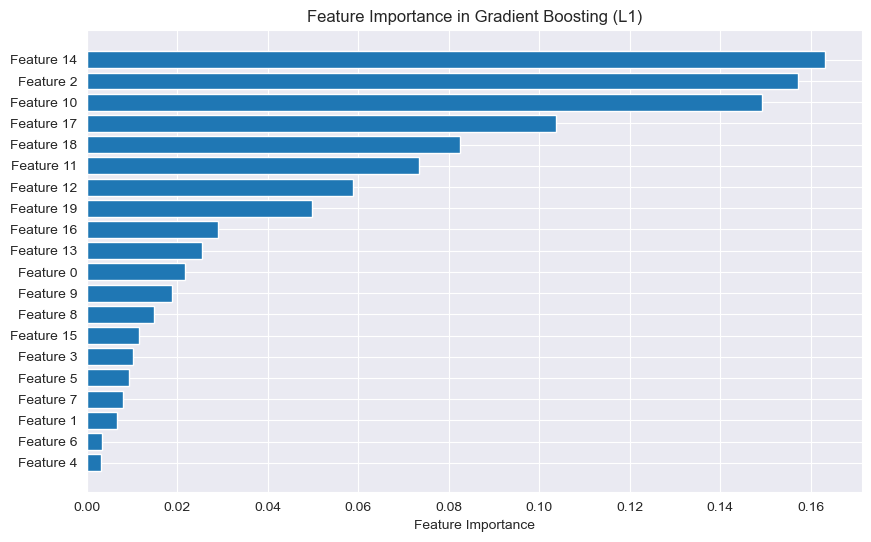

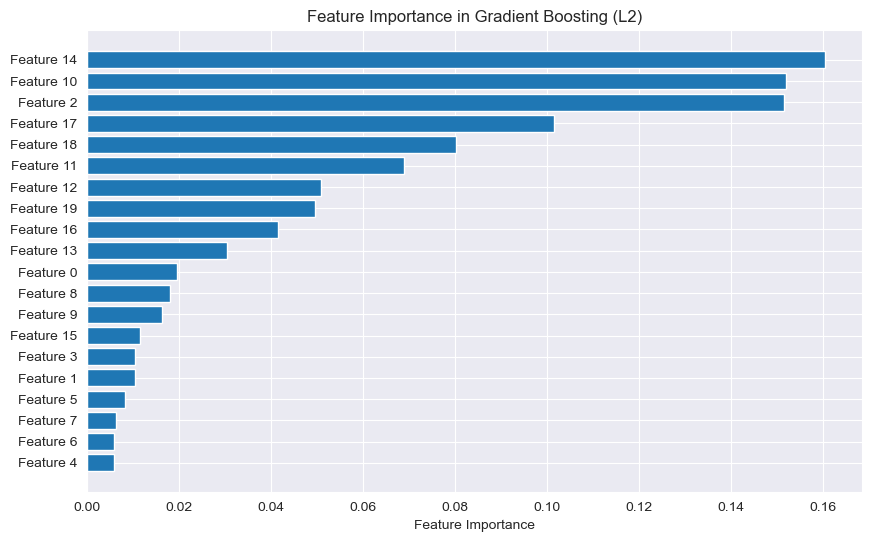

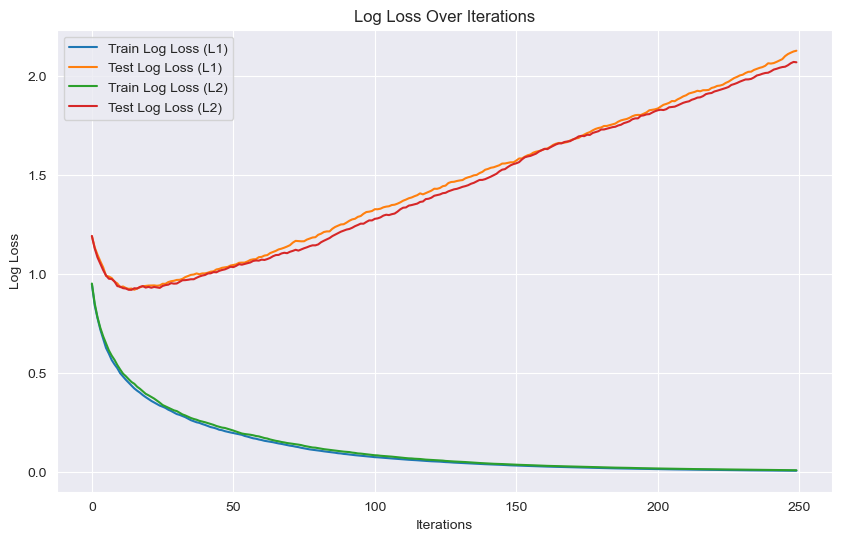

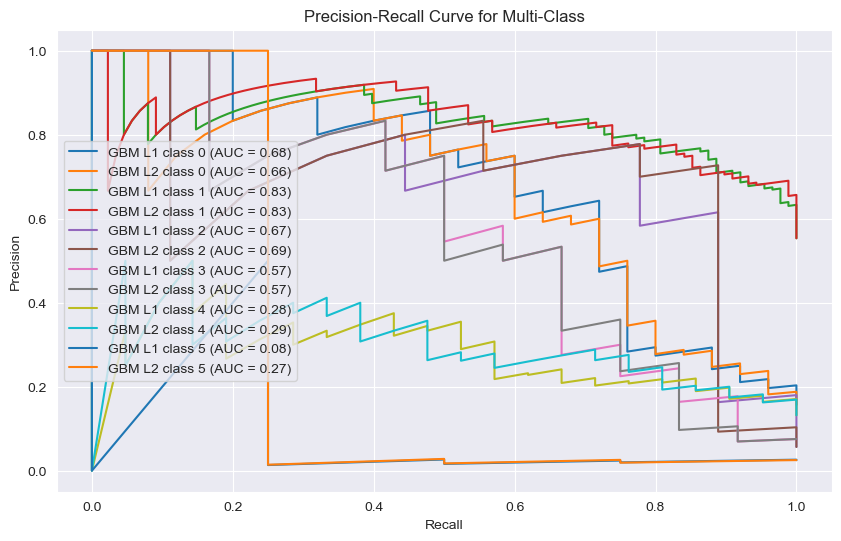

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, log_loss, accuracy_score
from sklearn.preprocessing import label_binarize
from matplotlib.colors import ListedColormap

# Fit the models with corrected loss parameter
gbm_l1 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3, random_state=42,
                                    loss='log_loss', min_samples_split=10)
gbm_l1.fit(X_train, y_train)
y_pred_gbm_l1 = gbm_l1.predict(X_test)
y_pred_proba_l1 = gbm_l1.predict_proba(X_test)

gbm_l2 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3, random_state=42,
                                    loss='log_loss', min_samples_split=10, min_samples_leaf=5)
gbm_l2.fit(X_train, y_train)
y_pred_gbm_l2 = gbm_l2.predict(X_test)
y_pred_proba_l2 = gbm_l2.predict_proba(X_test)

# Print model performance
gbm_l1_score_final = gbm_l1.score(X_test, y_test)
gbm_l2_score_final = gbm_l2.score(X_test, y_test)
print('Model performance:')
print(f'L1 Score: {gbm_l1.score(X_test, y_test)}')
print(f'L2 Score: {gbm_l2.score(X_test, y_test)}')

# Log Loss
logloss_l1 = log_loss(y_test, y_pred_proba_l1)
logloss_l2 = log_loss(y_test, y_pred_proba_l2)
print(f'Log Loss L1: {logloss_l1}')
print(f'Log Loss L2: {logloss_l2}')

# Precision, Recall, F1 Score for gbm_l1 (multi-class)
precision_l1 = precision_score(y_test, y_pred_gbm_l1, average='weighted')
recall_l1 = recall_score(y_test, y_pred_gbm_l1, average='weighted')
f1_l1 = f1_score(y_test, y_pred_gbm_l1, average='weighted')
print(f'Precision L1: {precision_l1}')
print(f'Recall L1: {recall_l1}')
print(f'F1 Score L1: {f1_l1}')

# Precision, Recall, F1 Score for gbm_l2 (multi-class)
precision_l2 = precision_score(y_test, y_pred_gbm_l2, average='weighted')
recall_l2 = recall_score(y_test, y_pred_gbm_l2, average='weighted')
f1_l2 = f1_score(y_test, y_pred_gbm_l2, average='weighted')
print(f'Precision L2: {precision_l2}')
print(f'Recall L2: {recall_l2}')
print(f'F1 Score L2: {f1_l2}')

numeric_label_accuracy = []
# Individual target variable accuracy (for each class)
print('\nIndividual Target Variable Accuracy:')
for class_label in np.unique(y_test):
    class_accuracy_l1 = accuracy_score(y_test == class_label, y_pred_gbm_l1 == class_label)
    numeric_label_accuracy.append(class_accuracy_l1)
    class_accuracy_l2 = accuracy_score(y_test == class_label, y_pred_gbm_l2 == class_label)
    print(f'Class {class_names[class_label]} - L1 Accuracy: {class_accuracy_l1:.4f}, L2 Accuracy: {class_accuracy_l2:.4f}')

# Feature importance for gbm_l1
feature_importance_l1 = gbm_l1.feature_importances_
sorted_idx_l1 = np.argsort(feature_importance_l1)

# Plot feature importance for gbm_l1
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_l1)), feature_importance_l1[sorted_idx_l1], align='center')
plt.yticks(range(len(sorted_idx_l1)), [f'Feature {i}' for i in sorted_idx_l1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting (L1)')
plt.show()

# Feature importance for gbm_l2
feature_importance_l2 = gbm_l2.feature_importances_
sorted_idx_l2 = np.argsort(feature_importance_l2)

# Plot feature importance for gbm_l2
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_l2)), feature_importance_l2[sorted_idx_l2], align='center')
plt.yticks(range(len(sorted_idx_l2)), [f'Feature {i}' for i in sorted_idx_l2])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting (L2)')
plt.show()

# Visualize the boosting process with log loss
train_log_loss_l1 = []
test_log_loss_l1 = []
train_log_loss_l2 = []
test_log_loss_l2 = []

for y_pred in gbm_l1.staged_predict_proba(X_train):
    train_log_loss_l1.append(log_loss(y_train, y_pred))
for y_pred in gbm_l1.staged_predict_proba(X_test):
    test_log_loss_l1.append(log_loss(y_test, y_pred))

for y_pred in gbm_l2.staged_predict_proba(X_train):
    train_log_loss_l2.append(log_loss(y_train, y_pred))
for y_pred in gbm_l2.staged_predict_proba(X_test):
    test_log_loss_l2.append(log_loss(y_test, y_pred))

# Plot log loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(train_log_loss_l1, label='Train Log Loss (L1)')
plt.plot(test_log_loss_l1, label='Test Log Loss (L1)')
plt.plot(train_log_loss_l2, label='Train Log Loss (L2)')
plt.plot(test_log_loss_l2, label='Test Log Loss (L2)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Log Loss Over Iterations')
plt.legend()
plt.show()

# Precision-Recall Curve for multi-class (One-vs-Rest approach)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
precision_l1_curve = {}
recall_l1_curve = {}
pr_auc_l1 = {}
precision_l2_curve = {}
recall_l2_curve = {}
pr_auc_l2 = {}

for i in range(y_test_binarized.shape[1]):
    precision_l1_curve[i], recall_l1_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_l1[:, i])
    pr_auc_l1[i] = auc(recall_l1_curve[i], precision_l1_curve[i])

    precision_l2_curve[i], recall_l2_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_l2[:, i])
    pr_auc_l2[i] = auc(recall_l2_curve[i], precision_l2_curve[i])

# Plot Precision-Recall Curve for multi-class
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    plt.plot(recall_l1_curve[i], precision_l1_curve[i], label=f'GBM L1 class {i} (AUC = {pr_auc_l1[i]:.2f})')
    plt.plot(recall_l2_curve[i], precision_l2_curve[i], label=f'GBM L2 class {i} (AUC = {pr_auc_l2[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class')
plt.legend(loc='best')
plt.show()


## Step 3 , Ml on selective feature with unique value

In [122]:
from sklearn.feature_selection import SelectKBest,f_classif
import pandas as pd

FIT_FEATURES = SelectKBest(score_func=f_classif)
FIT_FEATURES.fit(X,y)
SCORE_COL = pd.DataFrame(FIT_FEATURES.scores_,columns = ['score value'])
NAME_COL = pd.DataFrame(X.columns)
TOP_FEATURES = pd.concat([NAME_COL,SCORE_COL],axis = 1)
print(TOP_FEATURES)

                      0  score value
0                 smoke     3.475312
1                 drink     0.477924
2                   age    32.780701
3             pesticide     2.546585
4                gender     1.561398
5   skin_cancer_history     1.279653
6        cancer_history     0.519565
7       has_piped_water     0.334796
8     has_sewage_system     1.189399
9           fitspatrick     5.878425
10               region     2.767857
11           diameter_1     3.524870
12           diameter_2     4.665542
13                 itch    31.817157
14                 grew    51.850582
15                 hurt    10.846785
16              changed    25.352769
17                bleed    28.493840
18            elevation    41.055213
19              biopsed    54.854459


In [123]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Assuming X is a DataFrame and y is the target

# Initialize SelectKBest with f_classif
selector = SelectKBest(score_func=f_classif)

# Fit SelectKBest to your data
selector.fit(X, y)

# Get the scores of all features
scores = selector.scores_

# Create a DataFrame for feature names and scores
features_scores = pd.DataFrame({
    'feature_name': X.columns,
    'score_value': scores
})

# Sort features by their scores in descending order
features_scores_sorted = features_scores.sort_values(by='score_value', ascending=False)

# Print all features with their scores
#print("All features sorted by scores:")
#print(features_scores_sorted)

# Select the top 15 features
TOP_FEATURES = features_scores_sorted.head(9)

# Print the top 15 features with their scores
print("\nTop 13 features with their scores:")
print(TOP_FEATURES)



Top 13 features with their scores:
   feature_name  score_value
19      biopsed    54.854459
14         grew    51.850582
18    elevation    41.055213
2           age    32.780701
13         itch    31.817157
17        bleed    28.493840
16      changed    25.352769
15         hurt    10.846785
9   fitspatrick     5.878425


In [124]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Extract the top 16 features
selected_features = TOP_FEATURES['feature_name'].tolist()

# Subset the original dataset with only the selected features
X_selected = X[selected_features]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit StandardScaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now you can use X_train_scaled, X_test_scaled, y_train, y_test for further modeling


In [125]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss

# Dictionary to store models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),  # SVM with probability estimates for log loss
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Dictionary to store model performance
model_performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

    # Store performance
    model_performance[model_name] = {
        "Accuracy": accuracy,
        "Log Loss": log_loss_value
    }

    # Print metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Log Loss: {log_loss_value}")
    print(classification_report(y_test, y_pred))
    print("-" * 40)

# Display overall performance
print("Summary of Model Performance:")
for model_name, metrics in model_performance.items():
    print(f"{model_name} - Accuracy: {metrics['Accuracy']:.2f}, Log Loss: {metrics['Log Loss']}")


Model: Logistic Regression
Accuracy: 0.6855345911949685
Log Loss: 0.9209989999813809
              precision    recall  f1-score   support

           0       0.73      0.76      0.75        25
           1       0.69      0.92      0.79        88
           2       1.00      0.11      0.20         9
           3       0.50      0.58      0.54        12
           4       0.00      0.00      0.00        21
           5       1.00      0.25      0.40         4

    accuracy                           0.69       159
   macro avg       0.65      0.44      0.45       159
weighted avg       0.62      0.69      0.62       159

----------------------------------------
Model: Decision Tree
Accuracy: 0.5974842767295597
Log Loss: 13.85858419496897
              precision    recall  f1-score   support

           0       0.59      0.80      0.68        25
           1       0.71      0.72      0.71        88
           2       0.33      0.33      0.33         9
           3       0.50      0.42   

**L1 l2 optimization**

Model performance:
L1 Score: 0.6415094339622641
L2 Score: 0.6540880503144654
Log Loss L1: 2.0472903357171695
Log Loss L2: 1.737264815633713
Precision L1: 0.6133814613059896
Recall L1: 0.6415094339622641
F1 Score L1: 0.6204834305569602
Precision L2: 0.624361681451164
Recall L2: 0.6540880503144654
F1 Score L2: 0.6268475929735379

Individual Target Variable Accuracy:
Class ACK - L1 Accuracy: 0.8931, L2 Accuracy: 0.9057
Class BCC - L1 Accuracy: 0.7107, L2 Accuracy: 0.7044
Class MEL - L1 Accuracy: 0.9623, L2 Accuracy: 0.9560
Class NEV - L1 Accuracy: 0.9308, L2 Accuracy: 0.9308
Class SCC - L1 Accuracy: 0.8113, L2 Accuracy: 0.8302
Class SEK - L1 Accuracy: 0.9748, L2 Accuracy: 0.9811


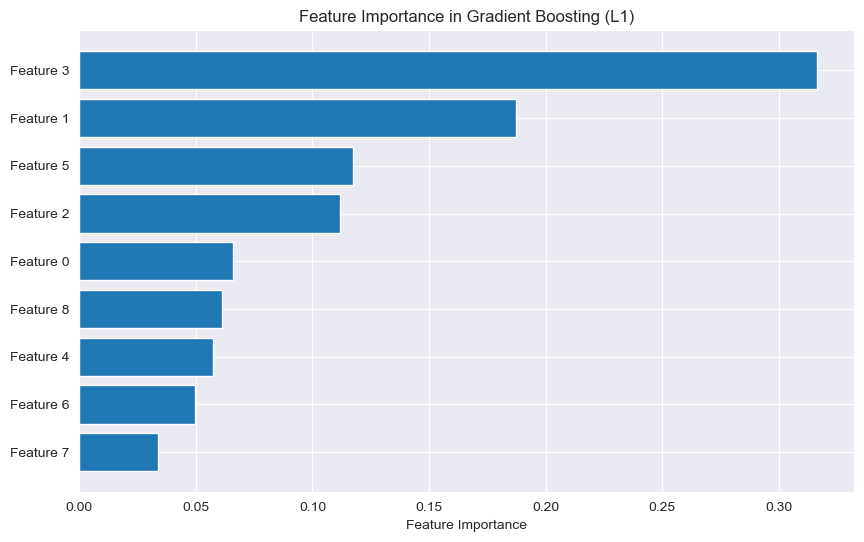

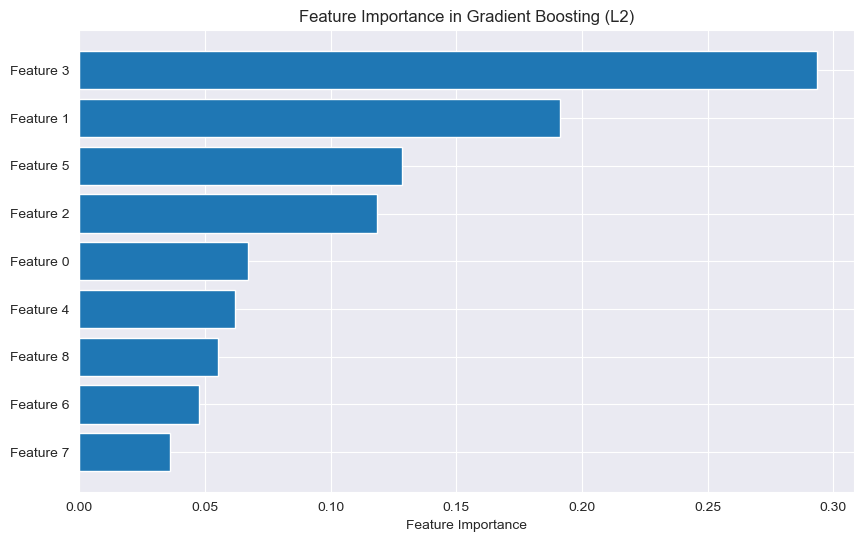

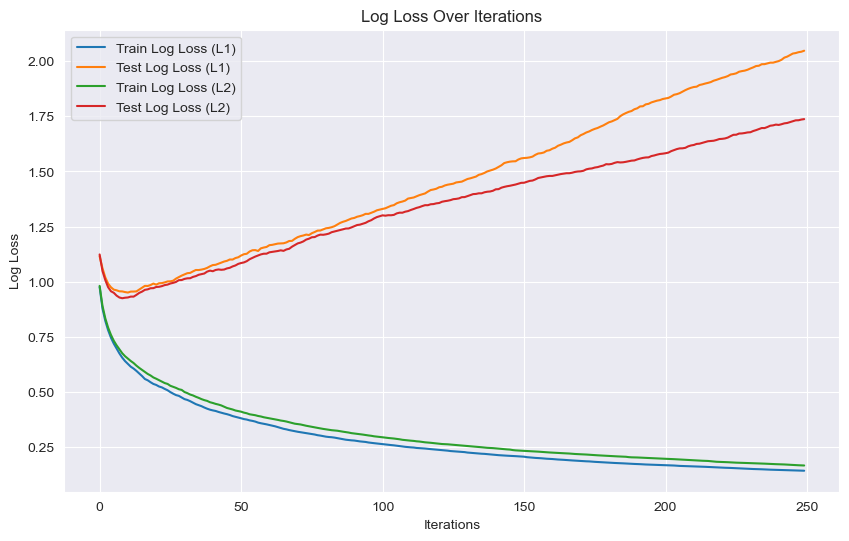

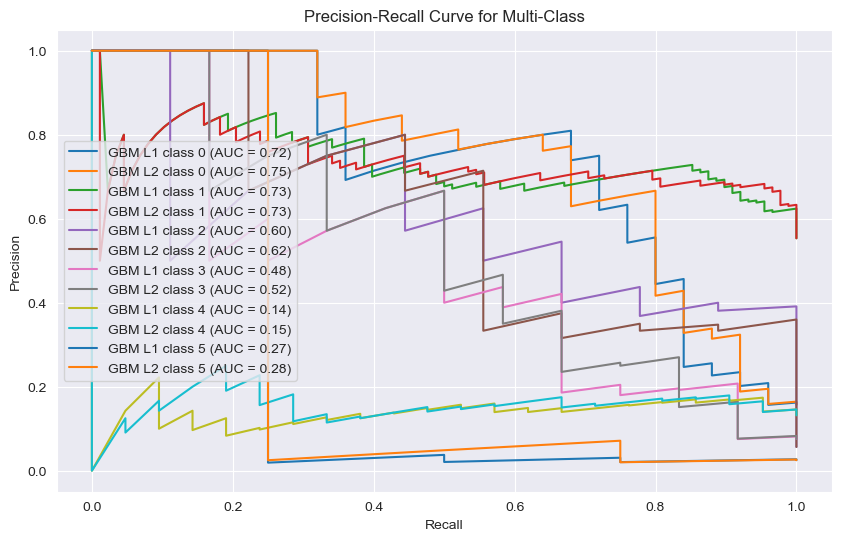

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, log_loss, accuracy_score
from sklearn.preprocessing import label_binarize
from matplotlib.colors import ListedColormap

# Fit the models with corrected loss parameter
gbm_l1 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3, random_state=42,
                                    loss='log_loss', min_samples_split=10)
gbm_l1.fit(X_train, y_train)
y_pred_gbm_l1 = gbm_l1.predict(X_test)
y_pred_proba_l1 = gbm_l1.predict_proba(X_test)

gbm_l2 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3, random_state=42,
                                    loss='log_loss', min_samples_split=10, min_samples_leaf=5)
gbm_l2.fit(X_train, y_train)
y_pred_gbm_l2 = gbm_l2.predict(X_test)
y_pred_proba_l2 = gbm_l2.predict_proba(X_test)

# Print model performance
gbm_l1_score_final = gbm_l1.score(X_test, y_test)
gbm_l2_score_final = gbm_l2.score(X_test, y_test)
print('Model performance:')
print(f'L1 Score: {gbm_l1.score(X_test, y_test)}')
print(f'L2 Score: {gbm_l2.score(X_test, y_test)}')

# Log Loss
logloss_l1 = log_loss(y_test, y_pred_proba_l1)
logloss_l2 = log_loss(y_test, y_pred_proba_l2)
print(f'Log Loss L1: {logloss_l1}')
print(f'Log Loss L2: {logloss_l2}')

# Precision, Recall, F1 Score for gbm_l1 (multi-class)
precision_l1 = precision_score(y_test, y_pred_gbm_l1, average='weighted')
recall_l1 = recall_score(y_test, y_pred_gbm_l1, average='weighted')
f1_l1 = f1_score(y_test, y_pred_gbm_l1, average='weighted')
print(f'Precision L1: {precision_l1}')
print(f'Recall L1: {recall_l1}')
print(f'F1 Score L1: {f1_l1}')

# Precision, Recall, F1 Score for gbm_l2 (multi-class)
precision_l2 = precision_score(y_test, y_pred_gbm_l2, average='weighted')
recall_l2 = recall_score(y_test, y_pred_gbm_l2, average='weighted')
f1_l2 = f1_score(y_test, y_pred_gbm_l2, average='weighted')
print(f'Precision L2: {precision_l2}')
print(f'Recall L2: {recall_l2}')
print(f'F1 Score L2: {f1_l2}')

numeric_label_accuracy = []
# Individual target variable accuracy (for each class)
print('\nIndividual Target Variable Accuracy:')
for class_label in np.unique(y_test):
    class_accuracy_l1 = accuracy_score(y_test == class_label, y_pred_gbm_l1 == class_label)
    numeric_label_accuracy.append(class_accuracy_l1)
    class_accuracy_l2 = accuracy_score(y_test == class_label, y_pred_gbm_l2 == class_label)
    print(f'Class {class_names[class_label]} - L1 Accuracy: {class_accuracy_l1:.4f}, L2 Accuracy: {class_accuracy_l2:.4f}')

# Feature importance for gbm_l1
feature_importance_l1 = gbm_l1.feature_importances_
sorted_idx_l1 = np.argsort(feature_importance_l1)

# Plot feature importance for gbm_l1
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_l1)), feature_importance_l1[sorted_idx_l1], align='center')
plt.yticks(range(len(sorted_idx_l1)), [f'Feature {i}' for i in sorted_idx_l1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting (L1)')
plt.show()

# Feature importance for gbm_l2
feature_importance_l2 = gbm_l2.feature_importances_
sorted_idx_l2 = np.argsort(feature_importance_l2)

# Plot feature importance for gbm_l2
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_l2)), feature_importance_l2[sorted_idx_l2], align='center')
plt.yticks(range(len(sorted_idx_l2)), [f'Feature {i}' for i in sorted_idx_l2])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting (L2)')
plt.show()

# Visualize the boosting process with log loss
train_log_loss_l1 = []
test_log_loss_l1 = []
train_log_loss_l2 = []
test_log_loss_l2 = []

for y_pred in gbm_l1.staged_predict_proba(X_train):
    train_log_loss_l1.append(log_loss(y_train, y_pred))
for y_pred in gbm_l1.staged_predict_proba(X_test):
    test_log_loss_l1.append(log_loss(y_test, y_pred))

for y_pred in gbm_l2.staged_predict_proba(X_train):
    train_log_loss_l2.append(log_loss(y_train, y_pred))
for y_pred in gbm_l2.staged_predict_proba(X_test):
    test_log_loss_l2.append(log_loss(y_test, y_pred))

# Plot log loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(train_log_loss_l1, label='Train Log Loss (L1)')
plt.plot(test_log_loss_l1, label='Test Log Loss (L1)')
plt.plot(train_log_loss_l2, label='Train Log Loss (L2)')
plt.plot(test_log_loss_l2, label='Test Log Loss (L2)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Log Loss Over Iterations')
plt.legend()
plt.show()

# Precision-Recall Curve for multi-class (One-vs-Rest approach)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
precision_l1_curve = {}
recall_l1_curve = {}
pr_auc_l1 = {}
precision_l2_curve = {}
recall_l2_curve = {}
pr_auc_l2 = {}

for i in range(y_test_binarized.shape[1]):
    precision_l1_curve[i], recall_l1_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_l1[:, i])
    pr_auc_l1[i] = auc(recall_l1_curve[i], precision_l1_curve[i])

    precision_l2_curve[i], recall_l2_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_l2[:, i])
    pr_auc_l2[i] = auc(recall_l2_curve[i], precision_l2_curve[i])

# Plot Precision-Recall Curve for multi-class
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    plt.plot(recall_l1_curve[i], precision_l1_curve[i], label=f'GBM L1 class {i} (AUC = {pr_auc_l1[i]:.2f})')
    plt.plot(recall_l2_curve[i], precision_l2_curve[i], label=f'GBM L2 class {i} (AUC = {pr_auc_l2[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class')
plt.legend(loc='best')
plt.show()


## Step 4 - ML on TOP feaute with missing value and duplicate value

In [127]:
metadata2 = pd.read_csv('/Users/ziaulhoque/Downloads/skindisease/metadata.csv')

In [128]:
metadata.isnull().sum()

patient_id               0
lesion_id                0
smoke                  804
drink                  804
background_father      818
background_mother      822
age                      0
pesticide              804
gender                 804
skin_cancer_history    804
cancer_history         804
has_piped_water        804
has_sewage_system      804
fitspatrick            804
region                   0
diameter_1             804
diameter_2             804
diagnostic               0
itch                     0
grew                     0
hurt                     0
changed                  0
bleed                    0
elevation                0
img_id                   0
biopsed                  0
dtype: int64

In [129]:
#As we know SMOTE doesnt work on NAN value
rows_with_nans = metadata2[metadata2.isna().any(axis=1)]
print(rows_with_nans)

     patient_id  lesion_id smoke drink background_father background_mother  \
0      PAT_1516       1765   NaN   NaN               NaN               NaN   
2      PAT_1545       1867   NaN   NaN               NaN               NaN   
3      PAT_1989       4061   NaN   NaN               NaN               NaN   
5      PAT_1549       1882   NaN   NaN               NaN               NaN   
8      PAT_1995       4080   NaN   NaN               NaN               NaN   
...         ...        ...   ...   ...               ...               ...   
2288   PAT_1407       1402   NaN   NaN               NaN               NaN   
2290   PAT_1294       1031   NaN   NaN               NaN               NaN   
2293   PAT_1708       3156   NaN   NaN               NaN               NaN   
2295   PAT_1343       1217   NaN   NaN               NaN               NaN   
2297   PAT_1714       3189   NaN   NaN               NaN               NaN   

      age pesticide gender skin_cancer_history  ... diameter_2 

In [130]:
metadata2.isnull().sum()

patient_id               0
lesion_id                0
smoke                  804
drink                  804
background_father      818
background_mother      822
age                      0
pesticide              804
gender                 804
skin_cancer_history    804
cancer_history         804
has_piped_water        804
has_sewage_system      804
fitspatrick            804
region                   0
diameter_1             804
diameter_2             804
diagnostic               0
itch                     0
grew                     0
hurt                     0
changed                  0
bleed                    0
elevation                0
img_id                   0
biopsed                  0
dtype: int64

In [131]:
X= metadata2.drop(['patient_id','lesion_id','background_father', 'background_mother','diagnostic','img_id','smoke','drink','pesticide','gender','skin_cancer_history','cancer_history','has_piped_water','has_sewage_system','fitspatrick','diameter_1','diameter_2'],axis=1)

In [132]:
y = metadata2['diagnostic']

In [133]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to multiple columns in X
columns_to_encode = [ 'region',
                      'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation']

X[columns_to_encode] = X[columns_to_encode].apply(label_encoder.fit_transform)

# Apply LabelEncoder to the 'diagnostic' column in y
le = LabelEncoder()
y = le.fit_transform(y)
# Check the transformed data
print(X)


      age  region  itch  grew  hurt  changed  bleed  elevation  biopsed
0       8       1     0     0     0        0      0          0    False
1      55      10     1     1     0        1      1          1     True
2      77       5     1     0     0        0      0          0    False
3      75       8     1     0     0        0      0          0    False
4      79       7     1     1     0        0      1          1     True
...   ...     ...   ...   ...   ...      ...    ...        ...      ...
2293   73       8     1     0     0        0      0          0    False
2294   55       3     1     1     0        1      0          0     True
2295   74       7     0     0     0        0      0          0    False
2296   58       5     1     0     0        0      0          1     True
2297   41      13     0     1     0        0      0          1    False

[2298 rows x 9 columns]


In [134]:
from sklearn.feature_selection import SelectKBest,f_classif
import pandas as pd

FIT_FEATURES = SelectKBest(score_func=f_classif)
FIT_FEATURES.fit(X,y)
SCORE_COL = pd.DataFrame(FIT_FEATURES.scores_,columns = ['score value'])
NAME_COL = pd.DataFrame(X.columns)
TOP_FEATURES = pd.concat([NAME_COL,SCORE_COL],axis = 1)
print(TOP_FEATURES)

           0  score value
0        age   202.925429
1     region    11.496629
2       itch   172.571785
3       grew   223.809156
4       hurt    73.954465
5    changed   115.280852
6      bleed   151.872679
7  elevation   168.796012
8    biopsed   861.555166


In [135]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Assuming X is a DataFrame and y is the target

# Initialize SelectKBest with f_classif
selector = SelectKBest(score_func=f_classif)

# Fit SelectKBest to your data
selector.fit(X, y)

# Get the scores of all features
scores = selector.scores_

# Create a DataFrame for feature names and scores
features_scores = pd.DataFrame({
    'feature_name': X.columns,
    'score_value': scores
})

# Sort features by their scores in descending order
features_scores_sorted = features_scores.sort_values(by='score_value', ascending=False)

# Print all features with their scores
#print("All features sorted by scores:")
#print(features_scores_sorted)

# Select the top 15 features
TOP_FEATURES = features_scores_sorted.head(9)

# Print the top 15 features with their scores
print("\nTop 13 features with their scores:")
print(TOP_FEATURES)



Top 13 features with their scores:
  feature_name  score_value
8      biopsed   861.555166
3         grew   223.809156
0          age   202.925429
2         itch   172.571785
7    elevation   168.796012
6        bleed   151.872679
5      changed   115.280852
4         hurt    73.954465
1       region    11.496629


In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Extract the top 16 features from the list in 'TOP_FEATURES'
selected_features = TOP_FEATURES['feature_name'].tolist()

# Subset the original dataset with only the selected features
X_selected = X[selected_features]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize the scaler and apply to training and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now, X_train_scaled, X_test_scaled, y_train, y_test are ready for modeling


In [137]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss

# Dictionary to store models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),  # SVM with probability estimates for log loss
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Dictionary to store model performance
model_performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

    # Store performance
    model_performance[model_name] = {
        "Accuracy": accuracy,
        "Log Loss": log_loss_value
    }

    # Print metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Log Loss: {log_loss_value}")
    print(classification_report(y_test, y_pred))
    print("-" * 40)

# Display overall performance
print("Summary of Model Performance:")
for model_name, metrics in model_performance.items():
    print(f"{model_name} - Accuracy: {metrics['Accuracy']:.2f}, Log Loss: {metrics['Log Loss']}")


Model: Logistic Regression
Accuracy: 0.7347826086956522
Log Loss: 0.7375821585140883
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       133
           1       0.69      0.96      0.80       177
           2       0.67      0.31      0.42        13
           3       0.79      0.62      0.70        50
           4       0.00      0.00      0.00        44
           5       0.70      0.60      0.65        43

    accuracy                           0.73       460
   macro avg       0.61      0.55      0.56       460
weighted avg       0.67      0.73      0.69       460

----------------------------------------
Model: Decision Tree
Accuracy: 0.7717391304347826
Log Loss: 7.780335781091979
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       133
           1       0.83      0.87      0.85       177
           2       0.71      0.77      0.74        13
           3       0.70      0.62   

Model performance:
L1 Score: 0.8065217391304348
L2 Score: 0.8021739130434783
Log Loss L1: 0.7364582418482324
Log Loss L2: 0.7240435924371773
Precision L1: 0.8017082024712923
Recall L1: 0.8065217391304348
F1 Score L1: 0.8010095675699521
Precision L2: 0.7995255628420147
Recall L2: 0.8021739130434783
F1 Score L2: 0.7990065158652114


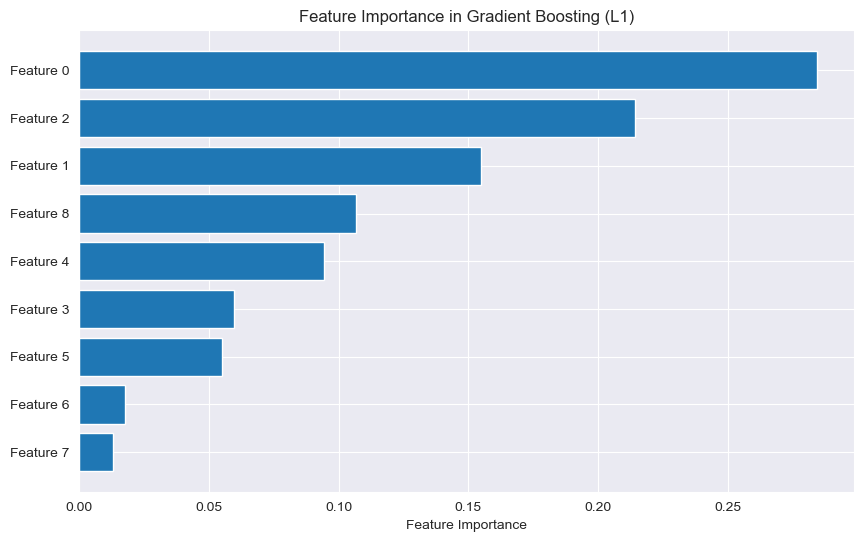

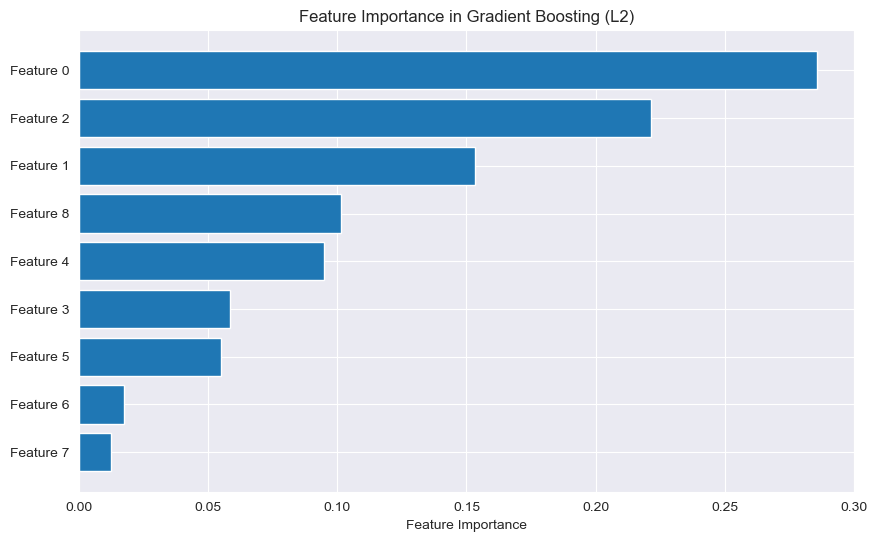

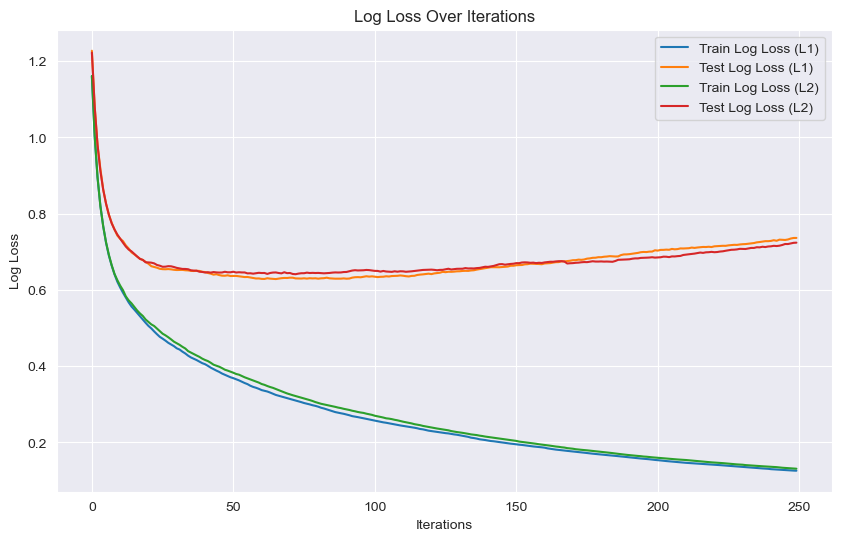

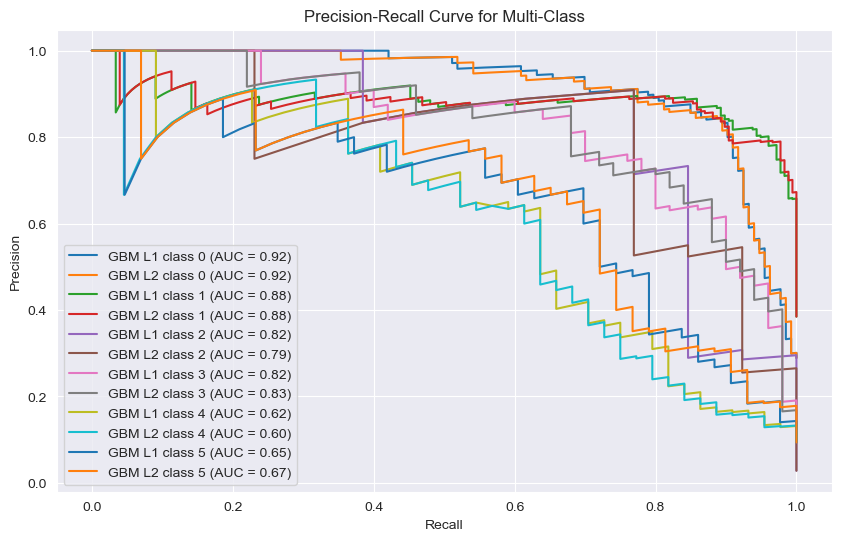

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, log_loss
from sklearn.preprocessing import label_binarize
from matplotlib.colors import ListedColormap


# Fit the models with corrected loss parameter
gbm_l1 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3, random_state=42,
                                    loss='log_loss', min_samples_split=10)
gbm_l1.fit(X_train, y_train)
y_pred_gbm_l1 = gbm_l1.predict(X_test)
y_pred_proba_l1 = gbm_l1.predict_proba(X_test)

gbm_l2 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3, random_state=42,
                                    loss='log_loss', min_samples_split=10, min_samples_leaf=5)
gbm_l2.fit(X_train, y_train)
y_pred_gbm_l2 = gbm_l2.predict(X_test)
y_pred_proba_l2 = gbm_l2.predict_proba(X_test)

# Print model performance
print('Model performance:')
print(f'L1 Score: {gbm_l1.score(X_test, y_test)}')
print(f'L2 Score: {gbm_l2.score(X_test, y_test)}')

# Log Loss
logloss_l1 = log_loss(y_test, y_pred_proba_l1)
logloss_l2 = log_loss(y_test, y_pred_proba_l2)
print(f'Log Loss L1: {logloss_l1}')
print(f'Log Loss L2: {logloss_l2}')

# Precision, Recall, F1 Score for gbm_l1 (multi-class)
precision_l1 = precision_score(y_test, y_pred_gbm_l1, average='weighted')
recall_l1 = recall_score(y_test, y_pred_gbm_l1, average='weighted')
f1_l1 = f1_score(y_test, y_pred_gbm_l1, average='weighted')
print(f'Precision L1: {precision_l1}')
print(f'Recall L1: {recall_l1}')
print(f'F1 Score L1: {f1_l1}')

# Precision, Recall, F1 Score for gbm_l2 (multi-class)
precision_l2 = precision_score(y_test, y_pred_gbm_l2, average='weighted')
recall_l2 = recall_score(y_test, y_pred_gbm_l2, average='weighted')
f1_l2 = f1_score(y_test, y_pred_gbm_l2, average='weighted')
print(f'Precision L2: {precision_l2}')
print(f'Recall L2: {recall_l2}')
print(f'F1 Score L2: {f1_l2}')

# Feature importance for gbm_l1
feature_importance_l1 = gbm_l1.feature_importances_
sorted_idx_l1 = np.argsort(feature_importance_l1)

# Plot feature importance for gbm_l1
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_l1)), feature_importance_l1[sorted_idx_l1], align='center')
plt.yticks(range(len(sorted_idx_l1)), [f'Feature {i}' for i in sorted_idx_l1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting (L1)')
plt.show()

# Feature importance for gbm_l2
feature_importance_l2 = gbm_l2.feature_importances_
sorted_idx_l2 = np.argsort(feature_importance_l2)

# Plot feature importance for gbm_l2
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_l2)), feature_importance_l2[sorted_idx_l2], align='center')
plt.yticks(range(len(sorted_idx_l2)), [f'Feature {i}' for i in sorted_idx_l2])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting (L2)')
plt.show()

# Visualize the boosting process with log loss
train_log_loss_l1 = []
test_log_loss_l1 = []
train_log_loss_l2 = []
test_log_loss_l2 = []

for y_pred in gbm_l1.staged_predict_proba(X_train):
    train_log_loss_l1.append(log_loss(y_train, y_pred))
for y_pred in gbm_l1.staged_predict_proba(X_test):
    test_log_loss_l1.append(log_loss(y_test, y_pred))

for y_pred in gbm_l2.staged_predict_proba(X_train):
    train_log_loss_l2.append(log_loss(y_train, y_pred))
for y_pred in gbm_l2.staged_predict_proba(X_test):
    test_log_loss_l2.append(log_loss(y_test, y_pred))

# Plot log loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(train_log_loss_l1, label='Train Log Loss (L1)')
plt.plot(test_log_loss_l1, label='Test Log Loss (L1)')
plt.plot(train_log_loss_l2, label='Train Log Loss (L2)')
plt.plot(test_log_loss_l2, label='Test Log Loss (L2)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Log Loss Over Iterations')
plt.legend()
plt.show()

# Precision-Recall Curve for multi-class (One-vs-Rest approach)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
precision_l1_curve = {}
recall_l1_curve = {}
pr_auc_l1 = {}
precision_l2_curve = {}
recall_l2_curve = {}
pr_auc_l2 = {}

for i in range(y_test_binarized.shape[1]):
    precision_l1_curve[i], recall_l1_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_l1[:, i])
    pr_auc_l1[i] = auc(recall_l1_curve[i], precision_l1_curve[i])

    precision_l2_curve[i], recall_l2_curve[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_l2[:, i])
    pr_auc_l2[i] = auc(recall_l2_curve[i], precision_l2_curve[i])

# Plot Precision-Recall Curve for multi-class
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    plt.plot(recall_l1_curve[i], precision_l1_curve[i], label=f'GBM L1 class {i} (AUC = {pr_auc_l1[i]:.2f})')
    plt.plot(recall_l2_curve[i], precision_l2_curve[i], label=f'GBM L2 class {i} (AUC = {pr_auc_l2[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class')
plt.legend(loc='best')
plt.show()


# FInal Random Forest Model

Mean Prediction Probability: [0.19628763 0.54134384 0.03648829 0.05341137 0.13715114 0.03531773]
Standard Deviation of Prediction Probability: [0.26350594 0.32510456 0.11012022 0.14352374 0.16801896 0.10321658]
Average Mean Probability: 0.1666666666666666
Average Std Probability: 0.1855816671538376
Confusion Matrix:
[[ 50   7   0   0   0   0]
 [  3 157   1   0   1   0]
 [  0   1   5   2   0   0]
 [  0   4   0  13   0   0]
 [  4  23   0   0  17   0]
 [  3   2   0   1   0   5]]
Overall Accuracy: 0.8261
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        57
           1       0.81      0.97      0.88       162
           2       0.83      0.62      0.71         8
           3       0.81      0.76      0.79        17
           4       0.94      0.39      0.55        44
           5       1.00      0.45      0.62        11

    accuracy                           0.83       299
   macro avg       0.87      0.68    

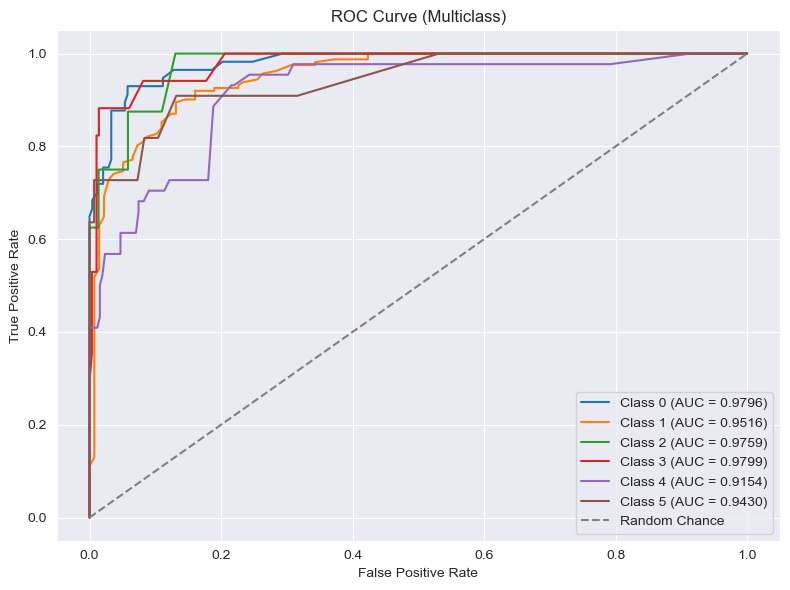

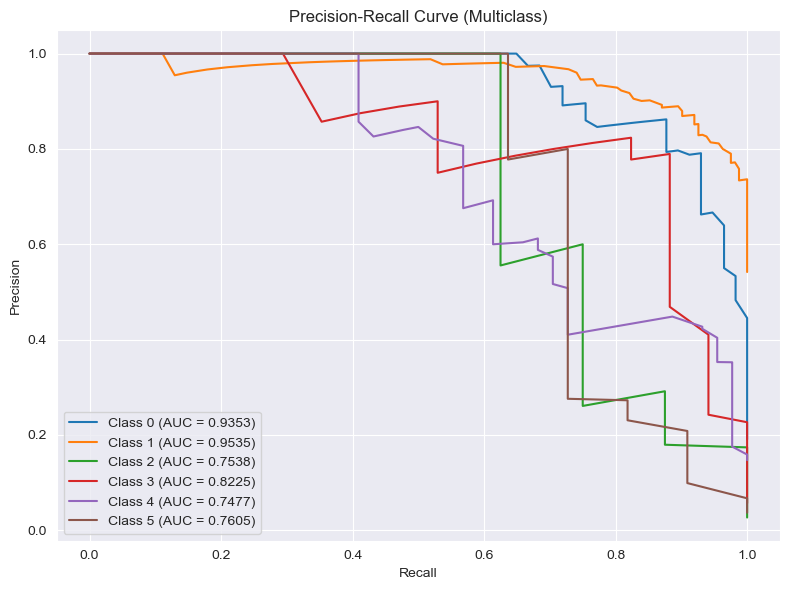

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_curve,
    auc,
    log_loss,
    mean_squared_error
)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

# Function to plot ROC curve (multiclass)
def plot_multiclass_roc(y_test, y_prob, classes):
    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to plot Precision-Recall Curve (multiclass)
def plot_multiclass_pr_curve(y_test, y_prob, classes):
    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"Class {class_label} (AUC = {pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Multiclass)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_final)

# Predict on test set
y_pred = rf_model.predict(X_test_final)
y_pred_proba = rf_model.predict_proba(X_test_final)

# Mean, standard deviation, and prediction probability for each model
mean_proba = np.mean(y_pred_proba, axis=0)
std_proba = np.std(y_pred_proba, axis=0)

# Calculate average mean and standard deviation
avg_mean = np.mean(mean_proba)
avg_std = np.mean(std_proba)

# Print results
print(f'Mean Prediction Probability: {mean_proba}')
print(f'Standard Deviation of Prediction Probability: {std_proba}')
print(f'Average Mean Probability: {avg_mean}')
print(f'Average Std Probability: {avg_std}')

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test_final, y_pred)
print(cm)

accuracy = accuracy_score(y_test_final, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

print("Classification Report:")
report = classification_report(y_test_final, y_pred)
print(report)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Log Loss
logloss = log_loss(y_test_final, y_pred_proba)
print(f"Log Loss: {logloss:.4f}")

# Per-class accuracy
numeric_label_accuracy=[]
classes = np.unique(y_train_final)
for class_label in classes:
    class_specific_accuracy = accuracy_score(
        y_test_final == class_label, y_pred == class_label
    )
    numeric_label_accuracy.append(class_specific_accuracy)

print(f"Accuracy for class '{class_names[class_label]}': {class_specific_accuracy:.4f}")

# ROC Curve
y_test_bin = label_binarize(y_test_final, classes=classes)
plot_multiclass_roc(y_test_bin, y_pred_proba, classes)

# Precision-Recall Curve
plot_multiclass_pr_curve(y_test_bin, y_pred_proba, classes)


In [140]:
y_pred_proba

array([[0.  , 0.63, 0.  , 0.  , 0.34, 0.03],
       [0.24, 0.36, 0.02, 0.02, 0.33, 0.03],
       [0.06, 0.55, 0.03, 0.18, 0.1 , 0.08],
       ...,
       [0.84, 0.09, 0.  , 0.  , 0.07, 0.  ],
       [0.47, 0.09, 0.01, 0.01, 0.42, 0.  ],
       [0.02, 0.59, 0.  , 0.  , 0.36, 0.03]])

# Predictive probability mean std

In [141]:
# Replace with the Random Forest model's mean, std, and accuracy values
numeric_model_mean = avg_mean  # Replace with Random Forest model's mean
numeric_model_std = avg_std    # Replace with Random Forest model's standard deviation
numeric_model_accuracy = accuracy  # Replace with Random Forest model's accuracy

# Print the updated values
print("Random Forest Model Results:")
print(f"Mean Prediction Probability: {numeric_model_mean:.4f}")
print(f"Standard Deviation of Prediction Probability: {numeric_model_std:.4f}")
print(f"Accuracy of Random Forest Model: {numeric_model_accuracy:.4f}")
print("Image model values are:\n")
print(image_model_mean, image_model_std, image_model_accuracy)

Random Forest Model Results:
Mean Prediction Probability: 0.1667
Standard Deviation of Prediction Probability: 0.1856
Accuracy of Random Forest Model: 0.8261
Image model values are:

0.9992100141553775 0.33910085546097557 0.615781567866774


# Checking Distribution

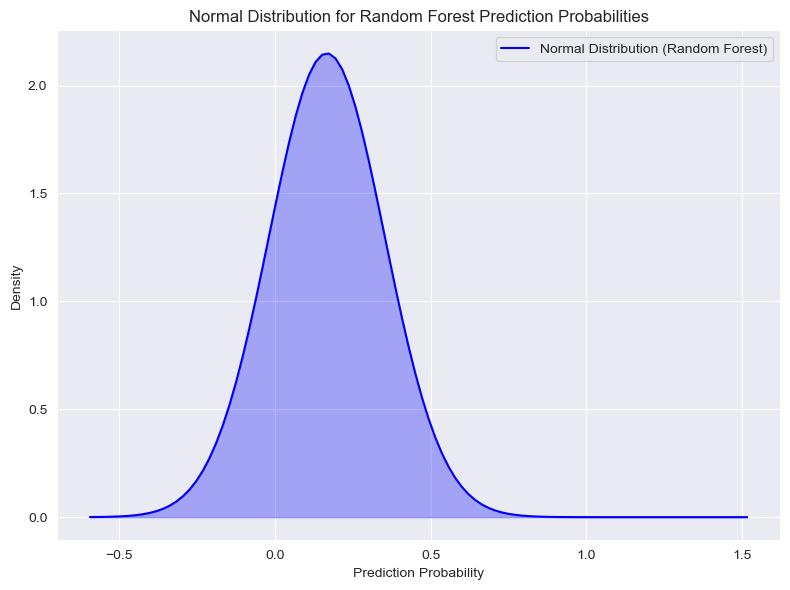

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming mean_proba and std_proba are from the Random Forest model as calculated in the previous code
mean_proba_rf = mean_proba  # Mean of the prediction probabilities
std_proba_rf = std_proba    # Standard deviation of the prediction probabilities
avg_mean_rf = avg_mean      # Average mean of the prediction probabilities
avg_std_rf = avg_std        # Average standard deviation of the prediction probabilities

# Set up the figure for plotting (only one plot)
fig, ax = plt.subplots(figsize=(8, 6))

# Plot for Random Forest model (rf)
x_rf = np.linspace(min(mean_proba_rf - 3*std_proba_rf), max(mean_proba_rf + 3*std_proba_rf), 100)
y_rf = norm.pdf(x_rf, avg_mean_rf, avg_std_rf)
ax.plot(x_rf, y_rf, label="Normal Distribution (Random Forest)", color='blue')
ax.fill_between(x_rf, y_rf, color='blue', alpha=0.3)
ax.set_title('Normal Distribution for Random Forest Prediction Probabilities')
ax.set_xlabel('Prediction Probability')
ax.set_ylabel('Density')
ax.legend()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()



--- Checking Normal Distribution for Random Forest ---


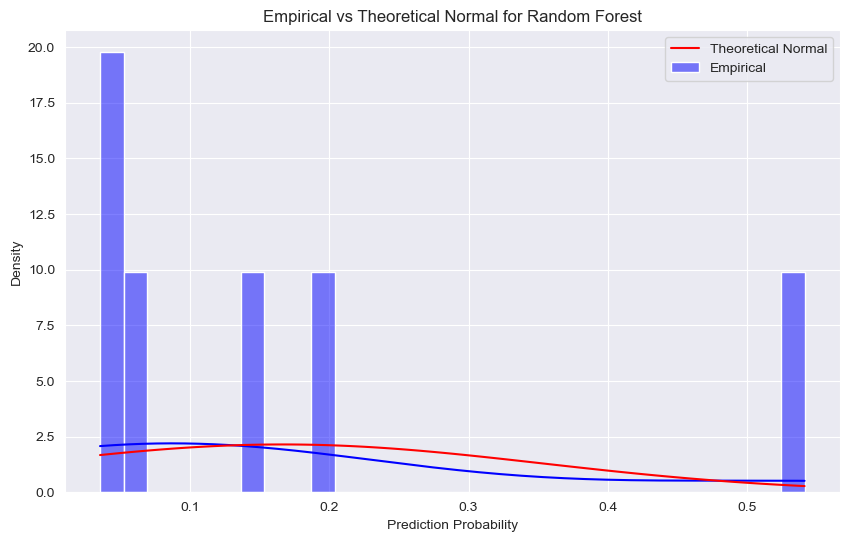

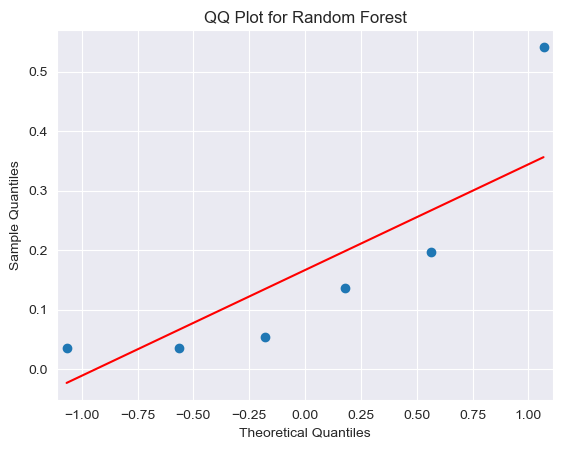


Statistical Tests:
Shapiro-Wilk Test: Statistic=0.7538, p-value=0.0217
Kolmogorov-Smirnov Test: Statistic=0.2699, p-value=0.6856
Anderson-Darling Test: Statistic=0.6993
  Significance Level 15.0%: Critical Value = 0.5920
  Significance Level 10.0%: Critical Value = 0.6750
  Significance Level 5.0%: Critical Value = 0.8090
  Significance Level 2.5%: Critical Value = 0.9440
  Significance Level 1.0%: Critical Value = 1.1230
  Result: Data seems to follow a normal distribution.


In [143]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro, kstest, anderson
import seaborn as sns
import statsmodels.api as sm

# Assuming your datasets are: mean_proba_rf and their mean and standard deviation are avg_mean_rf, avg_std_rf.

# Visual and statistical checks for Gaussian distribution
def check_normal_distribution(data, avg_mean, avg_std, label):
    print(f"\n--- Checking Normal Distribution for {label} ---")

    # Visual: Histogram + KDE + Theoretical Normal Curve
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True, stat="density", bins=30, label="Empirical", color='blue')
    x = np.linspace(min(data), max(data), 100)
    y = norm.pdf(x, avg_mean, avg_std)
    plt.plot(x, y, label="Theoretical Normal", color='red')
    plt.title(f"Empirical vs Theoretical Normal for {label}")
    plt.xlabel('Prediction Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Visual: QQ Plot
    sm.qqplot(data, line='s')
    plt.title(f"QQ Plot for {label}")
    plt.show()

    # Statistical Tests
    print("\nStatistical Tests:")
    # Shapiro-Wilk Test
    shapiro_test = shapiro(data)
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")

    # Kolmogorov-Smirnov Test
    ks_test = kstest(data, 'norm', args=(avg_mean, avg_std))
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_test.statistic:.4f}, p-value={ks_test.pvalue:.4f}")

    # Anderson-Darling Test
    anderson_test = anderson(data, dist='norm')
    print(f"Anderson-Darling Test: Statistic={anderson_test.statistic:.4f}")
    for i, (sl, cv) in enumerate(zip(anderson_test.significance_level, anderson_test.critical_values)):
        print(f"  Significance Level {sl:.1f}%: Critical Value = {cv:.4f}")
    if anderson_test.statistic < anderson_test.critical_values[2]:
        print("  Result: Data seems to follow a normal distribution.")
    else:
        print("  Result: Data does not follow a normal distribution.")

# Call the function for Random Forest prediction probabilities
check_normal_distribution(mean_proba_rf, avg_mean_rf, avg_std_rf, "Random Forest")


# Normal Distribution cheeking

if doesn't follow normal distribution it is good for Tree based model gb,rf etc.
Good: These models, including GradientBoostingClassifier, are non-parametric. This means they don't assume a specific distribution for the data. They can work well with data that doesn't follow a normal distribution.
Reason: Tree-based models rely on partitioning the data based on decision rules (splitting features at specific thresholds), and they are more concerned with the relationships between the variables than the underlying data distribution.
Neural Networks and Other Complex Models:
Generally okay: Neural networks and other complex models (e.g., support vector machines, k-nearest neighbors) can handle non-normal data fairly well because they don't have strong assumptions about the underlying distribution.
Reason: These models are more flexible and can learn from complex, non-linear relationships in the data, so normality is not a major concern.

## Late Fusion

# Kfold Cross Validation

In [144]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=10, shuffle=True) #each fold contain 20% data
result = cross_val_score(rf_model, X_train, y_train, cv=kfold)
print(result)
print(result.mean(),result.max(),result.min())

[0.78804348 0.78804348 0.81521739 0.82065217 0.78804348 0.79891304
 0.82608696 0.81521739 0.83606557 0.80327869]
0.8079561653599431 0.8360655737704918 0.7880434782608695


In [145]:
import torch
import torch.utils.data
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from torchvision import datasets, transforms

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Assuming 'train_data' is your ImageFolder dataset
train_data = datasets.ImageFolder(root=train_dir, transform=transform)

# KFold cross-validation
kfold = KFold(n_splits=10, shuffle=True)

# List to store results for each fold
results = []

# Get the indices for each fold
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(train_data)))):
    print(f'Fold {fold + 1}')

    # Create subsets using the indices for training and validation data
    train_subset = torch.utils.data.Subset(train_data, train_idx)
    val_subset = torch.utils.data.Subset(train_data, val_idx)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

    # Initialize your model and ensure it's in evaluation mode
    model_resnet50.eval()

    # List to collect predictions and labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Ensure inputs are on the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_resnet50(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(all_labels.cpu(), all_preds.cpu())
    results.append(accuracy)

# Print the results
print("Results for each fold: ", results)
print(f"Mean accuracy: {np.mean(results)}")
print(f"Max accuracy: {np.max(results)}")
print(f"Min accuracy: {np.min(results)}")


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
Results for each fold:  [0.30978260869565216, 0.22282608695652173, 0.20108695652173914, 0.2391304347826087, 0.2608695652173913, 0.25, 0.22826086956521738, 0.1793478260869565, 0.26229508196721313, 0.2185792349726776]
Mean accuracy: 0.23721786647659773
Max accuracy: 0.30978260869565216
Min accuracy: 0.1793478260869565


In [146]:
numeric_label_accuracy

[0.9431438127090301,
 0.8595317725752508,
 0.9866220735785953,
 0.9765886287625418,
 0.9063545150501672,
 0.979933110367893]

In [147]:
model_resnet50.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
                         -4.3034e-02, -7.0755e-02],
                        [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
                         -2.0912e-02, -3.8517e-02],
                        [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
                          6.2641e-02,  5.1977e-02],
                        ...,
                        [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
                         -7.6604e-02,  7.8453e-03],
                        [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
                         -3.3662e-02, -1.5709e-02],
                        [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
                          2.2439e-02,  1.7077e-03]],
              
                       [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
                          4.4022

# DST Fusion

In [148]:
def combine_evidence(mass_functions, hypotheses):
    """
    Combine evidence using the Dempster-Shafer combination rule.

    Parameters:
    - mass_functions: A list of dictionaries where each dictionary represents the mass function 
                      of a modality. Each dictionary maps a tuple (hypotheses or subsets) to a mass value.
    - hypotheses: A list of individual target hypotheses, e.g., [("H1",), ("H2",), ..., ("Hk",)].

    Returns:
    - combined_mass: A dictionary mapping each hypothesis to its combined mass.
    """
    from itertools import product

    # Initialize the combined mass dictionary for each hypothesis
    combined_mass = {H: 0.0 for H in hypotheses}

    # Helper function to calculate the intersection of multiple subsets
    def intersect(subsets):
        result = set.intersection(*[set(sub) for sub in subsets])
        return tuple(result) if result else None  # Return None for an empty intersection

    # Compute the numerator for each hypothesis
    for H in hypotheses:
        numerator = 0.0

        # Generate all combinations of subsets across modalities
        subsets_combinations = product(*[list(mf.keys()) for mf in mass_functions])

        for subsets in subsets_combinations:
            # Calculate the intersection of these subsets
            intersection = intersect(subsets)

            # If the intersection matches the current hypothesis, add to the numerator
            if intersection == H:
                mass_product = 1.0
                for i, subset in enumerate(subsets):
                    mass_product *= mass_functions[i][subset]
                numerator += mass_product

        combined_mass[H] = numerator

    # Compute the denominator
    denominator = 1.0
    subsets_combinations = product(*[list(mf.keys()) for mf in mass_functions])
    conflict_mass = 0.0

    for subsets in subsets_combinations:
        # Calculate the intersection of these subsets
        intersection = intersect(subsets)

        # Add to the conflict mass if the intersection is empty
        if intersection is None:
            mass_product = 1.0
            for i, subset in enumerate(subsets):
                mass_product *= mass_functions[i][subset]
            conflict_mass += mass_product

    denominator -= conflict_mass

    # Normalize the combined mass
    for H in combined_mass:
        combined_mass[H] /= denominator

    return combined_mass


In [149]:
import numpy as np

def dempster_shafer_combination(numeric_accuracies, image_accuracies):
    """
    Combine two modalities (numeric and image) using Dempster-Shafer theory.
    
    Parameters:
    numeric_accuracies (list): Accuracies from the numeric modality for each class.
    image_accuracies (list): Accuracies from the image modality for each class.
    
    Returns:
    list: Combined mass function for each class.
    """
    # Number of classes
    num_classes = len(numeric_accuracies)

    # Initialize the mass functions for both modalities
    m_numeric = np.array(numeric_accuracies)
    m_image = np.array(image_accuracies)

    # Normalize the mass functions (so they sum to 1)
    m_numeric /= np.sum(m_numeric)
    m_image /= np.sum(m_image)

    # Initialize the combined mass function array
    combined_mass = np.zeros(num_classes)

    # Dempster's rule of combination
    for i in range(num_classes):
        for j in range(num_classes):
            if i == j:
                # Combine masses for the same class
                combined_mass[i] += m_numeric[i] * m_image[j]

    # Normalize the combined mass function
    combined_mass /= np.sum(combined_mass)

    return combined_mass

# Example data
numeric_accuracies = numeric_label_accuracy
image_accuracies = image_label_accuracy

# Call the function
combined_mass = dempster_shafer_combination(numeric_accuracies, image_accuracies)

print("Combined Mass Function for each class: ", combined_mass)


Combined Mass Function for each class:  [0.26820787 0.24313042 0.03974771 0.26868728 0.         0.18022672]


In [150]:
import numpy as np

def calculate_dst_fused_accuracy(combined_mass, numeric_accuracy, image_accuracy,numeric_std,image_std):
    """
    Calculate the fused accuracy based on combined mass function and individual accuracies.
    
    Parameters:
    combined_mass (list): Combined mass function for each class.
    numeric_accuracy (float): Overall accuracy of the numeric modality.
    image_accuracy (float): Overall accuracy of the image modality.
    
    Returns:
    float: The overall fused accuracy.
    """
    # Number of classes (assumed to be 6 as per your example)
    num_classes = len(combined_mass)

    # Normalize the individual accuracies to make them a weight
    numeric_val = numeric_accuracy/numeric_std
    image_val = image_accuracy/image_std
    total_weight = (numeric_val) + (image_val)
    numeric_weight = numeric_val / total_weight
    image_weight = image_val / total_weight

    # Calculate the fused accuracy
    fused_accuracy = 0
    for i in range(num_classes):
        # Weigh each class's mass function by the numeric and image modality accuracies
        fused_accuracy += combined_mass[i] * (numeric_weight * numeric_accuracy + image_weight * image_accuracy)

    return fused_accuracy


# Call the function
final_dst_fused_accuracy = calculate_dst_fused_accuracy(combined_mass, numeric_model_accuracy, image_model_accuracy,numeric_model_std,image_model_std)
final_dst_fused_accuracy_round = round(final_dst_fused_accuracy,2)
print("Dst Fused Accuracy: ", final_dst_fused_accuracy_round)


Dst Fused Accuracy:  0.77


# Statastical Weighted Fusion

In [151]:
def StatasticalWeightedFusion(model1_val, model1_std, model2_val, model2_std):
    """
    Calculate the Bayesian Monte Carlo weighted value based on two models' values and standard deviations.

    Parameters:
    - model1_val: Value of the first model.
    - model1_std: Standard deviation of the first model.
    - model2_val: Value of the second model.
    - model2_std: Standard deviation of the second model.
    - name: Optional name for the result.

    Returns:
    - A formatted string with the final Bayesian Monte Carlo result.
    """
    weighted_result = ((model1_val * (1 / model1_std)) + (model2_val * (1 / model2_std))) / (1 / model1_std + 1 / model2_std)
    return weighted_result
   


In [152]:
final_statastical_weighted_fusion = StatasticalWeightedFusion(image_model_accuracy,image_model_std,numeric_model_accuracy,numeric_model_std)
final_statastical_weighted_fusion_round = round(final_statastical_weighted_fusion, 2)
print(f"Final Statastical weighted Fusion result: {final_statastical_weighted_fusion_round}")
image_model_accuracy,image_model_std,numeric_model_accuracy,numeric_model_std

Final Statastical weighted Fusion result: 0.75


(0.615781567866774,
 0.33910085546097557,
 0.8260869565217391,
 0.1855816671538376)

# Bayesian Inference Fusion

In [153]:
print(f"Image Model Aaccuracy: {image_model_accuracy} and Numeric Model Aaccuracy: {numeric_model_accuracy}")
print(f"Image Model Std: {image_model_std} and Numeric Model Std: {numeric_model_std}")

Image Model Aaccuracy: 0.615781567866774 and Numeric Model Aaccuracy: 0.8260869565217391
Image Model Std: 0.33910085546097557 and Numeric Model Std: 0.1855816671538376


In [154]:
average_std_overall_model=np.mean([image_model_std,numeric_model_std])
average_std_overall_model

0.2623412613074066

In [155]:
def BayesianInferenceFusion(likelihood: float, prior: float, evidence: float) -> float:
    """
    Perform Bayesian inference fusion using Bayes' Theorem.

    Parameters:
    likelihood (float): The likelihood of the evidence given the hypothesis, P(E|H)
    prior (float): The prior probability of the hypothesis, P(H)
    evidence (float): The marginal probability of the evidence, P(E)

    Returns:
    float: The posterior probability, P(H|E)
    """
    return (likelihood * prior) / evidence



In [156]:
# Bayesian fusion of model accuracies
bayesian_image_model_accuracy = BayesianInferenceFusion(
    image_model_std,
    image_model_accuracy,
    np.mean([image_model_std, numeric_model_std])  # Correctly calculating the mean of two values
)

bayesian_numeric_model_accuracy = BayesianInferenceFusion(
    numeric_model_std,
    numeric_model_accuracy,
    np.mean([image_model_std, numeric_model_std])  # Correctly calculating the mean of two values
)

# Round individual accuracies to 2 decimal places
bayesian_image_model_accuracy_rounded = round(bayesian_image_model_accuracy, 2)
bayesian_numeric_model_accuracy_rounded = round(bayesian_numeric_model_accuracy, 2)

print(f"Bayesian Image Model Accuracy: {bayesian_image_model_accuracy_rounded}, Bayesian Numeric Model Accuracy: {bayesian_numeric_model_accuracy_rounded}")

# Final fused accuracy, rounded to 2 decimal places
final_bayesian_accuracy = np.mean([bayesian_image_model_accuracy, bayesian_numeric_model_accuracy])
final_bayesian_accuracy_rounded = round(final_bayesian_accuracy, 2)

print(f"Final Bayesian Fused Model Accuracy: {final_bayesian_accuracy_rounded:.2f}")
numeric_model_std,numeric_model_accuracy,image_model_std,image_model_accuracy

Bayesian Image Model Accuracy: 0.8, Bayesian Numeric Model Accuracy: 0.58
Final Bayesian Fused Model Accuracy: 0.69


(0.1855816671538376,
 0.8260869565217391,
 0.33910085546097557,
 0.615781567866774)

In [157]:
numeric_accuracies, image_accuracies

([0.9431438127090301,
  0.8595317725752508,
  0.9866220735785953,
  0.9765886287625418,
  0.9063545150501672,
  0.979933110367893],
 [0.7058823529411765,
  0.7021276595744681,
  0.1,
  0.6829268292682927,
  0.0,
  0.45652173913043476])

In [158]:
numeric_model_std,numeric_model_accuracy,image_model_std,image_model_accuracy


(0.1855816671538376,
 0.8260869565217391,
 0.33910085546097557,
 0.615781567866774)

In [159]:
w1 = (numeric_model_accuracy/numeric_model_std)
w2 = (image_model_accuracy/image_model_std)
w3 = w1/(w1+w2)
w4 = w2/(w1+w2)

In [160]:
# Assuming numeric_accuracies and image_accuracies are lists with the same length.
# Also assuming w3 and w4 are some weights you've defined elsewhere.

NR = []  # Numerator
DR = []  # Denominator

# Loop over the length of numeric_accuracies
for i in range(len(numeric_accuracies)):
    numerator = (numeric_accuracies[i] ** w3) * (image_accuracies[i] ** w4)
    denominator = ((1 - numeric_accuracies[i]) ** w3) * ((1 - image_accuracies[i]) ** w4)
    NR.append(numerator)
    DR.append(denominator)

# Now compute the N list (sum of NR and DR)
N = []
for i in range(len(NR)):
    N.append(NR[i] + DR[i])

# Compute PP (final probability or metric)
PP = []
for i in range(len(N)):
    if N[i] != 0:  # Avoid division by zero
        PP.append(NR[i] / N[i])
    else:
        PP.append(0)  # Handle cases where N[i] is zero

# Print the final result
print(PP)


[0.9045250814589597, 0.8227366892806022, 0.9181842676449861, 0.9464524679248927, 0.0, 0.9376864283059644]


In [161]:
# Call the function
final_BN_fused_accuracy = calculate_dst_fused_accuracy(PP, numeric_model_accuracy, image_model_accuracy,numeric_model_std, image_model_std)
final_BN_fused_accuracy_round = round(final_dst_fused_accuracy,2)
print("BN Fused Accuracy: ", final_dst_fused_accuracy_round)

BN Fused Accuracy:  0.77


In [162]:
average_probabilistic_fused_accuracy = np.mean([final_dst_fused_accuracy_round,final_statastical_weighted_fusion_round,final_bayesian_accuracy_rounded,final_BN_fused_accuracy_round])
maximum_probabilistic_fused_accuracy =  np.max([final_dst_fused_accuracy_round,final_statastical_weighted_fusion_round,final_bayesian_accuracy_rounded,final_BN_fused_accuracy_round])
minimum_probabilistic_fused_accuracy =  np.min([final_dst_fused_accuracy_round,final_statastical_weighted_fusion_round,final_bayesian_accuracy_rounded,final_BN_fused_accuracy_round])

print(f"Final Multimodal average Probailistic Fused Accuracy: {average_probabilistic_fused_accuracy}, maximum: {maximum_probabilistic_fused_accuracy} ,minimum: {minimum_probabilistic_fused_accuracy} ")


Final Multimodal average Probailistic Fused Accuracy: 0.745, maximum: 0.77 ,minimum: 0.69 


In [163]:
image_model_uncertainty_lavel = average_probabilistic_fused_accuracy - image_model_accuracy
numeric_model_uncertainty_lavel = numeric_model_accuracy- average_probabilistic_fused_accuracy
print(f"uncertainty level = {round(np.mean([image_model_uncertainty_lavel, numeric_model_uncertainty_lavel]),2)}")

uncertainty level = 0.11


In [164]:
A = [0.24702723, 0.24866537, 0.07557944, 0.2736982, 0., 0.15502976]
fused_accuracy1 = 0
nw = 0.72  # Numeric weight
imw = 0.28  # Image weight
na = 0.82  # Numeric accuracy
ima = 0.61  # Image accuracy

# Iterate over the indices of A
for i in range(len(A)):
    # Weigh each class's mass function by the numeric and image modality accuracies
    fused_accuracy1 += A[i] * (nw * na + imw * ima)

print(fused_accuracy1)


0.7611999999999999


prothome predict probability result(clss level accuracy) store korbo individual modalityr, er por modality result gula fused korbo dst use kore then weight use korbbo fianl result er jonno, same kaj bsn e o korbo,,,

# Saving resnet 50 model for 50 epoch:

In [165]:
model_resnet50.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
                         -4.3034e-02, -7.0755e-02],
                        [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
                         -2.0912e-02, -3.8517e-02],
                        [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
                          6.2641e-02,  5.1977e-02],
                        ...,
                        [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
                         -7.6604e-02,  7.8453e-03],
                        [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
                         -3.3662e-02, -1.5709e-02],
                        [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
                          2.2439e-02,  1.7077e-03]],
              
                       [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
                          4.4022

In [166]:
from pathlib import Path
#create model directory
Model_Path = Path("resnet50_50_epoch")
Model_Path.mkdir(exist_ok=True,parents=True)
#create model save path
Model_Name = "thesis_image_model_resnet50_50epoch.pth"
Model_Save_Path = Model_Path / Model_Name
#Save the model State dict
print(f"Model are saving on {Model_Save_Path}")
torch.save(obj=model_resnet50.state_dict(),f=Model_Save_Path)


Model are saving on resnet50_50_epoch/thesis_image_model_resnet50_50epoch.pth


In [167]:
# Initialize a new ResNet-50 model
loaded_model_resnet50 = resnet50(pretrained=False)

# Get the number of input features from the original fc layer
in_features = loaded_model_resnet50.fc.in_features  # Extract before overwriting

# Replace the classifier (fc layer)
loaded_model_resnet50.fc = nn.Sequential(
    nn.Linear(in_features, 256),  # Intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),  # Regularization
    nn.Linear(256, num_classes)  # Output layer
)

# Load the saved state dictionary
loaded_model_resnet50.load_state_dict(torch.load(Model_Save_Path))

# Move the model to the correct device
loaded_model_resnet50 = loaded_model_resnet50.to(device)

# Set the model to evaluation mode


In [168]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
loaded_model_resnet50.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = loaded_model_resnet50(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor2 = torch.cat(y_preds)

Making predictions: 100%|██████████| 23/23 [00:13<00:00,  1.77it/s]


LoADING MODEL

In [169]:
y_pred_tensor2

tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 5, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 5, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 5, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 5, 1, 1, 0, 0, 3, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 0, 3, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 3, 1, 1, 1, 3, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 5, 1, 0, 1, 1, 1, 0, 1, 1,

In [170]:
y_pred_tensor==y_pred_tensor2

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

### Cheking mismass

## saving step by step training proccess

In [171]:
# Specify the path where the model will be saved
model_save_path = "model_resnet50.pth"

# Save the model's state dictionary and optimizer state
torch.save({
    'model_state_dict': model_resnet50.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch  # Save the current epoch for resuming training later
}, model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to model_resnet50.pth


In [172]:
# Load the model and optimizer state from the saved file
checkpoint = torch.load(model_save_path)

# Load the model's state dictionary
model_resnet50.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer's state (optional, only for resuming training)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Resume training from the saved epoch
start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch

print(f"Model loaded from {model_save_path}, resuming from epoch {start_epoch}")


Model loaded from model_resnet50.pth, resuming from epoch 50
